In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import langevin
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde, chi2
import pymc3 as pm
import theano.tensor as tt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
A,D = 1.0,1.0
delta_t=0.01
M=1000 # number of data sets
N=10000 # length of data set
P=500 # range to fit acf

In [4]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

acf_all = None
result_Bayes_array = None
for i in range(M):
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

    # calculate autocorrelation function
    f = np.fft.rfft(data)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / N
    autocorr = acf[int(N / 2):]

    y = autocorr[:min(int(N / 2), P)]
    t = np.arange(min(int(N / 2), P))

    if acf_all is None:
        acf_all = y
    else:
        acf_all = np.vstack((acf_all, y))
        
acf_std = np.std(acf_all, axis=0)
acf_mean = np.mean(acf_all, axis=0)

<ErrorbarContainer object of 3 artists>

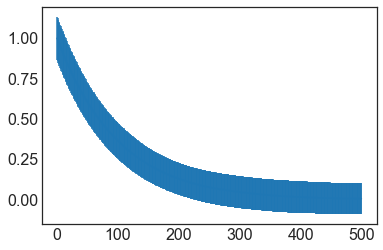

In [5]:
plt.errorbar(t,acf_mean,yerr=acf_std)

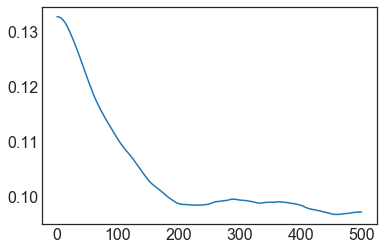

In [6]:
plt.plot(t,acf_std)

In [7]:
acf_all[0].size

500

In [8]:
mod = ExponentialModel()
result_array = None
for i,y in enumerate(acf_all):
    print("***** Iteration ",i," *****")
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out = mod.fit(y, pars, x=t)
    except:
        fit_results = None
        print('fit did not work')
    else:
        fit_results = np.array([out.values['decay']*delta_t,
                            out.covar[0,0],
                            out.values['amplitude'],
                            out.covar[1,1],
                            out.covar[0,1],
                              out.chisqr])
        print(out.fit_report(min_correl=0.25))
        
    pars = mod.make_params()
    pars['decay'].set(value=100,min=0,vary=True)
    pars['amplitude'].set(value=1,min=0,vary=True)
    try:
        out2 = mod.fit(y, pars, x=t, weights=1/acf_std)
    except:
        fit_std_results = None
        print('fit did not work weights')
    else:
        fit_std_results = np.array([out2.values['decay']*delta_t,
                            out2.covar[0,0],
                            out2.values['amplitude'],
                            out2.covar[1,1],
                            out2.covar[0,1],
                            out2.chisqr])
        print(out2.fit_report(min_correl=0.25))
    
    if (fit_results is None) or (fit_std_results is None):
        continue
        
    results = np.concatenate((fit_results, fit_std_results))

    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))


***** Iteration  0  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.37953197
    reduced chi-square = 7.6211e-04
    Akaike info crit   = -3587.71227
    Bayesian info crit = -3579.28305
[[Variables]]
    amplitude:  0.80861570 +/- 0.00548762 (0.68%) (init = 1)
    decay:      99.3941865 +/- 0.96000784 (0.97%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 36.8918773
    reduced chi-square = 0.07408007
    Akaike info crit   = -1299.30835
    Bayesian info crit = -1290.87913
[[Variables]]
    amplitude:  0.79842691 +/- 0.00669524 (0.84%) (init = 1)
    decay:      101.268683 +/- 1.05611196 (

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 222.701964
    reduced chi-square = 0.44719270
    Akaike info crit   = -400.386853
    Bayesian info crit = -391.957637
[[Variables]]
    amplitude:  0.98691742 +/- 0.02006913 (2.03%) (init = 1)
    decay:      69.3036493 +/- 1.78161546 (2.57%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710
***** Iteration  25  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.56268449
    reduced chi-square = 0.00112989
    Akaike info crit   = -3390.82216
    Bayesian info crit = -3382.39294
[[Variables]]
    amplitude:  0.92013703 +/- 0.00521665 (0.57%) (init = 1)
    decay:      170.496636 +/- 1.41852510 

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.50154866
    reduced chi-square = 0.00100713
    Akaike info crit   = -3448.33138
    Bayesian info crit = -3439.90216
[[Variables]]
    amplitude:  0.85205701 +/- 0.00698830 (0.82%) (init = 1)
    decay:      80.4907448 +/- 0.93966440 (1.17%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 47.9633257
    reduced chi-square = 0.09631190
    Akaike info crit   = -1168.08571
    Bayesian info crit = -1159.65650
[[Variables]]
    amplitude:  0.83247490 +/- 0.00844368 (1.01%) (init = 1)
    decay:      83.5739191 +/- 1.06025852 (1.27%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 0.93623023
    reduced chi-square = 0.00187998
    Akaike info crit   = -3136.25098
    Bayesian info crit = -3127.82176
[[Variables]]
    amplitude:  0.73645260 +/- 0.00798829 (1.08%) (init = 1)
    decay:      116.481867 +/- 1.80213747 (1.55%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 87.2403092
    reduced chi-square = 0.17518134
    Akaike info crit   = -868.970806
    Bayesian info crit = -860.541590
[[Variables]]
    amplitude:  0.70657209 +/- 0.00928996 (1.31%) (init = 1)
    decay:      123.447544 +/- 2.02358280 (1.64%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.82579190
    reduced chi-square = 0.00165822
    Akaike info crit   = -3199.01029
    Bayesian info crit = -3190.58107
[[Variables]]
    amplitude:  1.10672629 +/- 0.00824296 (0.74%) (init = 1)
    decay:      95.7308165 +/- 1.01460534 (1.06%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 84.5688137
    reduced chi-square = 0.16981689
    Akaike info crit   = -884.521266
    Bayesian info crit = -876.092050
[[Variables]]
    amplitude:  1.09893600 +/- 0.01039592 (0.95%) (init = 1)
    decay:      96.5051225 +/- 1.13640266 (1.18%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 571.412483
    reduced chi-square = 1.14741462
    Akaike info crit   = 70.7516185
    Bayesian info crit = 79.1808347
[[Variables]]
    amplitude:  1.01808846 +/- 0.02695013 (2.65%) (init = 1)
    decay:      96.9878674 +/- 3.19637620 (3.30%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.721
***** Iteration  130  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.92854489
    reduced chi-square = 0.00588061
    Akaike info crit   = -2566.05121
    Bayesian info crit = -2557.62200
[[Variables]]
    amplitude:  1.56336755 +/- 0.01509109 (0.97%) (init = 1)
    decay:      101.489629 +/- 1.39439627 (

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 3.16058179
    reduced chi-square = 0.00634655
    Akaike info crit   = -2527.92599
    Bayesian info crit = -2519.49677
[[Variables]]
    amplitude:  1.07915771 +/- 0.01956082 (1.81%) (init = 1)
    decay:      64.3246459 +/- 1.66189227 (2.58%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 319.419798
    reduced chi-square = 0.64140522
    Akaike info crit   = -220.050940
    Bayesian info crit = -211.621724
[[Variables]]
    amplitude:  1.09525969 +/- 0.02528938 (2.31%) (init = 1)
    decay:      62.8599716 +/- 1.84742050 (2.94%) (init = 100)
[[Corr

***** Iteration  182  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.14529302
    reduced chi-square = 2.9175e-04
    Akaike info crit   = -4067.80541
    Bayesian info crit = -4059.37620
[[Variables]]
    amplitude:  1.00878947 +/- 0.00307378 (0.30%) (init = 1)
    decay:      122.429981 +/- 0.53291205 (0.44%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.707
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 13.9200237
    reduced chi-square = 0.02795185
    Akaike info crit   = -1786.63987
    Bayesian info crit = -1778.21066
[[Variables]]
    amplitude:  1.01409782 +/- 0.00373717 (0.37%) (init = 1)
    decay:      121.755006 +/- 0.55916321

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 2.84544146
    reduced chi-square = 0.00571374
    Akaike info crit   = -2580.44494
    Bayesian info crit = -2572.01572
[[Variables]]
    amplitude:  1.03299014 +/- 0.01836962 (1.78%) (init = 1)
    decay:      65.7208292 +/- 1.66501424 (2.53%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 46
    # data points      = 500
    # variables        = 2
    chi-square         = 276.309281
    reduced chi-square = 0.55483791
    Akaike info crit   = -292.543638
    Bayesian info crit = -284.114422
[[Variables]]
    amplitude:  1.06095302 +/- 0.02349301 (2.21%) (init = 1)
    decay:      63.0077342 +/- 1.77536452 (2.82%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.85390990
    reduced chi-square = 0.00171468
    Akaike info crit   = -3182.26884
    Bayesian info crit = -3173.83963
[[Variables]]
    amplitude:  0.94814052 +/- 0.00859439 (0.91%) (init = 1)
    decay:      90.9252590 +/- 1.17257286 (1.29%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 83.3361848
    reduced chi-square = 0.16734174
    Akaike info crit   = -891.862626
    Bayesian info crit = -883.433410
[[Variables]]
    amplitude:  0.96546165 +/- 0.01078324 (1.12%) (init = 1)
    decay:      88.7609915 +/- 1.23703457 (1.39%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 2.82442671
    reduced chi-square = 0.00567154
    Akaike info crit   = -2584.15134
    Bayesian info crit = -2575.72213
[[Variables]]
    amplitude:  0.91338269 +/- 0.01746026 (1.91%) (init = 1)
    decay:      72.4061967 +/- 1.97091101 (2.72%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 290.119501
    reduced chi-square = 0.58256928
    Akaike info crit   = -268.157595
    Bayesian info crit = -259.728378
[[Variables]]
    amplitude:  0.92506450 +/- 0.02258211 (2.44%) (init = 1)
    decay:      71.2238462 +/- 2.19390768 (3.08%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.96035828
    reduced chi-square = 0.00192843
    Akaike info crit   = -3123.52848
    Bayesian info crit = -3115.09926
[[Variables]]
    amplitude:  0.80610526 +/- 0.00930781 (1.15%) (init = 1)
    decay:      87.0739612 +/- 1.43054386 (1.64%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 97.4224512
    reduced chi-square = 0.19562741
    Akaike info crit   = -813.775705
    Bayesian info crit = -805.346489
[[Variables]]
    amplitude:  0.81698047 +/- 0.01189276 (1.46%) (init = 1)
    decay:      85.4770561 +/- 1.55466104 (1.82%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 4.94631022
    reduced chi-square = 0.00993235
    Akaike info crit   = -2303.98311
    Bayesian info crit = -2295.55389
[[Variables]]
    amplitude:  1.25282873 +/- 0.02102996 (1.68%) (init = 1)
    decay:      87.8651412 +/- 2.09892993 (2.39%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 505.973695
    reduced chi-square = 1.01601144
    Akaike info crit   = 9.93829152
    Bayesian info crit = 18.3675077
[[Variables]]
    amplitude:  1.27914881 +/- 0.02708786 (2.12%) (init = 1)
    decay:      85.5733875 +/- 2.26382157 (2.65%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 10
    # data points      = 500
    # variables        = 2
    chi-square         = 64.8587224
    reduced chi-square = 0.13023840
    Akaike info crit   = -1017.19835
    Bayesian info crit = -1008.76913
[[Variables]]
    amplitude:  1.08854157 +/- 0.00729624 (0.67%) (init = 1)
    decay:      148.625211 +/- 1.25959379 (0.85%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.740
***** Iteration  337  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.55497469
    reduced chi-square = 0.00111441
    Akaike info crit   = -3397.72043
    Bayesian info crit = -3389.29122
[[Variables]]
    amplitude:  0.98069631 +/- 0.00670391 (0.68%) (init = 1)
    decay:      97.3202451 +/- 0.94668873

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.78515611
    reduced chi-square = 0.00157662
    Akaike info crit   = -3224.24041
    Bayesian info crit = -3215.81119
[[Variables]]
    amplitude:  1.07589752 +/- 0.00730916 (0.68%) (init = 1)
    decay:      116.694011 +/- 1.13078717 (0.97%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 79.1683969
    reduced chi-square = 0.15897268
    Akaike info crit   = -917.515454
    Bayesian info crit = -909.086238
[[Variables]]
    amplitude:  1.06015133 +/- 0.00902820 (0.85%) (init = 1)
    decay:      118.743764 +/- 1.25911997 (1.06%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 6.40169795
    reduced chi-square = 0.01285482
    Akaike info crit   = -2175.02242
    Bayesian info crit = -2166.59320
[[Variables]]
    amplitude:  1.03394943 +/- 0.02908724 (2.81%) (init = 1)
    decay:      58.7456110 +/- 2.35754891 (4.01%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.701
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 653.490534
    reduced chi-square = 1.31222999
    Akaike info crit   = 137.859974
    Bayesian info crit = 146.289191
[[Variables]]
    amplitude:  1.05461266 +/- 0.03807916 (3.61%) (init = 1)
    decay:      56.9337194 +/- 2.63635140 (4.63%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 2.49807954
    reduced chi-square = 0.00501622
    Akaike info crit   = -2645.54292
    Bayesian info crit = -2637.11371
[[Variables]]
    amplitude:  1.07002262 +/- 0.01823437 (1.70%) (init = 1)
    decay:      58.3311813 +/- 1.41756207 (2.43%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.701
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 242.653446
    reduced chi-square = 0.48725592
    Akaike info crit   = -357.486911
    Bayesian info crit = -349.057695
[[Variables]]
    amplitude:  1.09696293 +/- 0.02342027 (2.14%) (init = 1)
    decay:      55.9372549 +/- 1.53297503 (2.74%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 635.518075
    reduced chi-square = 1.27614071
    Akaike info crit   = 123.916217
    Bayesian info crit = 132.345433
[[Variables]]
    amplitude:  1.18402951 +/- 0.02689205 (2.27%) (init = 1)
    decay:      107.841155 +/- 3.04450021 (2.82%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.725
***** Iteration  442  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.13824886
    reduced chi-square = 0.00429367
    Akaike info crit   = -2723.31045
    Bayesian info crit = -2714.88123
[[Variables]]
    amplitude:  0.87469750 +/- 0.01242247 (1.42%) (init = 1)
    decay:      109.700796 +/- 2.21921267 (

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 110.412023
    reduced chi-square = 0.22171089
    Akaike info crit   = -751.194531
    Bayesian info crit = -742.765315
[[Variables]]
    amplitude:  0.94745754 +/- 0.01015835 (1.07%) (init = 1)
    decay:      130.517902 +/- 1.74960845 (1.34%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.733
***** Iteration  469  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 0.76170845
    reduced chi-square = 0.00152954
    Akaike info crit   = -3239.39976
    Bayesian info crit = -3230.97054
[[Variables]]
    amplitude:  1.07155912 +/- 0.00853169 (0.80%) (init = 1)
    decay:      82.0579871 +/- 0.92989472

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.14708093
    reduced chi-square = 0.00230338
    Akaike info crit   = -3034.69385
    Bayesian info crit = -3026.26464
[[Variables]]
    amplitude:  0.88608609 +/- 0.00934211 (1.05%) (init = 1)
    decay:      103.821449 +/- 1.55819825 (1.50%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 118.360467
    reduced chi-square = 0.23767162
    Akaike info crit   = -716.436664
    Bayesian info crit = -708.007447
[[Variables]]
    amplitude:  0.87044690 +/- 0.01169204 (1.34%) (init = 1)
    decay:      106.303775 +/- 1.77521180 (1.67%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.21576516
    reduced chi-square = 4.3326e-04
    Akaike info crit   = -3870.08638
    Bayesian info crit = -3861.65716
[[Variables]]
    amplitude:  1.02859848 +/- 0.00359696 (0.35%) (init = 1)
    decay:      133.596430 +/- 0.66991867 (0.50%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.709
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 22.3044796
    reduced chi-square = 0.04478811
    Akaike info crit   = -1550.91028
    Bayesian info crit = -1542.48106
[[Variables]]
    amplitude:  1.02884861 +/- 0.00451156 (0.44%) (init = 1)
    decay:      133.626104 +/- 0.73379980 (0.55%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 172.245578
    reduced chi-square = 0.34587465
    Akaike info crit   = -528.843432
    Bayesian info crit = -520.414215
[[Variables]]
    amplitude:  0.93850081 +/- 0.01199137 (1.28%) (init = 1)
    decay:      146.091305 +/- 2.35568465 (1.61%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.739
***** Iteration  548  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.13759555
    reduced chi-square = 2.7630e-04
    Akaike info crit   = -4095.02240
    Bayesian info crit = -4086.59318
[[Variables]]
    amplitude:  0.98631927 +/- 0.00269232 (0.27%) (init = 1)
    decay:      154.318344 +/- 0.61073001

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 441.389170
    reduced chi-square = 0.88632364
    Akaike info crit   = -58.3405699
    Bayesian info crit = -49.9113537
[[Variables]]
    amplitude:  1.03213967 +/- 0.02525420 (2.45%) (init = 1)
    decay:      85.8501306 +/- 2.62480557 (3.06%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.717
***** Iteration  574  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.35350163
    reduced chi-square = 0.00271787
    Akaike info crit   = -2951.95653
    Bayesian info crit = -2943.52731
[[Variables]]
    amplitude:  1.18139964 +/- 0.01014845 (0.86%) (init = 1)
    decay:      103.806085 +/- 1.26947152

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.98810872
    reduced chi-square = 0.00198415
    Akaike info crit   = -3109.28532
    Bayesian info crit = -3100.85611
[[Variables]]
    amplitude:  1.00096364 +/- 0.00747105 (0.75%) (init = 1)
    decay:      142.662781 +/- 1.53319889 (1.07%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 94.5334904
    reduced chi-square = 0.18982629
    Akaike info crit   = -828.826966
    Bayesian info crit = -820.397749
[[Variables]]
    amplitude:  0.97613992 +/- 0.00884414 (0.91%) (init = 1)
    decay:      147.414910 +/- 1.68722798 (1.14%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.81622587
    reduced chi-square = 0.00163901
    Akaike info crit   = -3204.83613
    Bayesian info crit = -3196.40691
[[Variables]]
    amplitude:  0.86704389 +/- 0.00586177 (0.68%) (init = 1)
    decay:      202.633761 +/- 2.07547207 (1.02%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.727
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 69.9840411
    reduced chi-square = 0.14053020
    Akaike info crit   = -979.170433
    Bayesian info crit = -970.741217
[[Variables]]
    amplitude:  0.84136071 +/- 0.00645834 (0.77%) (init = 1)
    decay:      210.598569 +/- 2.19254357 (1.04%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 500
    # variables        = 2
    chi-square         = 528.866725
    reduced chi-square = 1.06198138
    Akaike info crit   = 32.0641822
    Bayesian info crit = 40.4933984
[[Variables]]
    amplitude:  1.18895274 +/- 0.03099096 (2.61%) (init = 1)
    decay:      69.0290212 +/- 2.27531185 (3.30%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.710
***** Iteration  652  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 1.86614704
    reduced chi-square = 0.00374728
    Akaike info crit   = -2791.36610
    Bayesian info crit = -2782.93688
[[Variables]]
    amplitude:  1.01768593 +/- 0.01112915 (1.09%) (init = 1)
    decay:      119.803039 +/- 1.87017131 (

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 1.10889667
    reduced chi-square = 0.00222670
    Akaike info crit   = -3051.62128
    Bayesian info crit = -3043.19207
[[Variables]]
    amplitude:  1.01775924 +/- 0.01010829 (0.99%) (init = 1)
    decay:      85.1912106 +/- 1.20407341 (1.41%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 109.647167
    reduced chi-square = 0.22017503
    Akaike info crit   = -754.670229
    Bayesian info crit = -746.241013
[[Variables]]
    amplitude:  1.00023347 +/- 0.01248280 (1.25%) (init = 1)
    decay:      87.2273828 +/- 1.35917948 (1.56%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 5.84658890
    reduced chi-square = 0.01174014
    Akaike info crit   = -2220.37485
    Bayesian info crit = -2211.94563
[[Variables]]
    amplitude:  1.20573381 +/- 0.02197794 (1.82%) (init = 1)
    decay:      95.3139852 +/- 2.47282179 (2.59%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 500
    # variables        = 2
    chi-square         = 586.248620
    reduced chi-square = 1.17720606
    Akaike info crit   = 83.5679335
    Bayesian info crit = 91.9971497
[[Variables]]
    amplitude:  1.23787308 +/- 0.02798273 (2.26%) (init = 1)
    decay:      92.5175823 +/- 2.60667449 (2.82%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 4.31729439
    reduced chi-square = 0.00866927
    Akaike info crit   = -2371.98960
    Bayesian info crit = -2363.56038
[[Variables]]
    amplitude:  0.85634432 +/- 0.01373360 (1.60%) (init = 1)
    decay:      193.211025 +/- 4.64551134 (2.40%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.724
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 500
    # variables        = 2
    chi-square         = 393.252010
    reduced chi-square = 0.78966267
    Akaike info crit   = -116.078723
    Bayesian info crit = -107.649507
[[Variables]]
    amplitude:  0.79208710 +/- 0.01516784 (1.91%) (init = 1)
    decay:      215.309132 +/- 5.62919267 (2.61%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.81051992
    reduced chi-square = 0.00162755
    Akaike info crit   = -3208.34373
    Bayesian info crit = -3199.91451
[[Variables]]
    amplitude:  1.04392062 +/- 0.00937783 (0.90%) (init = 1)
    decay:      72.0125584 +/- 0.92130714 (1.28%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 75.5083266
    reduced chi-square = 0.15162315
    Akaike info crit   = -941.182581
    Bayesian info crit = -932.753365
[[Variables]]
    amplitude:  1.06415578 +/- 0.01164845 (1.09%) (init = 1)
    decay:      69.7377352 +/- 0.96448287 (1.38%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 163.080976
    reduced chi-square = 0.32747184
    Akaike info crit   = -556.180619
    Bayesian info crit = -547.751403
[[Variables]]
    amplitude:  0.97420287 +/- 0.01868740 (1.92%) (init = 1)
    decay:      58.9268876 +/- 1.44554256 (2.45%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
***** Iteration  786  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 500
    # variables        = 2
    chi-square         = 0.68232871
    reduced chi-square = 0.00137014
    Akaike info crit   = -3294.42592
    Bayesian info crit = -3285.99671
[[Variables]]
    amplitude:  1.01301111 +/- 0.00706742 (0.70%) (init = 1)
    decay:      108.068071 +/- 1.07399314

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 5.78105560
    reduced chi-square = 0.01160855
    Akaike info crit   = -2226.01090
    Bayesian info crit = -2217.58169
[[Variables]]
    amplitude:  1.07462353 +/- 0.02632743 (2.45%) (init = 1)
    decay:      64.9632744 +/- 2.26871166 (3.49%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.702
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 500
    # variables        = 2
    chi-square         = 587.215897
    reduced chi-square = 1.17914839
    Akaike info crit   = 84.3922254
    Bayesian info crit = 92.8214416
[[Variables]]
    amplitude:  1.09999434 +/- 0.03433629 (3.12%) (init = 1)
    decay:      62.6916785 +/- 2.49146754 (3.97%) (init = 100)
[[Correl

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 500
    # variables        = 2
    chi-square         = 268.346960
    reduced chi-square = 0.53884932
    Akaike info crit   = -307.163664
    Bayesian info crit = -298.734448
[[Variables]]
    amplitude:  1.33371430 +/- 0.01888568 (1.42%) (init = 1)
    decay:      92.9613668 +/- 1.64011209 (1.76%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.719
***** Iteration  835  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 0.93628685
    reduced chi-square = 0.00188009
    Akaike info crit   = -3136.22074
    Bayesian info crit = -3127.79152
[[Variables]]
    amplitude:  0.84224300 +/- 0.00766873 (0.91%) (init = 1)
    decay:      127.064526 +/- 1.65492266

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 500
    # variables        = 2
    chi-square         = 374.710654
    reduced chi-square = 0.75243103
    Akaike info crit   = -140.226980
    Bayesian info crit = -131.797764
[[Variables]]
    amplitude:  1.00911709 +/- 0.02529144 (2.51%) (init = 1)
    decay:      73.2590991 +/- 2.31188075 (3.16%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.712
***** Iteration  860  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 1.42733605
    reduced chi-square = 0.00286614
    Akaike info crit   = -2925.39915
    Bayesian info crit = -2916.96993
[[Variables]]
    amplitude:  0.95140474 +/- 0.01044015 (1.10%) (init = 1)
    decay:      103.423257 +/- 1.61561658

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 2.22958451
    reduced chi-square = 0.00447708
    Akaike info crit   = -2702.39643
    Bayesian info crit = -2693.96721
[[Variables]]
    amplitude:  1.08024422 +/- 0.01355694 (1.25%) (init = 1)
    decay:      95.5436996 +/- 1.70637975 (1.79%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.704
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 221.160969
    reduced chi-square = 0.44409833
    Akaike info crit   = -403.858648
    Bayesian info crit = -395.429431
[[Variables]]
    amplitude:  1.10492133 +/- 0.01716489 (1.55%) (init = 1)
    decay:      92.7662685 +/- 1.79535250 (1.94%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 500
    # variables        = 2
    chi-square         = 52.1127760
    reduced chi-square = 0.10464413
    Akaike info crit   = -1126.59898
    Bayesian info crit = -1118.16976
[[Variables]]
    amplitude:  0.80112336 +/- 0.01130696 (1.41%) (init = 1)
    decay:      51.6566080 +/- 0.94224451 (1.82%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
***** Iteration  912  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 500
    # variables        = 2
    chi-square         = 3.11644929
    reduced chi-square = 0.00625793
    Akaike info crit   = -2534.95690
    Bayesian info crit = -2526.52768
[[Variables]]
    amplitude:  1.26308160 +/- 0.01860423 (1.47%) (init = 1)
    decay:      70.3005570 +/- 1.47507756

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 3.56843304
    reduced chi-square = 0.00716553
    Akaike info crit   = -2467.24076
    Bayesian info crit = -2458.81155
[[Variables]]
    amplitude:  1.01766071 +/- 0.01778822 (1.75%) (init = 1)
    decay:      88.6241476 +/- 2.20432324 (2.49%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.703
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 500
    # variables        = 2
    chi-square         = 373.361049
    reduced chi-square = 0.74972098
    Akaike info crit   = -142.031094
    Bayesian info crit = -133.601878
[[Variables]]
    amplitude:  1.01370383 +/- 0.02280426 (2.25%) (init = 1)
    decay:      88.9038202 +/- 2.49570705 (2.81%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 0.91124978
    reduced chi-square = 0.00182982
    Akaike info crit   = -3149.77317
    Bayesian info crit = -3141.34395
[[Variables]]
    amplitude:  0.88983212 +/- 0.00782774 (0.88%) (init = 1)
    decay:      118.163370 +/- 1.48317394 (1.26%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.706
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 500
    # variables        = 2
    chi-square         = 93.7982579
    reduced chi-square = 0.18834992
    Akaike info crit   = -832.730907
    Bayesian info crit = -824.301691
[[Variables]]
    amplitude:  0.87378635 +/- 0.00973457 (1.11%) (init = 1)
    decay:      120.948907 +/- 1.67860783 (1.39%) (init = 100)
[[Corr

[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 500
    # variables        = 2
    chi-square         = 485.180410
    reduced chi-square = 0.97425785
    Akaike info crit   = -11.0436488
    Bayesian info crit = -2.61443258
[[Variables]]
    amplitude:  1.01245727 +/- 0.03289194 (3.25%) (init = 1)
    decay:      56.6625204 +/- 2.36167396 (4.17%) (init = 100)
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, decay) = -0.705
***** Iteration  988  *****
[[Model]]
    Model(exponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 500
    # variables        = 2
    chi-square         = 1.94866666
    reduced chi-square = 0.00391299
    Akaike info crit   = -2769.73136
    Bayesian info crit = -2761.30215
[[Variables]]
    amplitude:  1.26142742 +/- 0.01299596 (1.03%) (init = 1)
    decay:      90.7270629 +/- 1.33014246

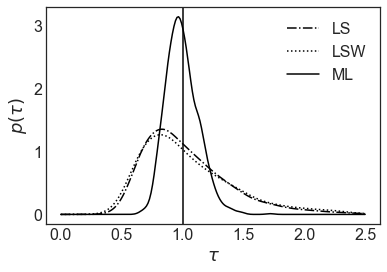

In [9]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

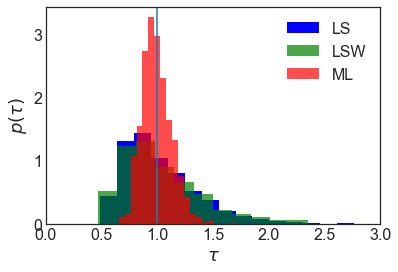

In [10]:
# decay time
plt.figure(facecolor="white")
plt.hist(result_array.T[0],density=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[6],density=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[2],density=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.xlim((0,3))
plt.savefig("tau_dist300.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [11]:
phi = 1/result_array.T[3]
theta = 1/result_array.T[1]
omega = 1/result_array.T[4]
dA = np.sqrt(-theta/(phi*theta-omega**2))
dT = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

phiW = 1/result_array.T[9]
thetaW = 1/result_array.T[7]
omegaW = 1/result_array.T[10]
dAW = np.sqrt(-theta/(phi*theta-omega**2))
dTW = np.sqrt(-phi/(phi*theta-omega**2))*delta_t

In [12]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.00011450259084103781
Decay time LS std (fit corrected): 0.000113979437567719
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.000113979437567719
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101


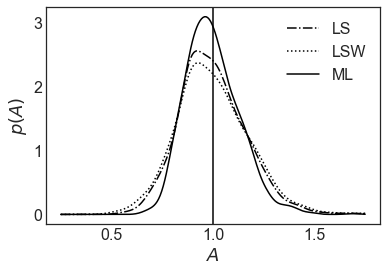

In [13]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW")
plt.plot(xs,densityML(xs),"k-",label="ML")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

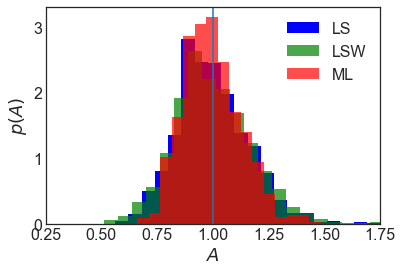

In [14]:
# amplitude
plt.hist(result_array.T[2],density=True,bins=20,label="LS",color="blue")
plt.hist(result_array.T[8],density=True,alpha=0.7,bins=20,label="LSW",color="green")
plt.hist(result_Bayes_array.T[0],density=True,alpha=0.7,bins=20,label="ML",color="red")
plt.axvline(x=1.0)
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")

plt.xlim((0.25,1.75))
plt.savefig("A_dist300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [15]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 1.6478751794738906
Amplitude LS std (fit corrected): 1.6578702573632431
Amplitude LSW mean (real): 0.0002714528255314531
Amplitude LSW std (real): 0.00034691485586727563
Amplitude LSW stderr (real): 3.4691485586727565e-06
Amplitude LSW std (fit): 0.9950832668680414
Amplitude LSW std (fit corrected): 1.6578702573632431
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702


(1000, 12)
(1000, 4)
(0.3183106738638477, 5.5484464485969005e-25)


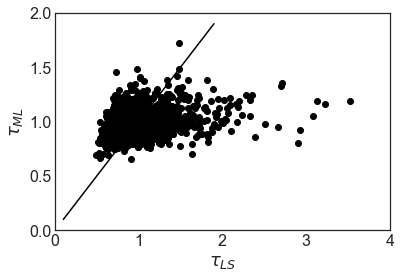

In [16]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(result_array.T[0],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(result_array.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.8370114347767421, 1.3727086902429519e-263)


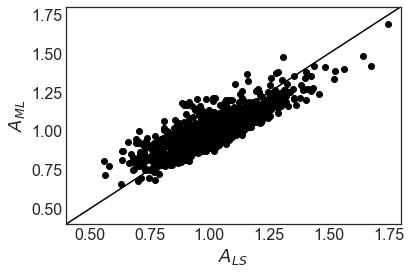

In [17]:
# amplitude correlation
plt.scatter(result_array.T[2],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(result_array.T[2],result_Bayes_array.T[0]))
plt.savefig("A_corr300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [18]:
for i,a,da,t,dt in zip(range(len(result_array.T[2])),result_array.T[2],dA,result_array.T[0],dT):
    print(i,a,da,t,dt)

0 0.808615696056012 0.9520460345979704 0.9939418654806541 5.44211158822298e-05
1 0.7384507401780944 4.862577555746134 1.659481283174133 0.0001480077515543126
2 0.8189945390255113 1.7689000724257453 1.2161571144605954 8.34126965096077e-05
3 1.177426213439023 0.8946273247059087 0.869670623699744 8.512380556837136e-05
4 1.0437891737470233 1.2763371773673646 0.6674355511975543 0.00014007021533873082
5 0.883051617048809 1.028418417380065 0.7431840677695469 8.582190529365809e-05
6 0.9986686993248759 0.61485594985586 0.8289406605407509 5.205087905933228e-05
7 0.8705609103632095 1.5361640341763998 1.2761723469792459 7.324202103499731e-05
8 1.0469415961904982 0.7094509812806725 1.0666728821039506 4.889410637600743e-05
9 0.8705229773500358 1.1921526795272193 1.404644623697107 5.136756260122944e-05
10 1.210331143970472 1.6411396323246221 0.6449979054220899 0.00021603434174906265
11 1.0678373545348654 2.633043239929993 1.5898917788383589 0.00012159441384276045
12 1.0466327034058365 3.0249401391300

780 0.8981858781773897 2.070193544498615 0.938953991049768 0.00013916087251437904
781 1.1089231865841604 1.8836144854364107 1.0575073963309247 0.00013871709160451996
782 0.8626612463605734 1.1715090012506482 1.401342525820154 5.014815611821599e-05
783 1.0788594939256915 2.3264699802726017 1.321247544458719 0.00013256183751347655
784 1.220982133299454 2.056637334203528 0.9461558188097436 0.00018654825741968862
785 0.9566408436918385 1.2879177434178692 0.6078060067541023 0.00014218632376073565
786 1.0130111116157487 1.067538840175786 1.0806807078851406 7.024946578554132e-05
787 0.8967186589002143 1.4621684331099856 0.80553684657499 0.00011435505597585168
788 0.8838868353945983 0.585753925250844 0.8286214373447086 4.390336967763472e-05
789 0.880865566997485 1.4196160155651425 1.4538035117969546 5.965081754555997e-05
790 0.9766455245428014 2.107996066878488 1.4167002149729446 0.000100973927008641
791 0.825727914599834 3.3894092338137223 2.1720476375857327 8.360931221854162e-05
792 0.957464

In [19]:
n=209
acf = acf_all[n]
t = np.arange(len(acf))*delta_t
fit = result_array.T[2][n]*np.exp(-t/result_array.T[0][n])
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2)))
print(-(result_array.T[2][n]-1.0)**2/2.0/result_array.T[3][n]**2/np.log(10))
print(1/np.sqrt(2*np.pi))
print("{0:.2E}".format(1/np.sqrt(2*np.pi)*np.exp(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2)))
print(-(result_array.T[0][n]-1.0)**2/2.0/result_array.T[1][n]**2/np.log(10))
print(acf.shape)

2.66E-01
-0.1768065739727682
0.3989422804014327
0.00E+00
-84750898.99543495
(500,)


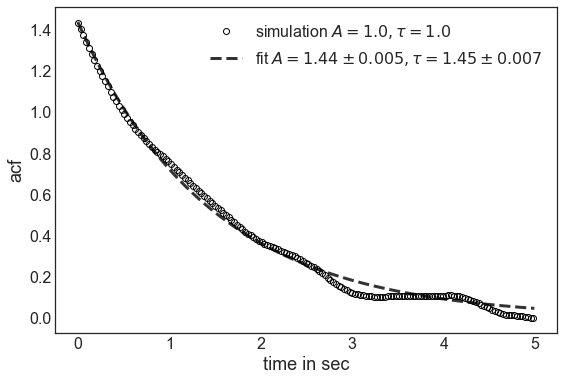

In [20]:
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t,fit,"k--",linewidth=3,label=r"fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [21]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [22]:
# plot deviation from true D as function of N
Nsim = np.array([2000,10000,50000])
Nsimfit = np.array([1500,10000,60000])
dD = np.array([0.36,0.05,0.014])

(0.005, 1)

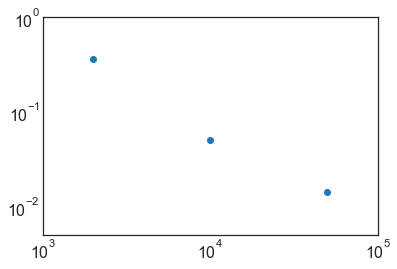

In [23]:
plt.plot(Nsim,dD,"o")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))

In [24]:
lnNsim = np.log(Nsim)
lndD = np.log(dD)

In [25]:
p = np.polyfit(lnNsim,lndD,1)

In [26]:
# dD = A*Nsim**gamma
# ln dD = ln A + gamma*ln Nsim
dDfit = np.exp(p[1])*Nsimfit**p[0]

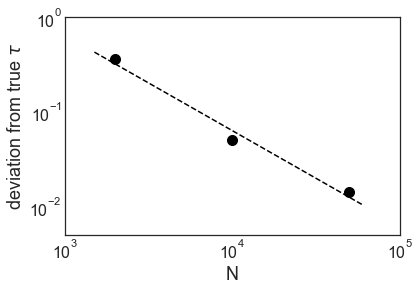

In [27]:
plt.plot(Nsim,dD,"ko",markersize=10)
plt.plot(Nsimfit,dDfit,"k--")
plt.xscale('log')
plt.yscale('log')
plt.xlim((1000,100000))
plt.ylim((0.005,1))
plt.xlabel("N")
plt.ylabel(r"deviation from true $\tau$")
plt.savefig("deviation.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [29]:
with pm.Model() as model:
    A = pm.Uniform('A', lower=0, upper=20)
    ta = pm.Uniform('ta', lower=0, upper=20)

    likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/ta),tau=1/acf_std**2,observed=acf)
    
    trace = pm.sample(10000)
    
#pm.traceplot(trace)
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4637.53draws/s]
The acceptance probability does not match the target. It is 0.899849457067047, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9566609199018806, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9551782468271909, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/hstrey/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
A,1.448877,0.020173,0.000168,1.408860,1.487510,13803.545378,1.000120
ta,1.443843,0.024925,0.000220,1.394744,1.492315,13261.437533,1.000104


[1.40950247 1.4286389  1.43515919 1.44876971 1.4625353  1.4691495
 1.48826449]
[1.39587552 1.4188733  1.42664851 1.44348106 1.46071685 1.46877542
 1.49362238]
A_sigma 0.020255304760275705
tau_sigma 0.024951062426833426


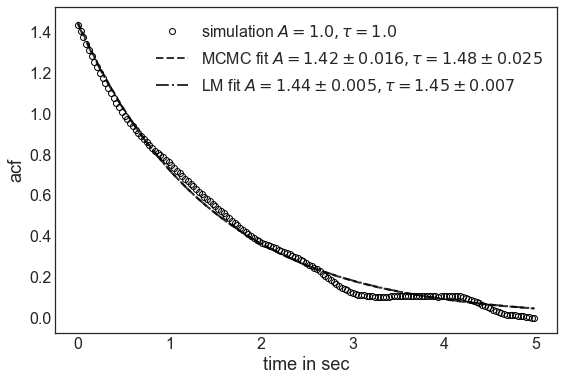

In [32]:
A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
tau_perc=np.percentile(trace['ta'],[2.5,15.865,25,50,75,84.135,97.5])
print(A_perc)
print(tau_perc)
print('A_sigma',(A_perc[5]-A_perc[1])/2)
print('tau_sigma',(tau_perc[5]-tau_perc[1])/2)
plt.figure(figsize=(9,6))
plt.plot(t[::3],acf[::3],"o",markersize=6,fillstyle="none",markeredgewidth=1,markeredgecolor="k",label=r"simulation $A=1.0,\tau=1.0$")
plt.plot(t[::3],trace['A'].mean()*np.exp(-t[::3]/trace['ta'].mean()),"k--",linewidth=2,label=r"MCMC fit $A=1.42\pm0.016,\tau=1.48\pm0.025$",alpha=0.8)
plt.plot(t[::3],fit[::3],"k-.",linewidth=2,label=r"LM fit $A=1.44\pm0.005,\tau=1.45\pm0.007$",alpha=0.8)
plt.xlabel("time in sec")
plt.ylabel("acf")
plt.legend()
plt.savefig("exp_fit300MCMC.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

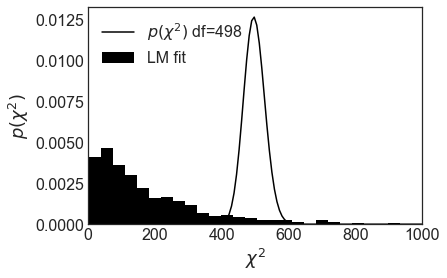

In [33]:
# lets look at the chi^2 distribution of the least-square fit
x=np.linspace(0,1500,200)
chi2dist = chi2.pdf(x,500-2)
plt.hist(result_array.T[11],bins=50,color="k",density=True,label="LM fit")
plt.plot(x,chi2dist,color="k",label=r"$p(\chi^{2})$ df=498")
plt.xlim((0,1000))
plt.ylabel(r"$p(\chi^{2})$")
plt.xlabel(r"$\chi^2$")
plt.legend(loc="upper left")
plt.savefig("chi2dist.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [34]:
result_array.T[11].mean()

192.78086697829272

In [35]:
# use mcmc for all fits
mcmc_results = None

for i,y in enumerate(acf_all):
    with pm.Model() as model:
        A = pm.Uniform('A', lower=0, upper=20)
        ta = pm.Uniform('ta', lower=0, upper=20)

        likelihood = pm.Normal('likelihood', mu=A*pm.math.exp(-t/ta),tau=1/acf_std**2,observed=y)
    
        trace = pm.sample(10000)
    A_perc= np.percentile(trace['A'],[2.5,15.865,25,50,75,84.135,97.5])
    tau_perc=np.percentile(trace['ta'],[2.5,15.865,25,50,75,84.135,97.5])
    print(A_perc)
    print(tau_perc)
    A_sigma = (A_perc[5]-A_perc[1])/2
    tau_sigma = (tau_perc[5]-tau_perc[1])/2
    A_med = A_perc[3]
    tau_med = tau_perc[3]
    if mcmc_results is None:
        mcmc_results = np.array([A_med,tau_med,A_sigma,tau_sigma])
    else:
        mcmc_results = np.vstack((mcmc_results,np.array([A_med,tau_med,A_sigma,tau_sigma])))




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6175.76draws/s]
The acceptance probability does not match the target. It is 0.8863250946385903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802359117287623, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.74927915 0.7724453  0.78048311 0.79764781 0.81462685 0.82290033
 0.84844503]
[0.93702475 0.9741794  0.98700787 1.01354353 1.04146409 1.05547366
 1.09681086]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5089.61draws/s]
The acceptance probability does not match the target. It is 0.9120687940508184, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61805916 0.63820896 0.64500072 0.65944519 0.67383144 0.68096619
 0.70258272]
[1.78127793 1.86444756 1.89351238 1.95477711 2.01935054 2.0510267
 2.15036158]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4920.98draws/s]
The acceptance probability does not match the target. It is 0.9268909574030245, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9361231739794178, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9287508683117057, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9359519727788146, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73601336 0.7581885  0.76585726 0.78207501 0.7984564  0.80641395
 0.8302686 ]
[1.19937694 1.24739416 1.26374239 1.29949445 1.33615625 1.35489386
 1.40765803]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5982.51draws/s]
The acceptance probability does not match the target. It is 0.908864551233747, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787317794740648, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14147548 1.16703568 1.17552766 1.19337335 1.21087892 1.21942739
 1.24458946]
[0.80983381 0.8302444  0.83744329 0.85247547 0.86791975 0.8753617
 0.89871348]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6029.83draws/s]
The acceptance probability does not match the target. It is 0.885790382096154, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8897236253939274, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9063615695363677, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01031252 1.03780727 1.04729392 1.06684987 1.08615244 1.09581261
 1.12344927]
[0.60626351 0.62477417 0.63117231 0.64461271 0.65859988 0.66559174
 0.6862593 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5872.77draws/s]
The acceptance probability does not match the target. It is 0.9067032389200397, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799062123262618, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83054508 0.85839457 0.86797035 0.8878696  0.90741752 0.91701371
 0.94552561]
[0.67721316 0.70508996 0.71457612 0.73504862 0.75617205 0.76654641
 0.79834804]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5845.25draws/s]
The acceptance probability does not match the target. It is 0.8963378965546115, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840869868298173, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818461054285699, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95189885 0.97696447 0.98566795 1.00384094 1.02220102 1.03128806
 1.05815951]
[0.77104134 0.79519112 0.80409987 0.82237751 0.84090618 0.85003263
 0.87692368]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6030.25draws/s]
The acceptance probability does not match the target. It is 0.8913656406915134, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935180286064912, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8190326  0.83960383 0.84653924 0.86116455 0.87604186 0.8831709
 0.90378583]
[1.22159184 1.25979347 1.27265159 1.29959867 1.32735985 1.34088977
 1.38125819]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5659.33draws/s]
The acceptance probability does not match the target. It is 0.9064218180739329, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936562303898956, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9032272768765046, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00015418 1.02238275 1.03037093 1.04654409 1.06299969 1.07100611
 1.09490995]
[1.0069044  1.03580304 1.04582276 1.06623271 1.08747782 1.09810595
 1.12941478]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4582.52draws/s]
The acceptance probability does not match the target. It is 0.9419939174975324, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866621558545938, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9033284619069989, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81019386 0.83047599 0.8376706  0.85231376 0.8668615  0.87387467
 0.89501053]
[1.35616906 1.39901467 1.41390754 1.4457356  1.47892296 1.49486835
 1.5446048 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5443.67draws/s]
The acceptance probability does not match the target. It is 0.8983995382010542, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9052218359351559, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9344842068645817, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862362145878658, but should be close to 0.8. Try to increase the number of tuning steps.


[1.18831829 1.2157794  1.22534677 1.24499154 1.26427428 1.27360874
 1.30151109]
[0.58581865 0.60065446 0.60597568 0.61675689 0.62781024 0.63312144
 0.64959941]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4419.89draws/s]
The acceptance probability does not match the target. It is 0.8992451255771818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875742725234266, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98245993 1.00176487 1.00842977 1.02233594 1.03634531 1.04323242
 1.06312249]
[1.59686471 1.63953889 1.65422237 1.68497469 1.71659901 1.73199843
 1.77854907]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4653.39draws/s]
The acceptance probability does not match the target. It is 0.8840300869381459, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8941594483384137, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.96197646 0.98125378 0.98775702 1.00171545 1.01508275 1.02179498
 1.04147709]
[1.6987375  1.74432545 1.7601406  1.7945758  1.82918394 1.84638168
 1.89788443]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4372.79draws/s]
The acceptance probability does not match the target. It is 0.8798433186574405, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012947302788077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9084825163697936, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835845215334652, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.89322709 0.91089937 0.91703895 0.92955187 0.94234006 0.94843827
 0.96706611]
[1.78171575 1.82895254 1.84555513 1.87987999 1.91508397 1.93260877
 1.98315934]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5703.38draws/s]
The acceptance probability does not match the target. It is 0.8806005642052738, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.881762701063679, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.70067404 0.71976693 0.72656    0.74038006 0.75464179 0.76147257
 0.7816846 ]
[1.50591919 1.55960355 1.57889505 1.61836123 1.65983218 1.68044253
 1.74086935]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5107.49draws/s]
The acceptance probability does not match the target. It is 0.8927855798573506, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9057334591647848, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878757047499679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9281128708757262, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78495702 0.80781219 0.81565576 0.83201397 0.84864816 0.85672076
 0.88108182]
[0.97218035 1.00783784 1.02056547 1.04665211 1.07357749 1.08675402
 1.12646831]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4565.37draws/s]
The acceptance probability does not match the target. It is 0.891746086829828, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910583158228177, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9393934871367244, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66688353 0.68621176 0.69280233 0.7066991  0.72036644 0.72709975
 0.74643471]
[1.68876249 1.75359181 1.77623671 1.82457617 1.87456979 1.89950424
 1.97684793]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5842.41draws/s]
The acceptance probability does not match the target. It is 0.8836005901260359, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894889309972328, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8868816  0.90954715 0.91720394 0.93352397 0.94949678 0.95720963
 0.98087318]
[0.9852295  1.01687153 1.02744673 1.0496296  1.07255134 1.08375834
 1.11778643]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5372.35draws/s]
The acceptance probability does not match the target. It is 0.9149283864534169, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8891191443149828, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812793446721063, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83407653 0.85745992 0.86550478 0.88192644 0.89865481 0.9067347
 0.93128994]
[0.93899    0.97114266 0.98201997 1.00553146 1.02944643 1.04108468
 1.07623336]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5909.93draws/s]
The acceptance probability does not match the target. It is 0.9043567104627778, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8877676877992882, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9024303785828104, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861626069684305, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12210467 1.14695092 1.1551143  1.1722805  1.18980091 1.19804266
 1.22326291]
[0.71644621 0.73351839 0.73923013 0.75114399 0.76335004 0.76929159
 0.78708596]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4726.12draws/s]
The acceptance probability does not match the target. It is 0.9377404518811472, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796889453340808, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9000487231946501, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9449390220640204, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87883008 0.89712077 0.90376241 0.91645495 0.92942509 0.93558907
 0.95372075]
[1.67179681 1.71521439 1.73055354 1.76270213 1.79566547 1.81219067
 1.86167712]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4748.27draws/s]
The acceptance probability does not match the target. It is 0.9400120197715052, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8872118107170385, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90909014 0.92590415 0.93168264 0.94366226 0.9557081  0.96158738
 0.97881146]
[2.10768054 2.16103121 2.18022498 2.21940729 2.25949515 2.2794883
 2.33958942]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5968.64draws/s]
The acceptance probability does not match the target. It is 0.8902612735735838, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8883272042287574, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02779108 1.05561992 1.06495708 1.08411021 1.10376922 1.1132671
 1.14128426]
[0.61361531 0.63261131 0.63903537 0.6528985  0.66631818 0.67318468
 0.69312661]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5218.82draws/s]
The acceptance probability does not match the target. It is 0.9123474807958822, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82485618 0.84392039 0.85053269 0.86433793 0.87827434 0.88519726
 0.90493802]
[1.37876086 1.41818197 1.43250247 1.46224868 1.49211813 1.50707113
 1.55064417]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5173.12draws/s]
The acceptance probability does not match the target. It is 0.8788176391192423, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871862225842969, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8864317757217439, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9403132890787876, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93130498 0.95860458 0.96758856 0.98624222 1.00516357 1.01441562
 1.04225113]
[0.64982076 0.67082625 0.67816551 0.69354547 0.70931063 0.71693713
 0.73962718]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5783.65draws/s]
The number of effective samples is smaller than 25% for some parameters.


[0.86389886 0.88222857 0.8885738  0.90168429 0.91472064 0.92099708
 0.93968494]
[1.65801718 1.70473891 1.72042001 1.75390282 1.78820422 1.80488458
 1.85560331]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5275.63draws/s]
The acceptance probability does not match the target. It is 0.887039580477996, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.894126054366995, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87942555 0.89804181 0.90453184 0.91770674 0.93112153 0.93779667
 0.95726154]
[1.60904298 1.65499372 1.67036074 1.70325809 1.73756441 1.75392434
 1.80256362]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4519.14draws/s]
The acceptance probability does not match the target. It is 0.9400911687980652, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890600276752633, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846738942750317, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78917746 0.81168252 0.81916664 0.83509888 0.85131494 0.85900342
 0.88273036]
[1.08338457 1.1225988  1.13580366 1.16465978 1.19394988 1.20822936
 1.25030428]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5663.82draws/s]
The acceptance probability does not match the target. It is 0.881259647905241, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846668327043093, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900030351120631, but should be close to 0.8. Try to increase the number of tuning steps.


[1.22422224 1.24752038 1.25562013 1.27208579 1.2889392  1.29701896
 1.32048182]
[0.95806024 0.98051475 0.9880755  1.00399704 1.02068637 1.02861515
 1.05265618]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5557.00draws/s]
The acceptance probability does not match the target. It is 0.9021616426065243, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882267825242124, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885201506434348, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83315946 0.85771609 0.86628979 0.88413366 0.90182196 0.91054559
 0.93679072]
[0.82650419 0.85761312 0.86815532 0.89081133 0.91352684 0.92504066
 0.95938271]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4342.57draws/s]
The acceptance probability does not match the target. It is 0.8980881444305017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948655367200141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901668592138006, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81961644 0.84229287 0.84957853 0.86531747 0.88107963 0.88888231
 0.9119467 ]
[1.25733559 1.30101876 1.3169645  1.34962891 1.38276297 1.39924571
 1.44923382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5927.84draws/s]
The acceptance probability does not match the target. It is 0.8854462637499751, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89519266 0.91944276 0.92786797 0.94530597 0.96286552 0.9711664
 0.99630827]
[0.76706582 0.79103546 0.79923416 0.81640418 0.83427683 0.84291115
 0.86866184]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5835.96draws/s]
The acceptance probability does not match the target. It is 0.8873690260919704, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856498631553997, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96183031 0.98921904 0.99879147 1.01852452 1.03855873 1.04832814
 1.07784719]
[0.61933378 0.64080001 0.64821819 0.66384648 0.6797476  0.68766514
 0.71099519]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4880.34draws/s]
The acceptance probability does not match the target. It is 0.937470498361716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912759747638098, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9041376552653841, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869252618026779, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.86565443 0.88827653 0.89594739 0.91204378 0.92790038 0.93557614
 0.95875137]
[1.03313593 1.06649322 1.07787093 1.10185533 1.12644367 1.13837606
 1.17466051]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5216.15draws/s]
The acceptance probability does not match the target. It is 0.9277522789425665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.930111966532502, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.929117728753727, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796299625172592, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8236805  0.85285968 0.86274948 0.88354478 0.90508183 0.91569697
 0.94631417]
[0.58947187 0.61564976 0.62503007 0.64444644 0.66463102 0.6744568
 0.70409152]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5206.55draws/s]
The acceptance probability does not match the target. It is 0.8831476604590167, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9226582188029357, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81341878 0.83933596 0.84816483 0.86695055 0.88576815 0.89477439
 0.9223206 ]
[0.76962955 0.79919748 0.81023572 0.83281131 0.85620591 0.86743664
 0.90177201]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5350.85draws/s]
The acceptance probability does not match the target. It is 0.8965131420111807, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8950967215803596, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9367346978372364, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.13722279 1.16334467 1.1721594  1.19042277 1.20882641 1.21784398
 1.24435356]
[0.67707115 0.69457483 0.70070223 0.71345624 0.72650413 0.73278215
 0.75215741]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5530.72draws/s]
The acceptance probability does not match the target. It is 0.8995374901278217, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9031857646698187, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03269808 1.05449713 1.06170857 1.07711957 1.09284919 1.10046811
 1.1231238 ]
[1.13716683 1.16787972 1.17830723 1.20015161 1.22241547 1.23329943
 1.2659572 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4762.34draws/s]
The acceptance probability does not match the target. It is 0.9239681991551867, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9477656510172398, but should be close to 0.8. Try to increase the number of tuning steps.


[1.43207591 1.4541387  1.46185053 1.47740967 1.49325807 1.50076818
 1.52280059]
[0.90552475 0.92049334 0.92579198 0.93669795 0.94763092 0.95288491
 0.96892908]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5894.02draws/s]
The acceptance probability does not match the target. It is 0.891378426114527, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791256001376592, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8996783240182668, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87158775 0.89471279 0.90256943 0.91876611 0.93499401 0.942772
 0.96675582]
[0.89611808 0.92362961 0.93309029 0.95285874 0.97315444 0.98317772
 1.01297683]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5914.44draws/s]
The acceptance probability does not match the target. It is 0.8789884239149879, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889074314912017, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01579716 1.03685935 1.04404952 1.05833325 1.07257955 1.07928893
 1.09982653]
[1.2199226  1.24900996 1.25913351 1.27985488 1.30089827 1.3112407
 1.34267331]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4571.57draws/s]
The acceptance probability does not match the target. It is 0.9480267968018351, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9195514847886086, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848810341112339, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08302293 1.10823957 1.11703922 1.13541433 1.1540981  1.16311197
 1.18967063]
[0.67873592 0.69688003 0.70321003 0.71663791 0.72997627 0.73659927
 0.75585196]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4654.25draws/s]
The acceptance probability does not match the target. It is 0.882116841846829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9025245658472457, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9058396639075482, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21718379 1.23502689 1.2410906  1.25384185 1.26629927 1.27243528
 1.29091638]
[1.78260275 1.81751777 1.82968849 1.85447539 1.8798394  1.89200065
 1.93021358]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4923.27draws/s]
The acceptance probability does not match the target. It is 0.8831237498206651, but should be close to 0.8. Try to increase the number of tuning steps.


[0.5910703  0.61388914 0.6214706  0.63762981 0.65395607 0.6624624
 0.6866348 ]
[1.2436437  1.30885665 1.33142841 1.38018115 1.42976303 1.45432612
 1.5305972 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4843.20draws/s]
The acceptance probability does not match the target. It is 0.8865664659481663, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9423040948913691, but should be close to 0.8. Try to increase the number of tuning steps.


[1.20234404 1.22468722 1.23216349 1.24798327 1.26391787 1.27151694
 1.29424395]
[0.96942994 0.99056182 0.99775275 1.01284521 1.02822916 1.03576666
 1.05778378]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5190.97draws/s]
The acceptance probability does not match the target. It is 0.8933392507043376, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9429779930249808, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873076834508555, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9010107874925395, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03761383 1.06440189 1.07353627 1.09316077 1.11265022 1.1222035
 1.15032097]
[0.59281086 0.60964459 0.61552461 0.62816533 0.64085774 0.64709818
 0.66576793]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5641.64draws/s]
The acceptance probability does not match the target. It is 0.8879269988659346, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.916870537042199, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911568988119556, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9008135536249566, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99929726 1.0244749  1.03316339 1.05097573 1.06882341 1.07748022
 1.10287785]
[0.80029312 0.82379355 0.83178641 0.84911935 0.86683067 0.87549269
 0.90160177]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5875.52draws/s]
The acceptance probability does not match the target. It is 0.9003890136105902, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803075888200982, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83421653 0.8596709  0.86851574 0.88707513 0.90538631 0.91440445
 0.94107865]
[0.73405114 0.76064051 0.7697624  0.78941801 0.80980591 0.81975616
 0.85032303]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4297.36draws/s]
The acceptance probability does not match the target. It is 0.964709600971858, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9003348676180746, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8919233736230159, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9533635274621791, but should be close to 0.8. Try to increase the number of tuning steps.


[1.72564128 1.74472767 1.75127946 1.76466506 1.77837665 1.78503616
 1.80411348]
[1.42397296 1.44263669 1.44929813 1.46323442 1.47731894 1.48410441
 1.50376749]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5341.88draws/s]
The acceptance probability does not match the target. It is 0.9332162953784481, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893175397741826, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97753124 1.00164076 1.01019261 1.0277567  1.04567792 1.05455499
 1.07948545]
[0.77626361 0.79925984 0.80708677 0.82352059 0.84072973 0.84895647
 0.87359992]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6044.59draws/s]
The acceptance probability does not match the target. It is 0.882983920430908, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878208916099962, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86288538 0.89069927 0.90016741 0.91974326 0.93961596 0.94943648
 0.97772678]
[0.64006285 0.6642033  0.67267679 0.69113485 0.70956795 0.71859742
 0.74587604]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5286.56draws/s]
The acceptance probability does not match the target. It is 0.9091490054926027, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884339586943107, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77602424 0.80328212 0.81257458 0.8321301  0.85162866 0.86132281
 0.88969101]
[0.7643995  0.79869713 0.81057048 0.83631499 0.86256541 0.87525714
 0.9157539 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4950.52draws/s]
The acceptance probability does not match the target. It is 0.900526907727426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993959796298765, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875750461508147, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04133706 1.05757212 1.06292725 1.0742484  1.08525733 1.09074855
 1.10701372]
[2.23318487 2.27990433 2.29600416 2.33016736 2.36497134 2.38229033
 2.43557926]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5687.22draws/s]
The acceptance probability does not match the target. It is 0.8793586222189643, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9046425671893287, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948715096385997, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8991508624209738, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73082035 0.75468433 0.76281551 0.77986781 0.79736901 0.80555489
 0.8303273 ]
[0.89229569 0.92745641 0.93977002 0.96594732 0.99276576 1.00636199
 1.04607923]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5940.87draws/s]
The acceptance probability does not match the target. It is 0.8876497014130669, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887536685309093, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96496806 0.98658568 0.99398164 1.0097048  1.0253909  1.03315063
 1.05641859]
[0.949735   0.97495041 0.98356828 1.00171503 1.01999948 1.02935862
 1.05648932]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5550.10draws/s]
The acceptance probability does not match the target. It is 0.887930229096662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9151000306363406, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857774256136246, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94091762 0.96420168 0.97213775 0.9888746  1.00566686 1.01374813
 1.03761614]
[0.92174699 0.94824134 0.9577004  0.97784943 0.99860265 1.00848101
 1.03965529]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4805.95draws/s]
The acceptance probability does not match the target. It is 0.9416823547704967, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901074147683462, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77382062 0.79551599 0.80271366 0.81769695 0.83299203 0.84025635
 0.8625104 ]
[1.20977669 1.25129918 1.26565785 1.29588454 1.3266357  1.3423363
 1.38952593]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4681.96draws/s]
The acceptance probability does not match the target. It is 0.9482617571969816, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.947365774677487, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8851662937415248, but should be close to 0.8. Try to increase the number of tuning steps.


[1.17357623 1.19548775 1.20285542 1.21817357 1.23346531 1.24102259
 1.26294528]
[0.98374179 1.00449828 1.01141306 1.02633292 1.04127815 1.04881691
 1.0707473 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4533.30draws/s]
The acceptance probability does not match the target. It is 0.8789619790027297, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8991933593088612, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.84685128 0.86950105 0.87727728 0.89361496 0.910043   0.91790256
 0.94145035]
[1.1977889  1.23884786 1.25399421 1.28516868 1.31693596 1.33284589
 1.381184  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4615.51draws/s]
The acceptance probability does not match the target. It is 0.9542566409948623, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861006174552188, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98836214 1.01164701 1.01979808 1.03695128 1.05436674 1.06267277
 1.08838512]
[0.84813893 0.87304103 0.88176916 0.90004526 0.91817169 0.92712507
 0.95450405]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5778.10draws/s]
The acceptance probability does not match the target. It is 0.8837508208379264, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892178565231768, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8975847174535928, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885378249152188, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73879516 0.76019657 0.76762479 0.78280159 0.79835919 0.80577792
 0.82816044]
[1.09406854 1.13275975 1.14633344 1.17451435 1.20396449 1.21828312
 1.26060094]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4626.94draws/s]
The acceptance probability does not match the target. It is 0.8797738083116023, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.894647529608305, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9245170231116782, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9497716345661307, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90402366 0.93336314 0.94326003 0.96381691 0.98439842 0.99431497
 1.02380271]
[0.57149803 0.59265725 0.60034169 0.61636972 0.63253948 0.64085528
 0.66489614]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4660.01draws/s]
The acceptance probability does not match the target. It is 0.8844722809593747, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9101704011650744, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9117125979691343, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76902401 0.80273872 0.81405282 0.83779521 0.86209488 0.87379246
 0.90906585]
[0.91017617 0.96717088 0.98723852 1.03096717 1.07737175 1.10103361
 1.17349767]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5830.36draws/s]
The acceptance probability does not match the target. It is 0.8890213200878265, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892344493163459, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90117595 0.9254869  0.9334542  0.9507507  0.9681749  0.97633495
 1.00106809]
[0.81519649 0.84073375 0.84931773 0.86764724 0.88601989 0.89541014
 0.92321229]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4987.96draws/s]
The acceptance probability does not match the target. It is 0.8957487076828442, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9410354676678945, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855922891861407, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.20653508 1.23406287 1.24342402 1.26295205 1.28262536 1.29245662
 1.32084632]
[0.65359444 0.67087284 0.67698542 0.68987649 0.70287648 0.70938568
 0.72835421]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5557.37draws/s]
The acceptance probability does not match the target. It is 0.9229241265650975, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94607308 0.97601493 0.98623456 1.00717027 1.02819433 1.03855235
 1.06882677]
[0.57511829 0.59645088 0.60418605 0.61998192 0.63632922 0.64458936
 0.66890791]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5225.08draws/s]
The acceptance probability does not match the target. It is 0.8887923002199837, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9391747699152336, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9342233083160064, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866535547531504, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83723593 0.86652837 0.87652124 0.89770508 0.9194302  0.9298122
 0.96089496]
[0.53253276 0.55512166 0.56301279 0.5796951  0.5965253  0.60463199
 0.62893624]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5842.74draws/s]
The acceptance probability does not match the target. It is 0.9017563328338559, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13909677 1.16313785 1.17135527 1.18889241 1.20651273 1.21494236
 1.23977381]
[0.85018839 0.87179637 0.87953224 0.89596417 0.91256407 0.92048428
 0.94447931]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4721.36draws/s]
The acceptance probability does not match the target. It is 0.9140456977032377, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878932297539021, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9547122451174165, but should be close to 0.8. Try to increase the number of tuning steps.


[1.27464865 1.29591894 1.30307226 1.31828737 1.33317789 1.34050855
 1.36171747]
[1.00099675 1.01951282 1.02587735 1.03902449 1.05213679 1.05857807
 1.07764814]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5739.02draws/s]
The acceptance probability does not match the target. It is 0.8864640366490475, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9017922239984353, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9039557516405764, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940760039022189, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95925746 0.9836381  0.99226287 1.0098641  1.02762339 1.03600191
 1.06234812]
[0.80633206 0.83053338 0.83908557 0.85706202 0.87554846 0.88450523
 0.91150149]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5774.82draws/s]
The acceptance probability does not match the target. It is 0.8798098991275648, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887403891792518, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974788085798022, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89166881 0.91512947 0.92307667 0.94013579 0.95744802 0.96613827
 0.99110626]
[0.89914269 0.92884063 0.93928952 0.96162679 0.98340029 0.99428411
 1.0268927 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5918.46draws/s]
The acceptance probability does not match the target. It is 0.8837791775557664, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892538613084551, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948126445134199, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92520546 0.94932443 0.95754436 0.97413411 0.99103813 0.99895899
 1.02316689]
[0.88184686 0.90818848 0.91740074 0.93664957 0.95693443 0.96694463
 0.99577954]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4622.30draws/s]
The acceptance probability does not match the target. It is 0.9328369964134304, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9567591217034651, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888747781867427, but should be close to 0.8. Try to increase the number of tuning steps.


[1.22097445 1.25039236 1.26023802 1.28039278 1.30098328 1.31114964
 1.34087408]
[0.54643997 0.56159984 0.56679745 0.5775992  0.58859599 0.59389373
 0.61000968]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5866.61draws/s]
The acceptance probability does not match the target. It is 0.8808515067786112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986249050963275, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89755854 0.92642096 0.93602028 0.95628866 0.97650163 0.98667791
 1.01555973]
[0.57970103 0.6007229  0.60816289 0.62366521 0.64004695 0.64792071
 0.67162014]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5602.68draws/s]
The acceptance probability does not match the target. It is 0.8895407770187215, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836149626722726, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8957954207764868, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72393456 0.7499386  0.75894165 0.7782901  0.79774581 0.80687161
 0.83485307]
[0.69469167 0.72577627 0.73678067 0.76006343 0.78422357 0.79604664
 0.83120402]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4766.16draws/s]
The acceptance probability does not match the target. It is 0.9468590215785082, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853398730017664, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21870158 1.24439971 1.25301625 1.2712067  1.2890228  1.29795246
 1.32410135]
[0.69705006 0.71332588 0.71886945 0.73088084 0.74280837 0.74873027
 0.76613602]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6077.02draws/s]
The acceptance probability does not match the target. It is 0.8892221420482147, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8834002672257161, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891793523484204, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8834420840931999, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23985864 1.26394309 1.27193748 1.28906177 1.30637356 1.31435238
 1.339605  ]
[0.80546447 0.82320759 0.82918666 0.84197785 0.85478829 0.86106579
 0.87963322]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4982.51draws/s]
The acceptance probability does not match the target. It is 0.9304725674409096, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9353905568242228, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65754341 0.68111766 0.68924675 0.70618545 0.72278953 0.73102062
 0.75507801]
[1.12751857 1.17880136 1.19662941 1.23581566 1.27586946 1.29620571
 1.35700358]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5020.78draws/s]
The acceptance probability does not match the target. It is 0.9470534804393649, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9022449316232192, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9191185107245837, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807042927392772, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.67239733 0.69467985 0.70229151 0.71812612 0.7343359  0.74206339
 0.76563201]
[1.02516391 1.06617279 1.08073266 1.11134935 1.14321139 1.15862748
 1.20495009]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5229.86draws/s]
The acceptance probability does not match the target. It is 0.9119556160305883, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9016326430635327, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8950115314199626, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.93164565 0.95522942 0.96327501 0.98021648 0.9973506  1.00584262
 1.0303644 ]
[1.19577193 1.23752016 1.25152996 1.28181291 1.31269955 1.32794596
 1.37444274]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5359.37draws/s]
The acceptance probability does not match the target. It is 0.8790169709729437, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.889105304928603, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9239232424103183, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.93864633 0.96487912 0.97379017 0.99209371 1.01066171 1.01955282
 1.04712408]
[0.8795842  0.91199774 0.92278593 0.94569632 0.96953257 0.98155593
 1.018792  ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5049.17draws/s]
The acceptance probability does not match the target. It is 0.9438809238236594, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893230431132758, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79031976 0.80820365 0.81429296 0.82701991 0.8396993  0.84596886
 0.86458955]
[1.65517301 1.70358706 1.71962214 1.75492262 1.78989601 1.80740504
 1.86079167]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6394.84draws/s]
The acceptance probability does not match the target. It is 0.8918474346103885, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974683760191764, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11683831 1.14592029 1.15551443 1.1758678  1.19596111 1.20561773
 1.23458027]
[0.56565006 0.58256362 0.58822751 0.60008898 0.61243811 0.61830358
 0.63695295]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5360.04draws/s]
The acceptance probability does not match the target. It is 0.8888170187040619, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888357835673924, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9372656279144483, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.92071061 0.94478009 0.95318457 0.97080869 0.98883136 0.99752684
 1.02347979]
[0.7807219  0.80605491 0.81477799 0.83293692 0.85139301 0.8604617
 0.88669529]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5649.65draws/s]
The acceptance probability does not match the target. It is 0.878630004007546, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886179427653473, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9346407507854403, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91372361 0.93750111 0.94565609 0.96276177 0.97995178 0.98808555
 1.01249876]
[0.77528048 0.79839264 0.80617033 0.82289828 0.83965371 0.8477484
 0.87214985]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6084.19draws/s]
The acceptance probability does not match the target. It is 0.9023242351700775, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795960149936574, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912527843419616, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8908373838166779, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.31908755 1.34112502 1.3486436  1.36460614 1.3801265  1.38790352
 1.41022128]
[1.01479794 1.03511477 1.04213873 1.05714191 1.07235627 1.07978707
 1.1018706 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5111.90draws/s]
The acceptance probability does not match the target. It is 0.9460419959941231, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916898870422201, but should be close to 0.8. Try to increase the number of tuning steps.


[1.10558421 1.13573331 1.14600593 1.16763829 1.18969728 1.20012033
 1.23114514]
[0.48141226 0.49627586 0.50129902 0.51217057 0.52326064 0.52873918
 0.54501502]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4926.56draws/s]
The acceptance probability does not match the target. It is 0.9030833150767568, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9352675837005165, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9362780758320044, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8956918558698916, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95892363 0.98206626 0.98978579 1.00602047 1.02239269 1.03012295
 1.05311744]
[1.02415272 1.05417786 1.0646356  1.08629891 1.10875323 1.11955969
 1.15350211]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5815.26draws/s]
The acceptance probability does not match the target. It is 0.8955029399935519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.899998912012857, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.22310918 1.24297533 1.24993703 1.26401119 1.27785861 1.28474563
 1.30492479]
[1.31856873 1.34467677 1.35373611 1.37236878 1.391491   1.40075906
 1.42889934]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4999.76draws/s]
The acceptance probability does not match the target. It is 0.9464608695658918, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791085351534444, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8989383413237825, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91365893 0.94048948 0.94969085 0.96855135 0.98763787 0.99682481
 1.02450655]
[0.64653777 0.66743261 0.67477989 0.69013048 0.70577827 0.71357758
 0.73669108]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5260.87draws/s]
The acceptance probability does not match the target. It is 0.8929546315651123, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87888984 0.90356674 0.9119071  0.92956154 0.94720901 0.9558691
 0.98101134]
[1.05333123 1.09200482 1.10577905 1.13471808 1.16443554 1.17947146
 1.22406732]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5384.14draws/s]
The acceptance probability does not match the target. It is 0.9202346546404518, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958348495111119, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886039954547357, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84231523 0.86991846 0.87965522 0.89970885 0.91998296 0.93000032
 0.96016401]
[0.68917455 0.7184059  0.7285163  0.75057398 0.77334518 0.78461767
 0.81904364]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4845.38draws/s]
The acceptance probability does not match the target. It is 0.911970011672901, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8978742472729426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9507993650798915, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8876945843956127, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.00163075 1.02512163 1.0330884  1.04939678 1.06575377 1.07379226
 1.09771458]
[0.9672424  0.99475444 1.0043313  1.02351764 1.04357588 1.05320627
 1.08218527]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6263.95draws/s]
The acceptance probability does not match the target. It is 0.8967023165414393, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884336369098873, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895449321318056, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84318841 0.8701852  0.87967313 0.89892404 0.91831176 0.92789018
 0.95608674]
[0.69570659 0.72308279 0.73278009 0.75271553 0.77331936 0.78318312
 0.81393271]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4933.18draws/s]
The acceptance probability does not match the target. It is 0.941661827386818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9502261754473367, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8985320005994927, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.10465015 1.12364188 1.12981653 1.14292075 1.15608671 1.16224598
 1.18090383]
[1.51063475 1.541179   1.55145411 1.57374087 1.5967666  1.60806886
 1.64210459]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5013.49draws/s]
The acceptance probability does not match the target. It is 0.8941349826502355, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9460196889406101, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.88868574 0.91302905 0.92129109 0.93906646 0.95728061 0.96557537
 0.99211537]
[0.7201221  0.74291566 0.75123251 0.76808212 0.7854239  0.79386622
 0.81918429]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5725.06draws/s]
The acceptance probability does not match the target. It is 0.8901020353355893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9408412334101982, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889533721591093, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.05742045 1.08507226 1.09440813 1.113952   1.13362762 1.14338421
 1.17184691]
[0.56688444 0.58359677 0.58918711 0.60112188 0.61302662 0.61877717
 0.63602336]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6190.16draws/s]
The acceptance probability does not match the target. It is 0.8998335938997294, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810718674073033, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962766953090477, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83993553 0.86978311 0.88046666 0.90149711 0.92307914 0.93399421
 0.96541303]
[0.51901147 0.54092575 0.54857926 0.56505825 0.58169598 0.5900813
 0.61499849]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5597.16draws/s]
The acceptance probability does not match the target. It is 0.8854425770282913, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9180842059826129, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9085458776459152, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82394657 0.85100457 0.85993354 0.87888357 0.89848964 0.90788672
 0.93604253]
[0.76769246 0.79951155 0.81047329 0.83389465 0.85817755 0.87030398
 0.90657007]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5917.41draws/s]
The acceptance probability does not match the target. It is 0.9363402932466908, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838484105548582, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885958793947144, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.08900177 1.11624023 1.12591277 1.14554432 1.16519459 1.17471904
 1.20313851]
[0.58026619 0.59660268 0.60207664 0.61344916 0.62524094 0.63131084
 0.64857261]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5152.06draws/s]
The acceptance probability does not match the target. It is 0.8882357198964128, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9087623773378418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9286862667481688, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9399029829588268, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1693892  1.18953654 1.19655782 1.21105524 1.22562919 1.23264697
 1.25323442]
[1.22585483 1.25225495 1.26086943 1.279999   1.29914533 1.30852017
 1.33704   ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5758.79draws/s]
The acceptance probability does not match the target. It is 0.880474110414368, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916258969323473, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9056488488722688, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.02236034 1.04693221 1.05509472 1.0717956  1.08904727 1.09730837
 1.12281799]
[0.84876885 0.87301722 0.88134154 0.89869167 0.9167153  0.92526672
 0.95122229]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5261.57draws/s]
The acceptance probability does not match the target. It is 0.9373756108717978, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906570476911383, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866331778004287, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948104400195899, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81279172 0.83845377 0.84691134 0.86467261 0.88235244 0.89117051
 0.91732586]
[0.73090593 0.75649155 0.76567283 0.78463803 0.80420395 0.81361846
 0.84223843]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4840.97draws/s]
The acceptance probability does not match the target. It is 0.9495247020797029, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795082588680675, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04737282 1.07255047 1.08099161 1.09836705 1.11608223 1.12465302
 1.15049504]
[0.90895212 0.93629111 0.94557204 0.96545803 0.98554844 0.99573691
 1.02557541]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4769.33draws/s]
The acceptance probability does not match the target. It is 0.949881900920653, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9068266631872295, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9045173956773293, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81262158 0.83652993 0.8444284  0.86155374 0.87858379 0.88703744
 0.91129601]
[0.84527136 0.87343636 0.88349194 0.90469183 0.92662352 0.93704981
 0.96886256]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5601.96draws/s]
The acceptance probability does not match the target. It is 0.8929792294386439, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9367353501727719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858064647454247, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87523884 0.90442232 0.91395437 0.93440838 0.95486412 0.9650373
 0.99382126]
[0.55974057 0.58057917 0.58804273 0.60354667 0.61921486 0.62697455
 0.65084318]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5918.06draws/s]
The acceptance probability does not match the target. It is 0.8924426966894458, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8896225402004982, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8828545963313481, but should be close to 0.8. Try to increase the number of tuning steps.


[1.22683744 1.24611031 1.25268873 1.26624471 1.27978908 1.28648053
 1.30581165]
[1.33501752 1.359707   1.36839576 1.3860694  1.40431803 1.41318485
 1.43927677]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5972.83draws/s]
The acceptance probability does not match the target. It is 0.8846819602131897, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915444326900777, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9054998471720768, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830501536680736, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.51772942 1.53975717 1.54726144 1.56289691 1.57862658 1.58607128
 1.60816748]
[0.99600007 1.01231959 1.01808069 1.02994796 1.04200656 1.047772
 1.06490708]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6150.74draws/s]
The acceptance probability does not match the target. It is 0.8842902787905899, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8854407307502279, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82998949 0.85521528 0.86412712 0.88256496 0.90135139 0.91063893
 0.93677846]
[0.75175302 0.779958   0.79025387 0.81166373 0.8329946  0.84337991
 0.87464634]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6274.41draws/s]
The acceptance probability does not match the target. It is 0.8919017642541751, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8821230934570483, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.10887795 1.13053528 1.13782431 1.15322335 1.16836628 1.17602552
 1.19829078]
[1.04663196 1.07127643 1.07956034 1.09691709 1.11453614 1.1230699
 1.1488749 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5071.16draws/s]
The acceptance probability does not match the target. It is 0.9377202945643133, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8960773419339604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809154942084121, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9006124812171488, but should be close to 0.8. Try to increase the number of tuning steps.


[1.18612215 1.20925148 1.21692468 1.2331997  1.24931842 1.25717194
 1.28014371]
[0.92293182 0.94318129 0.95019401 0.96488098 0.98012768 0.98763254
 1.00989301]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4819.89draws/s]
The acceptance probability does not match the target. It is 0.8809886804446619, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8949548834670172, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9379659105829125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845241785608821, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74953367 0.76987578 0.77689316 0.79162195 0.8065166  0.81369758
 0.83503308]
[1.24466997 1.28750581 1.30246135 1.33438881 1.36737753 1.38314377
 1.42994828]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5888.90draws/s]
The acceptance probability does not match the target. It is 0.8949837984748515, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.96159602 0.98605696 0.99470267 1.01290032 1.03109962 1.03994524
 1.06539406]
[0.95935932 0.99150096 1.00297039 1.02666923 1.05083723 1.06292944
 1.0994824 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5030.72draws/s]
The acceptance probability does not match the target. It is 0.9266284814860337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842101232143362, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9059018667204501, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9108369933703327, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.72365936 0.74879317 0.75712092 0.77565209 0.79417468 0.80309184
 0.83031613]
[1.20824709 1.26731267 1.28802795 1.33307287 1.3794276  1.40303035
 1.47349692]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4988.50draws/s]
The acceptance probability does not match the target. It is 0.944697200297286, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917231302065881, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918808086647406, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.83670024 0.85916959 0.86675344 0.88299789 0.89895192 0.90694369
 0.93041975]
[0.8785588  0.90677097 0.91615147 0.93582611 0.95578982 0.96564244
 0.99577788]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5136.56draws/s]
The acceptance probability does not match the target. It is 0.879233825710391, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935562966199907, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9576641800418689, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.1604495  1.18657528 1.19538411 1.2141893  1.23277052 1.24188392
 1.26921   ]
[0.62284525 0.63801493 0.64313012 0.65395149 0.66495298 0.67026581
 0.68582699]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6312.83draws/s]
The acceptance probability does not match the target. It is 0.8925254990591477, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962111413994099, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946468675294574, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.28875282 1.30963996 1.31659943 1.3314267  1.34610567 1.35331372
 1.37398339]
[1.13773996 1.15918731 1.16642451 1.18195693 1.19759281 1.205155
 1.22792634]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6017.61draws/s]
The acceptance probability does not match the target. It is 0.9141205442110382, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863002512295112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863487641029512, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.0396458  1.06217755 1.06987655 1.08574887 1.10215302 1.11000027
 1.13339514]
[0.94502975 0.96965554 0.97786352 0.99565517 1.01332603 1.02213987
 1.0483404 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5012.96draws/s]
The acceptance probability does not match the target. It is 0.9315412908303591, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8960900299417455, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9484477084939341, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87088413 0.8925315  0.89981596 0.91545685 0.93102438 0.9383929
 0.96098315]
[1.16031988 1.19699023 1.20964478 1.23597294 1.26311287 1.27627424
 1.31607339]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5175.72draws/s]
The acceptance probability does not match the target. It is 0.9419835088987266, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924691303875414, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8989382444266968, but should be close to 0.8. Try to increase the number of tuning steps.


[1.29277673 1.31823596 1.32666194 1.34400469 1.36168001 1.37054868
 1.39572594]
[0.79858621 0.81661605 0.82266265 0.83560886 0.8489879  0.85537629
 0.87459761]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4963.89draws/s]
The acceptance probability does not match the target. It is 0.8926533584068944, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9477252580690936, but should be close to 0.8. Try to increase the number of tuning steps.


[1.18434004 1.20678296 1.21434247 1.23000713 1.24575178 1.25329131
 1.27580273]
[0.9836303  1.00512599 1.01241351 1.02785603 1.04371013 1.05157195
 1.0742395 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4952.13draws/s]
The acceptance probability does not match the target. It is 0.9466944223175646, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865847104134844, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967053946701784, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.936644640832132, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.95256507 0.9754405  0.98334724 0.999916   1.01655198 1.0245016
 1.04829108]
[0.98399027 1.01345818 1.02372411 1.0450718  1.06733409 1.07819296
 1.11129046]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6243.08draws/s]
The acceptance probability does not match the target. It is 0.8808363721377384, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82713674 0.84799508 0.85498159 0.86998555 0.88468117 0.89229917
 0.91402969]
[1.18094685 1.21751573 1.23034746 1.25753777 1.28478153 1.29830817
 1.33753317]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5730.37draws/s]
The acceptance probability does not match the target. It is 0.8874612282026011, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8963589591885412, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.21292222 1.23813478 1.24715311 1.2654797  1.28419983 1.29317765
 1.31883597]
[0.83580147 0.85777638 0.86556607 0.88199019 0.89823309 0.90633336
 0.93124499]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5289.71draws/s]
The acceptance probability does not match the target. It is 0.9316777784745683, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8995185169497494, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9281434631225954, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87830024 0.90027005 0.90793384 0.92405436 0.94025748 0.94796272
 0.97118936]
[1.02790876 1.06117291 1.07236825 1.09610458 1.12015981 1.13202409
 1.1673594 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5640.57draws/s]
The acceptance probability does not match the target. It is 0.8890634095869384, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9324266312291426, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77484682 0.79858938 0.80676067 0.82396744 0.84157614 0.84986292
 0.87493047]
[0.79467389 0.82415545 0.83419131 0.85514354 0.87721795 0.88799819
 0.92015394]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6191.60draws/s]
The acceptance probability does not match the target. It is 0.8799616241351493, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958828587286719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8964155077021756, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.14507205 1.16745614 1.1748999  1.19056631 1.20612921 1.21383519
 1.23614731]
[1.00410239 1.02672221 1.03482809 1.05105358 1.06758674 1.07578908
 1.10040507]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5065.74draws/s]
The acceptance probability does not match the target. It is 0.8806140975858182, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9044282704392422, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9240109220036665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8891760171962458, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.84820537 0.8658116  0.8718612  0.88460208 0.89733544 0.90343633
 0.92140485]
[1.88973785 1.94339822 1.96156053 2.00002256 2.03997019 2.05943678
 2.11976472]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6335.37draws/s]
The acceptance probability does not match the target. It is 0.886857889847148, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11150562 1.1397053  1.14907103 1.16910812 1.18902271 1.19863585
 1.22746655]
[0.56253622 0.57823773 0.58359461 0.59501184 0.60629473 0.61201228
 0.62882179]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4766.24draws/s]
The acceptance probability does not match the target. It is 0.9514074089381858, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9498367301982774, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797934008925534, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.97300028 0.99521082 1.00265689 1.01821951 1.03361445 1.04096417
 1.06339091]
[0.92280073 0.94568337 0.95355772 0.96986902 0.98622598 0.99432631
 1.01843366]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6088.03draws/s]
The acceptance probability does not match the target. It is 0.8940416263684219, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.908361379383076, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9063681155020129, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865117770074238, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.55433109 1.57645821 1.58380028 1.59960947 1.61558964 1.62315347
 1.64586627]
[0.95266887 0.96840585 0.97393177 0.98528701 0.99655043 1.00211332
 1.01794064]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5369.93draws/s]
The acceptance probability does not match the target. It is 0.8921963922573998, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920680898269892, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927096956438222, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8954315870443389, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.91971117 0.94108276 0.94835657 0.96316551 0.97826151 0.98556786
 1.00756918]
[1.35333371 1.39440548 1.40889489 1.43861745 1.4692042  1.483947
 1.53111984]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5293.89draws/s]
The acceptance probability does not match the target. It is 0.940036035437838, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892425851866451, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911045105451818, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.09141959 1.11174043 1.11868324 1.1330979  1.1478319  1.15489831
 1.17579437]
[1.21523564 1.24276468 1.25240354 1.27226305 1.2924519  1.30234761
 1.33215327]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5468.57draws/s]
The acceptance probability does not match the target. It is 0.9422650564703728, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8972069831748717, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.943027758490284, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796951651469442, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.25849714 1.28592289 1.29511116 1.31504129 1.3349667  1.3447397
 1.37337357]
[0.58545441 0.59991324 0.60519362 0.61581939 0.62679068 0.63213279
 0.64772263]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5397.48draws/s]
The acceptance probability does not match the target. It is 0.8873524112091415, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892090774649133, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8952083603410994, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8963503179340399, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8189977  0.83986786 0.84686672 0.86186309 0.87674164 0.88400564
 0.90484956]
[1.38152671 1.42668708 1.44279826 1.47679433 1.51182154 1.52847168
 1.57965684]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5194.51draws/s]
The acceptance probability does not match the target. It is 0.9395557461981652, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967680630623831, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790746244086862, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8952218949083133, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.71357817 0.73756687 0.74607897 0.76347508 0.78116429 0.78977808
 0.81488495]
[0.87804344 0.91466196 0.92776447 0.95490434 0.98326073 0.99727991
 1.04058054]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6241.34draws/s]
The acceptance probability does not match the target. It is 0.8853290282734663, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918639694664401, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.75763218 0.78565877 0.79505713 0.81484275 0.83506241 0.84488987
 0.87394718]
[0.64920934 0.67905335 0.68921438 0.71070549 0.73287239 0.74389151
 0.77833616]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5382.12draws/s]
The acceptance probability does not match the target. It is 0.933921400602451, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894404991642465, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858889772886508, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.930831093956566, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.57557518 0.60063433 0.60906555 0.62665656 0.64429234 0.65314814
 0.67858497]
[0.8254008  0.86696038 0.8816035  0.91208856 0.94505944 0.96086493
 1.01071154]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4748.37draws/s]
The acceptance probability does not match the target. It is 0.9481772052081535, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940483396987282, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9339370026249212, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.15811152 1.18100121 1.18914303 1.20597262 1.22280793 1.2312342
 1.25623313]
[0.77542733 0.79381211 0.80011415 0.8128066  0.82584379 0.83206787
 0.85086089]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6140.32draws/s]
The acceptance probability does not match the target. It is 0.8820796979243677, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910460533818597, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.0345615  1.05637374 1.06390793 1.07960149 1.09487999 1.10225672
 1.12463287]
[1.07900681 1.10590542 1.11522026 1.13524413 1.15574135 1.16547354
 1.19542378]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5487.26draws/s]
The acceptance probability does not match the target. It is 0.9411894202618574, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945407206790822, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9410744889225172, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895386380848502, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.13992023 1.16556943 1.17462964 1.19304491 1.21164105 1.22077127
 1.24728002]
[0.65705214 0.67368617 0.67965104 0.69179731 0.70394783 0.70996611
 0.7280765 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6188.64draws/s]
The acceptance probability does not match the target. It is 0.8900080111101096, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885451512090938, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8944979833489457, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.25872969 1.28020598 1.28783673 1.30347739 1.31952483 1.3271447
 1.34968219]
[1.04320929 1.06535285 1.07290317 1.08881876 1.10502378 1.11266211
 1.13651376]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5385.71draws/s]
The acceptance probability does not match the target. It is 0.879547107733763, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924944543809886, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8891420193973514, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9374447212530989, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.85817104 0.88180643 0.88997625 0.90716537 0.92434894 0.93267036
 0.9569664 ]
[0.82415368 0.85110263 0.8604202  0.87979485 0.89960599 0.90928903
 0.93856215]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5502.22draws/s]
The acceptance probability does not match the target. It is 0.8921842964380596, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9181439526115268, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916378738005952, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.98731877 1.01465216 1.02419693 1.04422758 1.06461857 1.07449052
 1.10296301]
[0.80048972 0.82930898 0.83947234 0.86180549 0.8849217  0.89627114
 0.92973465]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5309.77draws/s]
The acceptance probability does not match the target. It is 0.9372752810512015, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915588964935985, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.02768609 1.05291072 1.06178233 1.08006743 1.09869297 1.10747595
 1.13370617]
[0.77963171 0.80299702 0.81136059 0.82876516 0.84631032 0.85488198
 0.88107439]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6373.11draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.82147715 0.84558631 0.85378616 0.87081294 0.88812496 0.8965546
 0.9211726 ]
[0.92752506 0.96219856 0.97371726 0.99847719 1.02357372 1.03633521
 1.07376407]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6263.27draws/s]
The acceptance probability does not match the target. It is 0.8933521399957294, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862652651636149, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.06400684 1.08855438 1.09674831 1.11340251 1.13024789 1.13863174
 1.16325315]
[0.87896728 0.90308629 0.91107328 0.92788571 0.94523611 0.95357591
 0.97921197]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5197.80draws/s]
The acceptance probability does not match the target. It is 0.8818989005678644, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9303274032252757, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.65671332 0.68330314 0.69229732 0.71097889 0.73028688 0.7395595
 0.76703342]
[0.91465944 0.96367107 0.98071429 1.01706732 1.05471495 1.07289772
 1.13134392]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5286.74draws/s]
The acceptance probability does not match the target. It is 0.8911372352306287, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9463567521309042, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9423724269594526, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.19253228 1.2200643  1.22965046 1.24978598 1.26971193 1.27937191
 1.30796477]
[0.5626948  0.57762384 0.58263857 0.59338227 0.60396895 0.60923363
 0.6250746 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5972.22draws/s]
The acceptance probability does not match the target. It is 0.8858015702588405, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938444066351642, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846728877215319, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79972765 0.81935193 0.82609513 0.84016137 0.85450383 0.86128444
 0.88190794]
[1.44160509 1.48714496 1.50311378 1.53679327 1.57140537 1.58814683
 1.64013082]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5084.99draws/s]
The acceptance probability does not match the target. It is 0.9018540331908167, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9265481489480512, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8970705483643849, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9086000608466522, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.58421278 0.61243888 0.6221137  0.64200049 0.66283859 0.67273007
 0.70295639]
[0.94662974 1.00976971 1.03173362 1.0791213  1.12981145 1.15572978
 1.23606874]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4863.39draws/s]
The acceptance probability does not match the target. It is 0.9492514983409149, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8831115696755021, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02815214 1.05795397 1.0677487  1.08877458 1.10975431 1.11950872
 1.1486464 ]
[0.56414881 0.58321835 0.58974036 0.60367133 0.61799661 0.62513642
 0.64648762]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5521.83draws/s]
The acceptance probability does not match the target. It is 0.8925073235447719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836221576814048, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953352816297662, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08430635 1.10834726 1.11622212 1.13270491 1.14910737 1.15702389
 1.1810258 ]
[0.87110389 0.89289578 0.90009772 0.91562944 0.93137818 0.93897403
 0.9621288 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5672.95draws/s]
The acceptance probability does not match the target. It is 0.9265671035643978, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9004768811348005, but should be close to 0.8. Try to increase the number of tuning steps.


[1.22964497 1.25403984 1.26239315 1.28059485 1.29875838 1.30731683
 1.33339267]
[0.78918197 0.8084304  0.81517785 0.8289924  0.84319065 0.85020878
 0.87052462]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6089.66draws/s]
The acceptance probability does not match the target. It is 0.8804924932168722, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9038746405402833, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943097364696406, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895445499032766, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12079251 1.1455844  1.15405222 1.17153141 1.1890711  1.19764741
 1.22318945]
[0.78861038 0.80882594 0.8159122  0.83086927 0.84609359 0.85369566
 0.87623871]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5138.70draws/s]
The acceptance probability does not match the target. It is 0.8799315980185599, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9400922761166512, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9381114384975293, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.937963653602838, but should be close to 0.8. Try to increase the number of tuning steps.


[0.971484   0.9974977  1.00659015 1.02553709 1.04451659 1.05361771
 1.08038417]
[0.72663122 0.75066169 0.75892964 0.77680029 0.79487777 0.80372806
 0.83045332]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6306.25draws/s]
The acceptance probability does not match the target. It is 0.8962485373206278, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929120430029779, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857191214381425, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911518262635699, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.03727529 1.06588925 1.07542794 1.09534513 1.11518917 1.12494617
 1.15400456]
[0.59112369 0.60872797 0.61508266 0.62853721 0.64226714 0.64888168
 0.66843365]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5717.61draws/s]
The acceptance probability does not match the target. It is 0.8946348982454855, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967674593510819, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78388504 0.80519753 0.81276445 0.82803613 0.84330201 0.85077774
 0.8732114 ]
[1.23298891 1.27597048 1.29101828 1.32324566 1.35562262 1.3713324
 1.42000304]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6381.02draws/s]
The acceptance probability does not match the target. It is 0.9033080506778258, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796496791952408, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11237153 1.13867642 1.14768965 1.16614949 1.18509282 1.19410412
 1.22184185]
[0.63484184 0.6515266  0.65728672 0.66913708 0.68140743 0.68748094
 0.70560656]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5808.45draws/s]
The acceptance probability does not match the target. It is 0.8873036844226214, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9005450306674373, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8908856855740837, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79017553 0.815222   0.82361192 0.84148011 0.85961376 0.8681561
 0.89392395]
[0.83755934 0.87107512 0.88242962 0.90666124 0.93181446 0.94379814
 0.98011512]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4862.21draws/s]
The acceptance probability does not match the target. It is 0.9309474053028322, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927898868626771, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889208725060354, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.69914942 0.72196661 0.72975784 0.74616836 0.76307367 0.77129261
 0.79507107]
[1.2930287  1.34995793 1.37073879 1.41384624 1.45793585 1.48033042
 1.5484228 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5996.43draws/s]
The acceptance probability does not match the target. It is 0.8979260513234144, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818697455662481, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911382944618178, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92512092 0.94747561 0.95472473 0.9703881  0.98622536 0.99407474
 1.01742304]
[1.09675302 1.13012718 1.1417325  1.16529745 1.1896315  1.20119212
 1.23761089]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6253.64draws/s]
The acceptance probability does not match the target. It is 0.896322173462522, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887825488513733, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898183107263811, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.95097745 0.97952327 0.98911042 1.0091776  1.02967164 1.03967886
 1.06798715]
[0.5918055  0.61279088 0.61981189 0.63546342 0.65142826 0.65924614
 0.68266165]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5514.58draws/s]
The acceptance probability does not match the target. It is 0.8786688012888014, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9319927018626603, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903516808880321, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94216424 0.96503707 0.97301261 0.9896113  1.00646745 1.01466144
 1.0383991 ]
[0.86804669 0.8927965  0.90162209 0.91976105 0.93841926 0.94742834
 0.97463767]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6031.97draws/s]
The acceptance probability does not match the target. It is 0.8820637528084317, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8883048297987782, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794364248727408, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888703624429679, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89553622 0.91466859 0.92126466 0.93532342 0.9490734  0.95578818
 0.97600637]
[1.35171375 1.38767815 1.40024839 1.42662796 1.45348729 1.46655225
 1.5067312 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5942.24draws/s]
The acceptance probability does not match the target. It is 0.8912734112508759, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793987180110302, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9169445160608515, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83712631 0.86793665 0.87824534 0.90036433 0.92233725 0.93272772
 0.96421881]
[0.48321095 0.50350643 0.5105998  0.52563192 0.54099988 0.54851692
 0.57162081]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5946.49draws/s]
The acceptance probability does not match the target. It is 0.9009218754702536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791900547652918, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03391841 1.05744197 1.06531152 1.08217878 1.09893683 1.10702509
 1.13168856]
[0.89495338 0.91884115 0.92729941 0.94476029 0.96238572 0.97114344
 0.99666121]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4816.04draws/s]
The acceptance probability does not match the target. It is 0.8813957440292347, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.889192302098069, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882928978969809, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9525766186135982, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06189105 1.08381925 1.09122536 1.10681567 1.12229484 1.12989354
 1.15220719]
[0.96612802 0.9895527  0.99765414 1.01413236 1.03069533 1.03902812
 1.06395485]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5079.78draws/s]
The acceptance probability does not match the target. It is 0.8800249865458162, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846706121867273, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9366349409089612, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61676479 0.64036793 0.64854425 0.66559024 0.68277017 0.69131851
 0.71641028]
[1.04623308 1.09880982 1.1174106  1.15721874 1.19770093 1.21765629
 1.27800823]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4798.76draws/s]
The acceptance probability does not match the target. It is 0.8939477169758188, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9147811393825437, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9444497924314056, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.61976628 0.64089244 0.64801816 0.66284536 0.67798456 0.68524121
 0.70618916]
[1.29042481 1.3429584  1.36188346 1.40287169 1.44463072 1.46518879
 1.53057731]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6032.01draws/s]
The acceptance probability does not match the target. It is 0.8889254896128099, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8922872744272513, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9026182686713471, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07431159 1.09614657 1.10334102 1.1186064  1.13383581 1.14113062
 1.16383182]
[1.04791439 1.07250217 1.08115095 1.09916818 1.11738638 1.12631852
 1.15297854]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5393.16draws/s]
The acceptance probability does not match the target. It is 0.915473961245731, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888122288871949, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.62178515 0.64816468 0.65727623 0.67582878 0.6952386  0.70457738
 0.73330849]
[0.8267801  0.8742094  0.89009871 0.92417424 0.95974208 0.97732266
 1.0306509 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5418.69draws/s]
The acceptance probability does not match the target. It is 0.8804271889211746, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9262941828836676, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850660302571915, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909942443508001, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80488246 0.82836958 0.83634895 0.85325673 0.86982226 0.87775712
 0.90136644]
[1.05914065 1.09696242 1.11031456 1.13864739 1.16782113 1.18222588
 1.22690014]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6233.98draws/s]
The acceptance probability does not match the target. It is 0.887861500736776, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869732466691272, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.94923477 0.97131238 0.97853741 0.99421459 1.00964098 1.01726556
 1.03959437]
[1.16372949 1.19792734 1.20955822 1.23379786 1.25896126 1.27093148
 1.30775492]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4997.44draws/s]
The acceptance probability does not match the target. It is 0.9386555621293675, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9102137206909653, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.90495704 0.92566112 0.93262591 0.94719728 0.96164191 0.96874394
 0.98937273]
[1.40574885 1.44705961 1.46130236 1.49083098 1.52183137 1.53712257
 1.58340541]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4865.55draws/s]
The acceptance probability does not match the target. It is 0.9189545519811344, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917944951255662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9452646782439756, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9492733771081036, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83941331 0.86028714 0.86723669 0.88193946 0.89679444 0.90395004
 0.92543507]
[1.25286592 1.29173664 1.30474231 1.33277545 1.36173677 1.37606637
 1.41806542]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4674.63draws/s]
The acceptance probability does not match the target. It is 0.8932078327284507, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912887749924429, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880200834783491, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.948987494174241, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01313303 1.03254539 1.0390674  1.0526527  1.06654877 1.07312788
 1.09253116]
[1.42138857 1.45461828 1.46626396 1.49051019 1.51502323 1.52720757
 1.56319946]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5020.71draws/s]
The acceptance probability does not match the target. It is 0.9415816309628077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829304643828199, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.85756195 0.88395956 0.89268122 0.9109202  0.92994467 0.93919029
 0.96657924]
[0.7664208  0.79490257 0.80529797 0.82622405 0.84826455 0.85926684
 0.89193544]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5497.71draws/s]
The acceptance probability does not match the target. It is 0.9294824800059799, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983980160455523, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859658544573731, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95796094 0.98413805 0.99278713 1.0112236  1.02964916 1.03856322
 1.06520133]
[0.73382058 0.75806623 0.76643426 0.78389149 0.8016461  0.81051555
 0.83616342]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5406.57draws/s]
The acceptance probability does not match the target. It is 0.942941109470275, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789103168669027, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9047232357153152, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.4530303  1.4789735  1.48803511 1.50665495 1.5250157  1.53407434
 1.56027771]
[0.63512652 0.64761282 0.65184751 0.66059421 0.66940583 0.67375458
 0.68667966]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4812.31draws/s]
The acceptance probability does not match the target. It is 0.902725392796054, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881946135453315, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9502237296205956, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.152257   1.17140344 1.17797121 1.19175977 1.20532119 1.21182062
 1.23175396]
[1.27970663 1.30464765 1.31338509 1.33155696 1.3499154  1.35898088
 1.38552138]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5034.80draws/s]
The acceptance probability does not match the target. It is 0.8932591868968239, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9021770371117265, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796907363253142, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.87194432 0.88822862 0.89386598 0.90578679 0.91773671 0.9235712
 0.94124601]
[2.04795949 2.10225678 2.12117103 2.16119902 2.20208013 2.22232421
 2.28138934]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6174.30draws/s]
The acceptance probability does not match the target. It is 0.8863998627440711, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888257860483938, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97128962 0.99190691 0.99924144 1.0139347  1.02860597 1.03574967
 1.05701908]
[1.15594578 1.18639934 1.1966528  1.21788821 1.23995945 1.25101389
 1.28356764]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5910.10draws/s]
The acceptance probability does not match the target. It is 0.8937854623085543, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87549197 0.89702945 0.90447254 0.92020374 0.93572454 0.94331252
 0.96587722]
[1.19607393 1.23443795 1.24760672 1.27513309 1.30358864 1.31782265
 1.3596807 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5881.70draws/s]
The acceptance probability does not match the target. It is 0.8862549693161609, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9265865512047232, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813711972609193, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900296095403612, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.8115164  0.84137946 0.85174459 0.87312804 0.89467542 0.90495798
 0.93518463]
[0.53972892 0.5624102  0.57062575 0.58802476 0.60597632 0.61519178
 0.64185345]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4918.37draws/s]
The acceptance probability does not match the target. It is 0.8872891635547241, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8919101487661144, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9175511820107412, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860208697383947, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.80460004 0.81814239 0.8230154  0.83294035 0.84287761 0.84786016
 0.86202776]
[3.66437273 3.77804018 3.81840153 3.90452551 3.99446935 4.03787623
 4.17255267]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4884.72draws/s]
The acceptance probability does not match the target. It is 0.8949216387398098, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.940724094443153, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815880656882914, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.81660186 0.83844716 0.84561615 0.86046901 0.87507939 0.88222002
 0.90400783]
[1.28411774 1.32566892 1.33990615 1.37029605 1.40139036 1.41671852
 1.46378792]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5604.25draws/s]
The acceptance probability does not match the target. It is 0.9107979295206804, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867741107900358, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9380464470408946, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9426922652719809, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.99270678 1.0226625  1.03303232 1.0540438  1.07505057 1.08500355
 1.11647328]
[0.49680882 0.51358424 0.51939839 0.53143631 0.54367879 0.54977517
 0.56806584]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5744.25draws/s]
The acceptance probability does not match the target. It is 0.8893598326200113, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.917259412466244, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796413098119436, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83747423 0.86276157 0.87149572 0.88971604 0.90806318 0.91703022
 0.94342582]
[0.80159641 0.83221865 0.84271421 0.86545986 0.88822636 0.89942283
 0.93301544]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6252.64draws/s]
The acceptance probability does not match the target. It is 0.8940984230213879, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8874396380539415, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.881202811560667, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[1.10070306 1.12152637 1.12894204 1.1440176  1.15932865 1.1670957
 1.18882223]
[1.10132888 1.12736542 1.13604826 1.15440522 1.17320943 1.18287115
 1.20990053]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5276.27draws/s]
The acceptance probability does not match the target. It is 0.8892884232196113, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.55006771 0.56589854 0.5714406  0.58292511 0.59454895 0.60027132
 0.61736218]
[2.47268862 2.58047517 2.61861469 2.69941244 2.78618263 2.82921897
 2.95877931]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5244.58draws/s]
The acceptance probability does not match the target. It is 0.9200658879008492, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9069798721087651, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84110432 0.86503177 0.87286203 0.88973924 0.9071585  0.91549009
 0.94072013]
[1.18137346 1.22765088 1.2438822  1.27721372 1.31130355 1.32845302
 1.38033569]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5261.15draws/s]
The acceptance probability does not match the target. It is 0.8951554017613493, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9399012587360354, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95758583 0.97527882 0.98146321 0.99468881 1.00796791 1.01439508
 1.03346972]
[1.39274764 1.42382933 1.43497447 1.45788167 1.48142444 1.49268467
 1.52620816]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6470.00draws/s]
The acceptance probability does not match the target. It is 0.8957278742355603, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856163667552881, but should be close to 0.8. Try to increase the number of tuning steps.


[1.17198247 1.1951527  1.20320856 1.21978085 1.23635836 1.24451134
 1.26877679]
[0.78900522 0.80687644 0.81285043 0.8252541  0.83767865 0.84394884
 0.86201171]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4974.83draws/s]
The acceptance probability does not match the target. It is 0.929330982260833, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8956177066478672, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9344581520281274, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9343765238814228, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70228854 0.72194483 0.72887907 0.74342291 0.75794016 0.76507741
 0.78647619]
[1.74283272 1.81430978 1.83953203 1.89214262 1.94670521 1.97396624
 2.05878903]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6384.90draws/s]
The acceptance probability does not match the target. It is 0.9027351800477732, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917753168871285, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879161073190103, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8930365694983142, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.05091517 1.07678537 1.08553327 1.10363275 1.12196664 1.13087992
 1.15694613]
[0.70252491 0.72204527 0.72877806 0.74322293 0.75761257 0.76458195
 0.78567094]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6180.34draws/s]
The acceptance probability does not match the target. It is 0.8840982018695238, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8977425242705264, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895074688173236, but should be close to 0.8. Try to increase the number of tuning steps.


[1.31562994 1.33512252 1.34173855 1.35544306 1.36903545 1.3755875
 1.39500823]
[1.41087733 1.43616295 1.44460315 1.46308986 1.48185026 1.49101516
 1.5185591 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5178.56draws/s]
The acceptance probability does not match the target. It is 0.8820502593962498, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9402110553425986, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827623119592559, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.81610273 0.83547545 0.84181156 0.85531147 0.86887445 0.87540075
 0.8955235 ]
[1.4747776  1.51851427 1.53369651 1.56584292 1.59805387 1.61382488
 1.66322938]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4939.03draws/s]
The acceptance probability does not match the target. It is 0.9206968152956708, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9412723711464092, but should be close to 0.8. Try to increase the number of tuning steps.


[1.20403084 1.22334739 1.23037014 1.24470298 1.25913917 1.26585104
 1.2865598 ]
[1.30780314 1.33424676 1.34352288 1.362811   1.38272226 1.39236418
 1.42174532]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4883.79draws/s]
The acceptance probability does not match the target. It is 0.8842701414016534, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9395994619177575, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9409060099609342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9001820956808819, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02172058 1.04785266 1.05675767 1.07496774 1.09348166 1.10251417
 1.12951179]
[0.73775723 0.75999349 0.76771943 0.78386305 0.80047956 0.80874698
 0.83356671]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4592.66draws/s]
The acceptance probability does not match the target. It is 0.9384281710996967, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8811937293730068, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884469665431756, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9518568476637015, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04507735 1.06964204 1.07814878 1.09569029 1.11363612 1.12224695
 1.14772488]
[0.77354272 0.79536299 0.80281593 0.81875828 0.83489415 0.84277016
 0.86599043]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5414.41draws/s]
The acceptance probability does not match the target. It is 0.8899859797761431, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9014501022352848, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97513539 0.99781351 1.0059216  1.02267169 1.03924459 1.04756913
 1.07223911]
[1.02803174 1.05958264 1.0703412  1.09318267 1.11623356 1.12743198
 1.16131156]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4608.07draws/s]
The acceptance probability does not match the target. It is 0.8982587588037259, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878720629219994, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857517549020467, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64821128 0.66865296 0.67554457 0.69002752 0.70480466 0.7118652
 0.7335559 ]
[1.39524488 1.4534149  1.4735095  1.51680453 1.56071564 1.58282321
 1.65053943]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4921.52draws/s]
The acceptance probability does not match the target. It is 0.8804121832059757, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9399278973017828, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875944185699429, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883319334228956, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71397786 0.7394901  0.74793397 0.76597211 0.78429988 0.79314807
 0.81944449]
[0.74345857 0.77435352 0.78506729 0.80772391 0.83073478 0.84258067
 0.87693974]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5882.88draws/s]
The acceptance probability does not match the target. It is 0.8806519203512276, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8930352506514725, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829397824433481, but should be close to 0.8. Try to increase the number of tuning steps.


[1.17684977 1.20148055 1.21002954 1.22751934 1.24546344 1.25405821
 1.27935974]
[0.84007019 0.8613628  0.86853065 0.88403358 0.89992922 0.90771407
 0.93164304]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5844.50draws/s]
The acceptance probability does not match the target. It is 0.8987281501834529, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943882853297621, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8955798313575085, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8938537316131225, but should be close to 0.8. Try to increase the number of tuning steps.


[1.28418476 1.30856809 1.31696304 1.33505962 1.3528782  1.36181267
 1.38755786]
[0.69705217 0.71279746 0.71803132 0.7290401  0.74008288 0.74559267
 0.76147824]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5802.85draws/s]
The acceptance probability does not match the target. It is 0.91390439618271, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838019900118858, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00514496 1.03171778 1.041099   1.06060115 1.08018689 1.08948643
 1.11789616]
[0.59283693 0.61114625 0.61720455 0.63002842 0.6433174  0.64984847
 0.66893557]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4692.05draws/s]
The acceptance probability does not match the target. It is 0.9461934475740703, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912858380021247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9055144972451156, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84448352 0.86497016 0.87199199 0.88649138 0.9012877  0.90861103
 0.92965652]
[1.17215696 1.20678275 1.21838898 1.24405403 1.26997537 1.28250257
 1.3207089 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5674.19draws/s]
The acceptance probability does not match the target. It is 0.8786009346926511, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9080613512616883, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.79957545 0.82509083 0.83368296 0.85196623 0.87014168 0.87923614
 0.90624525]
[0.81982672 0.85325587 0.86459612 0.88850771 0.91324088 0.92544507
 0.96236507]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4493.43draws/s]
The acceptance probability does not match the target. It is 0.9518591363606977, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9505064861631036, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836324480883345, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9506824644565673, but should be close to 0.8. Try to increase the number of tuning steps.


[1.40987095 1.42866791 1.43523779 1.44908471 1.46279771 1.46921547
 1.4895561 ]
[1.39477274 1.41915093 1.42727504 1.44375435 1.46056882 1.46863446
 1.4935034 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5882.63draws/s]
The acceptance probability does not match the target. It is 0.8889940915481254, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99230148 1.01200488 1.01903853 1.03355891 1.04826448 1.05535823
 1.07665559]
[1.18262257 1.21244033 1.22242921 1.24375794 1.26545039 1.27619841
 1.30820704]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4970.30draws/s]
The acceptance probability does not match the target. It is 0.890119292215861, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.897996461360396, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9398575947119637, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9301471  0.95327584 0.96151568 0.97813172 0.99517429 1.00337679
 1.02778557]
[0.87373976 0.90057473 0.91002512 0.92931166 0.94909815 0.95861195
 0.98706212]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6276.03draws/s]
The acceptance probability does not match the target. It is 0.8832806914551629, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8832897213398389, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87046541 0.90137129 0.91164665 0.93373546 0.95599751 0.9667951
 0.99902448]
[0.4706186  0.48975953 0.49669252 0.51072586 0.52521421 0.53231681
 0.55401527]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6260.38draws/s]
The acceptance probability does not match the target. It is 0.8895443282706941, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92647124 0.94992003 0.95795043 0.97468914 0.99108195 0.999031
 1.02294319]
[0.78920912 0.81109154 0.81834946 0.83383264 0.84948934 0.85734871
 0.88067078]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5848.86draws/s]
The acceptance probability does not match the target. It is 0.8944137672447086, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9067564140183169, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72161307 0.74250228 0.74991043 0.76529719 0.7810521  0.78852462
 0.81121002]
[1.04105694 1.07762407 1.09036524 1.11749252 1.14467826 1.1582585
 1.19966983]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5175.00draws/s]
The acceptance probability does not match the target. It is 0.9016922048111358, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9349551252521557, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932418293073638, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00380949 1.02927681 1.0377223  1.05595763 1.07393098 1.082664
 1.10909625]
[0.78689726 0.81062336 0.81884132 0.83633569 0.85410083 0.8628648
 0.88882245]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5009.09draws/s]
The acceptance probability does not match the target. It is 0.9356899718470387, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9189148950765241, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9111444385377435, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9389240567986057, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93681031 0.95988184 0.96766918 0.983777   1.00013014 1.00797278
 1.03181685]
[1.02825889 1.0593002  1.07008847 1.09282577 1.11549681 1.12681815
 1.1605358 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5951.41draws/s]
The acceptance probability does not match the target. It is 0.9006371626655415, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.899876421547563, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07790533 1.10187027 1.11025585 1.12731787 1.14454633 1.15289328
 1.17786334]
[0.81027447 0.83137413 0.83868266 0.85412086 0.86955097 0.87718217
 0.90000085]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4773.72draws/s]
The acceptance probability does not match the target. It is 0.9349210448259668, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861661226730639, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862292210362144, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62270722 0.63823641 0.64385872 0.65509391 0.66627494 0.67183568
 0.68795504]
[2.58804283 2.68480357 2.71879732 2.79201218 2.8702028  2.90910242
 3.02429285]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4923.02draws/s]
The acceptance probability does not match the target. It is 0.900801100706785, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9302468757768064, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59455294 0.61975706 0.62822646 0.64637998 0.66434216 0.67313596
 0.69909923]
[0.99818934 1.05211554 1.07163299 1.11254102 1.15692097 1.17852126
 1.24435014]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5040.83draws/s]
The acceptance probability does not match the target. It is 0.9424105294132203, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8950707909901565, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9018509260200682, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97345498 0.99386578 1.00080983 1.01566127 1.03052856 1.03790806
 1.05933422]
[1.12183595 1.15106374 1.16118626 1.18240208 1.20346468 1.21400656
 1.24522326]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5160.34draws/s]
The acceptance probability does not match the target. It is 0.9076637890004554, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835117676038075, but should be close to 0.8. Try to increase the number of tuning steps.


[0.53464894 0.5557174  0.56279592 0.57793254 0.59325432 0.60081102
 0.62425197]
[1.40114854 1.47800209 1.50444193 1.55953428 1.61742985 1.64576546
 1.73305454]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6037.50draws/s]
The acceptance probability does not match the target. It is 0.892668030795408, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8949605423769758, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73287062 0.75404249 0.76144354 0.77701544 0.79257395 0.8000751
 0.82254288]
[0.9904689  1.02476    1.03661585 1.06191557 1.08775872 1.10024518
 1.13762827]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4907.29draws/s]
The acceptance probability does not match the target. It is 0.880754171282418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9269899494311294, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946685383256842, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64199936 0.65974371 0.66602453 0.67908885 0.69197237 0.69822902
 0.71651601]
[1.88576639 1.95699151 1.98281393 2.03630762 2.09369403 2.12127086
 2.20494892]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5614.28draws/s]
The acceptance probability does not match the target. It is 0.8863238889297589, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9034584968586356, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9374233564554145, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00535472 1.03168712 1.04081921 1.05984002 1.07879966 1.08792932
 1.11568983]
[0.61481527 0.63340442 0.63946092 0.65238666 0.66571984 0.67234442
 0.69170231]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4986.08draws/s]
The acceptance probability does not match the target. It is 0.9333046575934433, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842239757513192, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9435191945561914, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9363764954107423, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89021081 0.91868873 0.92874333 0.94963136 0.97041532 0.98061727
 1.01072052]
[0.60621973 0.63022972 0.63853448 0.6561906  0.67421076 0.68315057
 0.71102413]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5741.64draws/s]
The acceptance probability does not match the target. It is 0.8792963221292545, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9292286374018484, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853925558005366, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8880006  0.91594464 0.92541392 0.94616209 0.96673308 0.97645594
 1.00663877]
[0.57180849 0.59324956 0.60068474 0.61636589 0.63236467 0.64038628
 0.66420426]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4718.86draws/s]
The acceptance probability does not match the target. It is 0.8813138153753414, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9557798984090031, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9489987880962077, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21368691 1.23813586 1.24617207 1.26311474 1.27983234 1.28781502
 1.31280974]
[0.76410262 0.78041422 0.78594876 0.79765276 0.80970325 0.81539388
 0.83302795]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4800.64draws/s]
The acceptance probability does not match the target. It is 0.9467302718922459, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9515874552640945, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8960811511722659, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05455149 1.07929803 1.08792382 1.10534379 1.12300914 1.13175267
 1.15722692]
[0.8169851  0.84007255 0.8481634  0.86481064 0.88212025 0.89074969
 0.91496263]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4986.28draws/s]
The acceptance probability does not match the target. It is 0.9097906506129674, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9072263114220652, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82425825 0.8380509  0.84289308 0.8530286  0.8630891  0.8680107
 0.88195929]
[3.2861186  3.37803969 3.411056   3.479921   3.55080842 3.5864332
 3.69354454]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6303.77draws/s]
The acceptance probability does not match the target. It is 0.8850584130080226, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910773455768594, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793613568828094, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7220167  0.75352524 0.76439708 0.78708878 0.8101868  0.82148844
 0.85404312]
[0.42405149 0.44544758 0.45281986 0.4686752  0.48512959 0.49310581
 0.51771229]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5535.38draws/s]
The acceptance probability does not match the target. It is 0.8786292962693363, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932318672969168, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62090551 0.63832399 0.64437217 0.65688098 0.6697374  0.67594868
 0.69433474]
[1.76714499 1.83346908 1.85653525 1.90584852 1.9567591  1.98238333
 2.05895129]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4869.97draws/s]
The acceptance probability does not match the target. It is 0.9411050952095701, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868046484939107, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9457018675450312, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900197760072485, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91705715 0.94070871 0.94867374 0.96519475 0.98156785 0.98966069
 1.01389477]
[0.83674218 0.86177149 0.87041392 0.88822899 0.90580605 0.91513515
 0.94169361]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5157.00draws/s]
The acceptance probability does not match the target. It is 0.8845397305817017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9336575354094678, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898358902937725, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80697929 0.83319942 0.84215158 0.86111208 0.88012911 0.88953505
 0.91744021]
[0.79085011 0.82448593 0.83607591 0.86089021 0.88616686 0.89891635
 0.93757563]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6030.63draws/s]
The acceptance probability does not match the target. It is 0.8865469735459537, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8841020171783887, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849029245130664, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8925338534298136, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85025025 0.87515869 0.88335394 0.90064186 0.91830244 0.92707041
 0.9529073 ]
[0.80150756 0.82882715 0.83856336 0.85873414 0.87939741 0.88946776
 0.92028552]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5075.03draws/s]
The acceptance probability does not match the target. It is 0.883350419481203, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9074205187530525, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886364491501645, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84928486 0.86946672 0.8765819  0.89104775 0.90546497 0.91256369
 0.9335787 ]
[1.54645869 1.59610081 1.6132735  1.64965736 1.68780837 1.70625592
 1.7621213 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6044.90draws/s]
The acceptance probability does not match the target. It is 0.882680396595882, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8998091630620862, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945792058457354, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00305709 1.02764224 1.03623991 1.05367627 1.07146711 1.08018
 1.10595985]
[0.79503678 0.81830225 0.82634891 0.84307401 0.86010121 0.86843126
 0.89428481]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5861.53draws/s]
The acceptance probability does not match the target. It is 0.8998051175594276, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9026087914194579, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88379848 0.90344967 0.91042356 0.92418003 0.93846219 0.94525714
 0.96616486]
[1.25563936 1.28932213 1.3011077  1.32578439 1.3505167  1.36279513
 1.40051784]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5956.28draws/s]
The acceptance probability does not match the target. It is 0.9137700415596406, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8972552327715851, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06608565 1.09389811 1.10357948 1.12295834 1.14256826 1.15193119
 1.17996354]
[0.59989124 0.61753629 0.62341002 0.63612106 0.64913933 0.65536132
 0.67460724]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5764.56draws/s]
The acceptance probability does not match the target. It is 0.8842281068937659, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845735037659245, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829380200968908, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819691281384091, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77528605 0.79539333 0.80232244 0.81658959 0.83139765 0.83845534
 0.8600302 ]
[1.43873083 1.48995483 1.50741503 1.54425965 1.58090581 1.59972018
 1.65501005]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6007.81draws/s]
The acceptance probability does not match the target. It is 0.8870271146774643, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887857661481002, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794672060033681, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0060657  1.0309399  1.03920872 1.05686592 1.07487203 1.08358953
 1.11006486]
[0.86977528 0.89650964 0.90604409 0.92580628 0.94592589 0.95581509
 0.98499615]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4848.18draws/s]
The acceptance probability does not match the target. It is 0.9488628303520568, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788239269816722, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9030921320105761, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886214143768264, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91647953 0.94565399 0.95561827 0.97657534 0.99779648 1.00815131
 1.03838787]
[0.64422815 0.67014912 0.67948784 0.69876782 0.718633   0.72840611
 0.75756964]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5601.68draws/s]
The acceptance probability does not match the target. It is 0.9332830680423828, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9094601982286719, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11051249 1.13642994 1.14560296 1.16440276 1.1832817  1.1924439
 1.21993777]
[0.63803803 0.65544513 0.66153326 0.67394148 0.68661076 0.69268974
 0.71084507]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6081.82draws/s]
The acceptance probability does not match the target. It is 0.9004368969213393, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850641917481578, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8956613844456494, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19003808 1.21636078 1.22536951 1.24404719 1.26286326 1.27212982
 1.2989215 ]
[0.64827401 0.66502266 0.67081663 0.68272928 0.69479673 0.70075067
 0.71849179]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5047.36draws/s]
The acceptance probability does not match the target. It is 0.9172233556564603, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9437325712912705, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92390939 0.95103983 0.96011869 0.97913215 0.9985108  1.00775773
 1.03542959]
[0.60747616 0.62734795 0.63426845 0.64874319 0.66338342 0.67060886
 0.6922942 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5342.99draws/s]
The acceptance probability does not match the target. It is 0.8808741942654715, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8980723556384296, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9391645300913349, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820093355826233, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92625094 0.95205507 0.96077796 0.97909226 0.99751151 1.0066558
 1.0333874 ]
[0.68728865 0.70929764 0.71703182 0.7328744  0.74956742 0.75756105
 0.78150646]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5513.59draws/s]
The acceptance probability does not match the target. It is 0.9268295624879306, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8921319984185025, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9281918926772299, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15216898 1.18017212 1.18962529 1.20999795 1.23049416 1.24053644
 1.269165  ]
[0.59280689 0.61027105 0.61632112 0.62883838 0.6418596  0.64816781
 0.66685466]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6053.98draws/s]
The acceptance probability does not match the target. It is 0.8968047593464191, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8897412775990085, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93711092 0.9621892  0.97054412 0.98785525 1.00538358 1.01397259
 1.03897655]
[0.82519299 0.85049698 0.85933784 0.87774881 0.89742835 0.90656126
 0.93507971]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6132.13draws/s]
The acceptance probability does not match the target. It is 0.8834405957047171, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912008315917831, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815127817988729, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816828096651087, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8734774  0.89440865 0.90152107 0.91604085 0.93073443 0.93792382
 0.95927552]
[1.13658718 1.1690155  1.180277   1.20349095 1.22706009 1.23862362
 1.2749481 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5615.89draws/s]
The acceptance probability does not match the target. It is 0.8808874552948477, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8991104391496414, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9301550488348364, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911057569290469, but should be close to 0.8. Try to increase the number of tuning steps.


[1.40565772 1.43094073 1.43989084 1.45867712 1.47749652 1.48659715
 1.51321163]
[0.71194582 0.72750218 0.73301416 0.74442372 0.75583923 0.76131774
 0.7777975 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4923.19draws/s]
The acceptance probability does not match the target. It is 0.8988033864795418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8984685667171078, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8874400900379, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9307793193393291, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87572945 0.89443454 0.90084848 0.91433559 0.92787957 0.93450206
 0.95458166]
[1.81673951 1.87187184 1.89085047 1.93146459 1.97295868 1.99282273
 2.05551163]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5718.48draws/s]
The acceptance probability does not match the target. It is 0.8870430122255951, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.9509758  0.96933924 0.97550632 0.98858076 1.00143641 1.00763474
 1.02634044]
[1.75463005 1.79825334 1.8136262  1.84616051 1.87947632 1.89573109
 1.94436609]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5643.01draws/s]
The acceptance probability does not match the target. It is 0.8818049335592538, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9037511961439111, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8899976575155047, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8998326175871797, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73513645 0.76001095 0.76882608 0.78700739 0.80555185 0.81443485
 0.84107611]
[0.85629313 0.89392648 0.90662542 0.93422866 0.96293699 0.97773074
 1.01960892]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5165.44draws/s]
The acceptance probability does not match the target. It is 0.8901531599724883, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9391634830519359, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924374165310864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9278785530597373, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00498362 1.0302419  1.03856271 1.05647897 1.07443422 1.08300399
 1.1096797 ]
[0.77319258 0.79628357 0.80401275 0.82027697 0.83709279 0.84517889
 0.86996738]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6380.93draws/s]
The acceptance probability does not match the target. It is 0.8959862878841552, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8876419334370612, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8904494457173795, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08715178 1.11439491 1.12379152 1.14280606 1.16199064 1.17163012
 1.19971411]
[0.60635828 0.62258363 0.6283552  0.64042198 0.65252349 0.65865827
 0.677002  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5443.48draws/s]
The acceptance probability does not match the target. It is 0.8971348547267758, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8981744852083919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9233868509096791, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21349404 1.2334089  1.24002311 1.25338922 1.26711951 1.27361025
 1.29220552]
[1.4701966  1.49872975 1.5088946  1.52943067 1.55083483 1.56144552
 1.5927314 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6053.93draws/s]
The acceptance probability does not match the target. It is 0.882078532892527, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812324867808647, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8971237331188693, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84177956 0.865102   0.87355894 0.89117417 0.90910812 0.91792365
 0.94338606]
[0.81894658 0.84778188 0.85827798 0.87972169 0.90238623 0.91293702
 0.94477028]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5842.31draws/s]
The acceptance probability does not match the target. It is 0.9046355910094825, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8925020774529943, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8941699650203909, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96633279 0.99483036 1.00507955 1.025548   1.0462596  1.05619725
 1.08636814]
[0.56033932 0.58009391 0.58692893 0.6012465  0.61574    0.62309014
 0.64538037]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5823.28draws/s]
The acceptance probability does not match the target. It is 0.8830238542543273, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912230508297452, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844907689493082, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800426196778335, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8708824  0.89718365 0.906197   0.92464302 0.94315353 0.95218241
 0.9794011 ]
[0.6654236  0.68804003 0.69589452 0.71256316 0.72943759 0.73763434
 0.76287742]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5668.83draws/s]
The acceptance probability does not match the target. It is 0.9080097068619701, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819614298951662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820308749555901, but should be close to 0.8. Try to increase the number of tuning steps.


[1.25515652 1.28010452 1.2885445  1.30617145 1.32404796 1.33266749
 1.35797549]
[0.85514055 0.87600594 0.88335237 0.89860454 0.9138034  0.92139369
 0.9437548 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4677.44draws/s]
The acceptance probability does not match the target. It is 0.9323922415548147, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915884678073237, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9399246907421152, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75742171 0.77908805 0.78650585 0.80180797 0.81769816 0.8253501
 0.84747957]
[1.46295311 1.51965286 1.5394373  1.58211134 1.62611226 1.64816736
 1.71492747]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5894.56draws/s]
The acceptance probability does not match the target. It is 0.8820492758978956, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.897078797896369, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.896078130100692, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855691758356898, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90647093 0.92825958 0.9355381  0.95097154 0.96625263 0.97392655
 0.99639133]
[1.06079366 1.0917368  1.10223185 1.12471313 1.14745893 1.15844067
 1.19181538]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4938.15draws/s]
The acceptance probability does not match the target. It is 0.8832368859480341, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845433681278395, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9011166037593464, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9397310587499754, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79652449 0.82341764 0.832321   0.85088373 0.86971323 0.87905839
 0.90712652]
[0.64909473 0.67453103 0.68314935 0.7008895  0.71931647 0.72804232
 0.75568435]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4623.59draws/s]
The acceptance probability does not match the target. It is 0.9447177168315725, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03614123 1.0598752  1.06796678 1.08433846 1.10096163 1.10925216
 1.13391505]
[0.82264498 0.8433545  0.85055968 0.8656542  0.88104558 0.88871219
 0.91116416]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5487.05draws/s]
The acceptance probability does not match the target. It is 0.9164368909866051, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895120482937757, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83121292 0.86127283 0.87190793 0.89372768 0.91560429 0.92596963
 0.95892367]
[0.53595039 0.56012278 0.56876112 0.5868333  0.60561594 0.61445531
 0.64104595]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4841.14draws/s]
The acceptance probability does not match the target. It is 0.9329700042920714, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98913615 1.00829617 1.01476675 1.02818166 1.04186593 1.04831506
 1.0680037 ]
[1.45937454 1.49417637 1.50606879 1.53136365 1.55717134 1.57021024
 1.6085271 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4681.02draws/s]
The acceptance probability does not match the target. It is 0.8904496409789088, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9583652075717117, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9397931346627958, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9263305751379424, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01494696 1.04032913 1.04903322 1.06656564 1.08396594 1.09233714
 1.11724404]
[0.75898916 0.78017508 0.78724496 0.80272584 0.81803761 0.8254211
 0.84846159]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5746.20draws/s]
The acceptance probability does not match the target. It is 0.8914053806117417, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9042431054297194, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9081256043776975, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917379198736549, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87667487 0.90001678 0.90797435 0.92450576 0.94140688 0.94959227
 0.97379481]
[0.88274872 0.91062632 0.92052368 0.94090542 0.96153929 0.97173632
 1.00185726]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4288.39draws/s]
The acceptance probability does not match the target. It is 0.9138745534233786, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.949111083161831, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859562401661616, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89668548524554, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97119586 0.99127584 0.99805163 1.01175856 1.0261639  1.03330007
 1.05351771]
[1.62650802 1.66993574 1.68569553 1.71869014 1.75212671 1.7687404
 1.81903306]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4701.62draws/s]
The acceptance probability does not match the target. It is 0.9442398843696185, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833099783127734, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9494898239469527, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9202881505093576, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98330992 1.00489115 1.01220233 1.02768062 1.04333323 1.05071886
 1.07312889]
[0.99089924 1.01618893 1.02489819 1.04326083 1.06226196 1.07148552
 1.09864377]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5282.71draws/s]
The acceptance probability does not match the target. It is 0.9088526634039866, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866114725646261, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885070751541293, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71376406 0.73328194 0.74020989 0.75438291 0.76860015 0.77565099
 0.7957027 ]
[1.35322521 1.40042833 1.41727469 1.45152845 1.48700068 1.50492295
 1.55908593]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6113.42draws/s]
The acceptance probability does not match the target. It is 0.8870116135686144, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8811513843323213, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79738382 0.82552228 0.83525941 0.85546549 0.87610953 0.88642991
 0.91611244]
[0.62262698 0.64982826 0.65923047 0.6790602  0.69967745 0.70988204
 0.74076161]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4856.27draws/s]
The acceptance probability does not match the target. It is 0.8807448873497647, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9457406139718622, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9331485847471859, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97412719 0.99585506 1.00326373 1.01871244 1.03432893 1.04198764
 1.06427991]
[1.06167517 1.08998617 1.09987923 1.12092869 1.14194399 1.15215521
 1.18455483]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6152.04draws/s]
The acceptance probability does not match the target. It is 0.8950701801036062, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866296832936292, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795038277729184, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96143056 0.98570191 0.99405677 1.01117932 1.02848925 1.03709527
 1.0622915 ]
[0.78638419 0.80962563 0.81764553 0.83428009 0.85158138 0.85997687
 0.88539782]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4609.24draws/s]
The acceptance probability does not match the target. It is 0.9449181107600677, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9037249312571562, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.90024466723641, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9310388705944451, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86870248 0.89272374 0.90082279 0.91756673 0.93495186 0.94318215
 0.96722552]
[1.08956547 1.12819177 1.14138028 1.17031581 1.19952308 1.21397392
 1.25837421]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6135.17draws/s]
The acceptance probability does not match the target. It is 0.8920004890073365, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9775502  1.00117485 1.00899935 1.02578802 1.04293745 1.0509123
 1.0749096 ]
[0.84289084 0.86659603 0.8745473  0.89142528 0.90859878 0.91688905
 0.94160811]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4946.94draws/s]
The acceptance probability does not match the target. It is 0.889649552372583, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9391921857943992, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8897517173328869, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9013952794062293, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8069147  0.83110936 0.83937347 0.85647716 0.87427151 0.8827785
 0.90895622]
[0.95138025 0.98804423 1.00076261 1.02800472 1.05577562 1.06927567
 1.10934104]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5527.46draws/s]
The acceptance probability does not match the target. It is 0.8895036583225747, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937454445756969, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05319149 1.07652743 1.08462385 1.10117312 1.11778996 1.12604822
 1.14926619]
[1.07208997 1.1011813  1.11154303 1.13348417 1.15597163 1.16705956
 1.20052108]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5786.23draws/s]
The acceptance probability does not match the target. It is 0.9095412324378958, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9164941130002824, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818197931341265, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83633408 0.86023318 0.86836564 0.88511376 0.9023218  0.91097642
 0.93528692]
[0.802097   0.82839256 0.83780783 0.8568082  0.87659522 0.88598347
 0.91390886]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5981.68draws/s]
The acceptance probability does not match the target. It is 0.8867985030426665, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95265188 0.97431456 0.98186317 0.99714974 1.01257456 1.02036353
 1.04316293]
[1.17109718 1.20554622 1.21708948 1.24155661 1.26632534 1.27858573
 1.31570996]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6156.64draws/s]
The acceptance probability does not match the target. It is 0.8970604440571018, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8877086599417716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953426740211874, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865462593783986, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83301917 0.86136847 0.87082889 0.89086191 0.91074377 0.92058592
 0.9491886 ]
[0.55459428 0.57567585 0.5826985  0.59788069 0.61319611 0.62085633
 0.64438665]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5909.58draws/s]
The acceptance probability does not match the target. It is 0.8984892611339118, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948029617391878, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8851194056992556, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14293725 1.16811847 1.17697453 1.1946588  1.21255506 1.22137308
 1.24716991]
[0.76516291 0.78525341 0.79193328 0.80623034 0.82090904 0.82783175
 0.84954589]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5219.01draws/s]
The acceptance probability does not match the target. It is 0.8787286757999621, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9226734162736883, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96499789 0.98458124 0.99145865 1.00561487 1.02017782 1.02710406
 1.04771198]
[1.32443274 1.35910934 1.37092242 1.39576202 1.42088662 1.4330606
 1.4706463 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4952.64draws/s]
The acceptance probability does not match the target. It is 0.9304425895155765, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9460462853119497, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73582367 0.75576658 0.76277076 0.77761818 0.79253566 0.79994709
 0.82106115]
[1.29076885 1.33627035 1.35212384 1.38574177 1.42043113 1.4375916
 1.48897311]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6328.21draws/s]
The acceptance probability does not match the target. It is 0.8811634656538484, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870259881880002, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8899130631121894, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846524518030796, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76631809 0.79052555 0.79880047 0.81620715 0.83419306 0.84281886
 0.86909712]
[0.7923913  0.82278031 0.83340142 0.85537174 0.87782187 0.88868793
 0.92213329]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5521.00draws/s]
The acceptance probability does not match the target. It is 0.9094831255433876, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850298959770895, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965409975364692, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.928185846346525, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86421236 0.88770878 0.89586673 0.91238902 0.92954037 0.93755336
 0.96191839]
[0.84017173 0.8669492  0.87631967 0.89541541 0.91545797 0.92520394
 0.95469941]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6117.07draws/s]
The acceptance probability does not match the target. It is 0.8891590318488368, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900077025225973, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15607861 1.18170003 1.19047957 1.20852111 1.22703022 1.23602879
 1.26211696]
[0.71119222 0.72939732 0.73556469 0.74866484 0.7622571  0.76878141
 0.78814499]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6182.44draws/s]
The acceptance probability does not match the target. It is 0.90579445913871, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888311491965217, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929030171882482, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89787813 0.92369641 0.93226654 0.95089653 0.9694551  0.97864765
 1.00607817]
[0.68159139 0.70473603 0.71231415 0.72886459 0.7453568  0.75361997
 0.77782728]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4927.61draws/s]
The acceptance probability does not match the target. It is 0.8809759810822364, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.912399108626699, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891985849444714, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


[0.68611832 0.71084182 0.71918425 0.73647559 0.75424472 0.7631519
 0.78893091]
[1.07826432 1.12996862 1.14782116 1.1862992  1.22650288 1.24595993
 1.3065561 ]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4686.79draws/s]
The acceptance probability does not match the target. It is 0.9579150339264546, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875779395624163, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893342215991625, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861952615905474, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93054597 0.94967444 0.95622293 0.96950674 0.98313951 0.98992678
 1.01001101]
[1.30741564 1.34026102 1.3512617  1.37466127 1.39883724 1.41046893
 1.4450978 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5943.67draws/s]
The acceptance probability does not match the target. It is 0.8799049093503459, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.94579933 0.96857173 0.97637045 0.99208742 1.0084924  1.01611491
 1.03943823]
[1.21512316 1.25219861 1.26533342 1.29268171 1.32029857 1.33430487
 1.37700548]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5309.23draws/s]
The acceptance probability does not match the target. It is 0.9348245201883124, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986389044419214, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97595432 0.9992929  1.00739635 1.02394586 1.04048752 1.04864083
 1.07328516]
[1.00870679 1.03905889 1.04967049 1.0715008  1.09405994 1.10498622
 1.13893255]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5608.50draws/s]
The acceptance probability does not match the target. It is 0.8830918925818478, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9404445486781544, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06399164 1.0917564  1.10150773 1.1217297  1.14188913 1.15175041
 1.1809072 ]
[0.56337495 0.58027885 0.58611131 0.59838069 0.61071238 0.61681134
 0.63491855]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6249.66draws/s]
The acceptance probability does not match the target. It is 0.8843264932187871, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9010273339872485, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71926762 0.74367432 0.75233297 0.77005385 0.78782634 0.79641191
 0.82279964]
[0.76392043 0.7953383  0.80610251 0.82897513 0.85213442 0.86364941
 0.89884257]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5501.95draws/s]
The acceptance probability does not match the target. It is 0.8975133822408953, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9274836998100531, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80797987 0.83454261 0.84370526 0.8625998  0.88198611 0.89124107
 0.91858291]
[0.75945022 0.79022397 0.80087049 0.82400736 0.84792233 0.8600307
 0.89646669]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6383.39draws/s]
The acceptance probability does not match the target. It is 0.8858127973800849, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802915592112834, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72437172 0.75063318 0.75940799 0.77793254 0.79683917 0.80590722
 0.83407419]
[0.64524945 0.67210587 0.68137412 0.70102125 0.72111904 0.73090286
 0.76015906]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5771.03draws/s]
The acceptance probability does not match the target. It is 0.8900062531680785, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8980493735858609, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9209169673189679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.928814707913346, but should be close to 0.8. Try to increase the number of tuning steps.


[1.22727556 1.24875384 1.25583556 1.2708056  1.28605571 1.2936222
 1.31580072]
[1.03407258 1.05430893 1.06170796 1.07666609 1.09143049 1.0985568
 1.11984093]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4800.08draws/s]
The acceptance probability does not match the target. It is 0.8787432906752037, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9172472141619655, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9134123009062707, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71646469 0.74103199 0.74979358 0.76801888 0.78648895 0.79527426
 0.82286701]
[1.31842836 1.38722591 1.41003011 1.46065293 1.51422665 1.54022316
 1.61638739]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6326.71draws/s]
The acceptance probability does not match the target. It is 0.8889154017025422, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809528101578412, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789201397008976, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84173027 0.86841066 0.87718111 0.89576644 0.9148424  0.92400651
 0.95213182]
[0.6897711  0.7152819  0.72405801 0.74298025 0.76177811 0.77133196
 0.7987662 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4789.61draws/s]
The acceptance probability does not match the target. It is 0.9480754265337897, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951229948133665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913990044017762, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8963246377515903, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02944439 1.05320318 1.06113553 1.07771189 1.09474772 1.10273097
 1.12646503]
[0.92978321 0.95510774 0.9639032  0.98225006 1.00108136 1.01009594
 1.0372818 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6112.82draws/s]
The acceptance probability does not match the target. It is 0.8867449470303017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958351805988309, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895642811937072, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06293268 1.09093921 1.10067739 1.12117377 1.14099888 1.1506532
 1.18001538]
[0.64640146 0.66687759 0.67408322 0.68936048 0.70523541 0.71297334
 0.73660967]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6406.19draws/s]
The acceptance probability does not match the target. It is 0.8870631630643799, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838792937756664, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813152743485014, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96040917 0.98344543 0.99143458 1.00780069 1.02466818 1.03288459
 1.05651782]
[0.85736866 0.88070884 0.8891578  0.90652989 0.92430666 0.93276728
 0.95934489]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5110.90draws/s]
The acceptance probability does not match the target. It is 0.9168212212977701, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926858262863778, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820492995384328, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9085618670659562, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[0.72788433 0.7507957  0.75882994 0.77579117 0.79285817 0.8009616
 0.82510422]
[1.41477898 1.4775793  1.49985968 1.54845771 1.5977703  1.62249565
 1.69709021]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5344.78draws/s]
The acceptance probability does not match the target. It is 0.9288928321730706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873759851159544, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8896186822280772, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8984637276874056, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77612914 0.7983979  0.80579046 0.82183278 0.83791165 0.84595333
 0.86964589]
[1.15584252 1.20003935 1.21451753 1.2467304  1.27937271 1.29533925
 1.34387671]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5135.01draws/s]
The acceptance probability does not match the target. It is 0.8888586731287423, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9455805139740302, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8914320154169108, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04942529 1.07028498 1.07742453 1.09245998 1.10738496 1.11456075
 1.13631235]
[1.09408674 1.12015875 1.12902914 1.147698   1.16677237 1.17611211
 1.2038261 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6428.00draws/s]
The acceptance probability does not match the target. It is 0.8983512859378828, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827570464707536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809921564218931, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...


[1.35091238 1.37693155 1.38607272 1.40444117 1.42314414 1.43185482
 1.45910869]
[0.65345265 0.66749594 0.67229929 0.68228981 0.69266659 0.69751598
 0.71203748]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5121.06draws/s]
The acceptance probability does not match the target. It is 0.8898632626779186, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9030622213517315, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791847855742277, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9413775656212047, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04062954 1.06451525 1.07282039 1.09010707 1.10722476 1.11575774
 1.14115447]
[0.90502749 0.93042672 0.93946353 0.95815468 0.9772138  0.98663384
 1.01553676]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5439.91draws/s]
The acceptance probability does not match the target. It is 0.9100191090889422, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83861611 0.86126754 0.86911227 0.88511319 0.90107016 0.90880647
 0.93219664]
[1.16527004 1.20454896 1.21821858 1.24795829 1.27839264 1.29349323
 1.33890354]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5146.90draws/s]
The acceptance probability does not match the target. It is 0.8899104083542705, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891398999783247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8992894658788583, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9274002197764543, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75137375 0.77289173 0.78042848 0.79647693 0.8123641  0.81999754
 0.84291368]
[1.2768181  1.32649032 1.34417818 1.38080716 1.41849561 1.43740319
 1.49359834]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4956.41draws/s]
The acceptance probability does not match the target. It is 0.9221471623980212, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871354014133906, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9359270515985753, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78300498 0.80060007 0.80656221 0.81890143 0.8311318  0.83711758
 0.85510537]
[2.03061227 2.09386343 2.11513029 2.16075962 2.20870757 2.23245481
 2.30291936]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6226.79draws/s]
The acceptance probability does not match the target. It is 0.890454526654455, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9088689575994688, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871990693945865, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898469200509155, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23066338 1.25427774 1.26220886 1.27888393 1.29579088 1.30388331
 1.32792389]
[0.81922402 0.8369035  0.84300014 0.85574485 0.86873981 0.87504892
 0.89366736]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5824.27draws/s]
The acceptance probability does not match the target. It is 0.9023622725608265, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66138262 0.68134642 0.68833799 0.70280923 0.71728706 0.72439029
 0.74495701]
[1.23754781 1.28303295 1.29919664 1.33387811 1.36892132 1.38590687
 1.43755294]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5145.39draws/s]
The acceptance probability does not match the target. It is 0.8887251315181519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9029157388815824, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795416172050705, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7801178  0.8021865  0.80967516 0.82524307 0.84074519 0.84823948
 0.87073713]
[1.34178368 1.39110955 1.40835786 1.44505296 1.48321533 1.50197837
 1.56036332]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6302.50draws/s]
The acceptance probability does not match the target. It is 0.9003870061808863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886492485691638, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869410428487208, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07505143 1.10332143 1.11289952 1.13295521 1.1532697  1.1630765
 1.19310575]
[0.58821286 0.60620606 0.61263448 0.62579232 0.63911509 0.64575562
 0.66575053]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5809.79draws/s]
The acceptance probability does not match the target. It is 0.8812748909682591, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9364590789817596, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929246298700929, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23073464 1.25754315 1.26652099 1.28573858 1.30499271 1.3142337
 1.34151267]
[0.62132512 0.63605281 0.64110752 0.65204596 0.66326455 0.66865947
 0.68471473]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5455.11draws/s]
The acceptance probability does not match the target. It is 0.9277352180812221, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00888792 1.03044435 1.03764512 1.0525507  1.06771434 1.07522029
 1.09705201]
[1.22325272 1.25588273 1.2668879  1.29037622 1.31421087 1.32581185
 1.36118449]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4929.23draws/s]
The acceptance probability does not match the target. It is 0.9511628379936691, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857755354254739, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9351316020670088, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86399397 0.89222106 0.90174955 0.92154748 0.94130594 0.9508142
 0.98009063]
[0.67738515 0.70372919 0.71321193 0.73312681 0.7531603  0.76313217
 0.79393258]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6274.88draws/s]
The acceptance probability does not match the target. It is 0.8827962579471694, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85562277 0.87975655 0.88774078 0.9047425  0.92216037 0.93051347
 0.95510716]
[0.88490259 0.91510754 0.92561964 0.94786596 0.97047078 0.98158883
 1.01541006]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6166.40draws/s]
The acceptance probability does not match the target. It is 0.8875020190073811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861786614275154, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875676387020629, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88896325 0.91225418 0.9202558  0.93689862 0.95371339 0.96180717
 0.98614329]
[0.91781456 0.94700298 0.95741616 0.97913667 1.00129332 1.01188502
 1.04446327]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5915.03draws/s]
The acceptance probability does not match the target. It is 0.9061515401316903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871131107663461, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890421952915461, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89784529 0.92056764 0.92837295 0.9447542  0.96129615 0.96928452
 0.9930755 ]
[0.94642267 0.97604194 0.98611376 1.00716333 1.02894423 1.03967385
 1.07228321]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4827.14draws/s]
The acceptance probability does not match the target. It is 0.9076221603058465, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9530726521151545, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875620393399053, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98936388 1.01144132 1.01900203 1.03480568 1.05086002 1.05870684
 1.082015  ]
[1.01090742 1.03847569 1.0477943  1.06789958 1.08843407 1.09853178
 1.12770119]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5855.70draws/s]
The acceptance probability does not match the target. It is 0.899335918039718, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923666958514954, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89409476 0.9133384  0.92006978 0.93387257 0.94778432 0.95456876
 0.97428245]
[1.3853517  1.42223236 1.43493963 1.46205268 1.48896223 1.50298066
 1.54364096]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4809.24draws/s]
The acceptance probability does not match the target. It is 0.898134028113402, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9524305027609027, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07225796 1.0971768  1.10567525 1.12350906 1.14141168 1.1499742
 1.176202  ]
[0.71502179 0.73321301 0.73962136 0.75310719 0.76699935 0.77366714
 0.79334786]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5862.14draws/s]
The acceptance probability does not match the target. It is 0.8859675597459719, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.901310310377668, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791361106969828, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92103881 0.93956033 0.94579871 0.95853347 0.97171396 0.978086
 0.99718653]
[1.54399087 1.58246579 1.59566779 1.62370568 1.65244538 1.66631109
 1.707988  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5021.96draws/s]
The acceptance probability does not match the target. It is 0.909518824746477, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.923205392332463, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9359498863456164, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974132505013491, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91737961 0.94347822 0.95282972 0.97192457 0.9907656  0.99987333
 1.02675142]
[1.01873903 1.05873039 1.07231606 1.10173219 1.13225247 1.1475592
 1.19279599]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4919.80draws/s]
The acceptance probability does not match the target. It is 0.9317820991526714, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9005511423678952, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8908309366711787, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8947697406322344, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68608848 0.70924428 0.71715883 0.73353005 0.75033609 0.7581606
 0.78230085]
[1.50196465 1.57306246 1.59797961 1.65132462 1.70727312 1.73459842
 1.82232324]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5946.07draws/s]
The acceptance probability does not match the target. It is 0.897848211758976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8831081326949799, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927731204383761, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95670344 0.97552532 0.98214164 0.99562335 1.00908563 1.01543078
 1.03411146]
[1.54270183 1.58077056 1.59384086 1.62157922 1.65070915 1.66441376
 1.70688557]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5186.48draws/s]
The acceptance probability does not match the target. It is 0.8951387684394826, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883778901157448, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880775209697212, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829938339833675, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88132834 0.90491748 0.91302864 0.9295902  0.94614623 0.95424446
 0.97902741]
[1.26982737 1.31373539 1.3300405  1.36316086 1.39731301 1.41433266
 1.46567943]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4823.44draws/s]
The acceptance probability does not match the target. It is 0.8923150800961422, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9469899573133858, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9211095453649223, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9294286960368754, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01857279 1.03666208 1.04282867 1.05529247 1.0680313  1.07405224
 1.09257356]
[1.59547337 1.63076432 1.64275142 1.66798536 1.6931628  1.7058537
 1.74356359]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4891.16draws/s]
The acceptance probability does not match the target. It is 0.9481074197144419, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9447315112654703, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920026392347231, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79228869 0.81976812 0.82963367 0.8497946  0.87032476 0.88025337
 0.9095046 ]
[0.56648115 0.59009111 0.59829328 0.6153348  0.63291986 0.64152345
 0.66746146]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4967.66draws/s]
The acceptance probability does not match the target. It is 0.953904367950402, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8828259014535773, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8930560807491854, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04772401 1.07162822 1.08015111 1.09733458 1.11499531 1.12331743
 1.14803461]
[0.76590069 0.78629804 0.79332184 0.80800577 0.82281585 0.8299093
 0.8521704 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5495.18draws/s]
The acceptance probability does not match the target. It is 0.891120674419283, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9341625904967047, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13712513 1.15839655 1.1657334  1.18095766 1.19641233 1.20381515
 1.22532627]
[1.11674453 1.14208724 1.15098215 1.16959652 1.18847442 1.19802728
 1.22579624]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5474.03draws/s]
The acceptance probability does not match the target. It is 0.9316457268945173, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8981737461932328, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805286862882358, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8941700437956428, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1633057  1.18257417 1.18894679 1.20228489 1.21603715 1.2227645
 1.24290194]
[1.40104885 1.42959704 1.43936196 1.46017297 1.48131341 1.49139989
 1.52094425]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5157.18draws/s]
The acceptance probability does not match the target. It is 0.9061412249188983, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.939520219346446, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8960233312212741, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879755330011077, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12913043 1.15073571 1.15801771 1.17293676 1.18822935 1.19567684
 1.21817446]
[1.19648344 1.22525166 1.23520921 1.25580535 1.27650731 1.28688216
 1.31787417]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5991.56draws/s]
The acceptance probability does not match the target. It is 0.8969446140703051, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9151362276988874, but should be close to 0.8. Try to increase the number of tuning steps.


[1.24277906 1.26548457 1.27347427 1.28974299 1.3062334  1.31421553
 1.33762038]
[0.90195028 0.92193773 0.92863983 0.94284048 0.95724759 0.96419405
 0.9850899 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4929.68draws/s]
The acceptance probability does not match the target. It is 0.9331484174403948, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880417928148652, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9335151464139815, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9088092704128834, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72351026 0.74887848 0.75770662 0.77598068 0.79421625 0.80312391
 0.82952609]
[1.12858603 1.18400859 1.20221494 1.2433501  1.28648148 1.30706741
 1.37059649]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6195.65draws/s]
The acceptance probability does not match the target. It is 0.8916413480613997, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8786850998487783, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04908308 1.06810655 1.07449517 1.0881273  1.10193412 1.10887038
 1.12918316]
[1.41867915 1.45136316 1.46275656 1.48708123 1.51098489 1.52235759
 1.55692907]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6128.22draws/s]
The acceptance probability does not match the target. It is 0.9045204760150145, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8899346310093346, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94213943 0.96525305 0.97303961 0.98950208 1.00586603 1.01401204
 1.03819206]
[0.90550078 0.93234528 0.94162469 0.96108086 0.98080683 0.9905168
 1.01911313]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5595.72draws/s]
The acceptance probability does not match the target. It is 0.8798251172430015, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9058243359289436, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9048062  0.92660984 0.93394298 0.94927403 0.96494542 0.9724922
 0.9946051 ]
[1.1808086  1.21630509 1.22867793 1.25453321 1.2814141  1.2946423
 1.33342147]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6303.78draws/s]
The acceptance probability does not match the target. It is 0.8829101017154912, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89453994 0.92007067 0.92905974 0.94723456 0.96586733 0.97493675
 1.00170924]
[0.75979066 0.78619219 0.79548462 0.81487004 0.83510418 0.84451757
 0.87405732]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5032.64draws/s]
The acceptance probability does not match the target. It is 0.8988345712264325, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9364426699252536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9472966723826852, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94584388 0.96749206 0.9747195  0.99024743 1.0057629  1.01330751
 1.03568289]
[1.02550944 1.05291847 1.06237456 1.08176921 1.10174573 1.11126814
 1.14105985]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6144.21draws/s]
The acceptance probability does not match the target. It is 0.8903580266618331, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9035753254357464, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915738629033905, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04824046 1.07224389 1.08041043 1.09728039 1.11412507 1.12244822
 1.14757226]
[0.86377823 0.88742657 0.89528565 0.9119396  0.92890389 0.9371596
 0.96256765]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6140.22draws/s]
The acceptance probability does not match the target. It is 0.9218774720827825, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98084592 1.0065266  1.01499982 1.03292582 1.05112246 1.05990837
 1.08635669]
[0.68727681 0.70725016 0.7142222  0.7285861  0.74339707 0.75062795
 0.77242816]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5717.18draws/s]
The acceptance probability does not match the target. It is 0.8862561241154235, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8982938574849435, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9389697522111561, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9589349  0.98470655 0.99365086 1.01166418 1.03015609 1.03905035
 1.06543803]
[0.65828515 0.67838134 0.68520654 0.69961778 0.71436908 0.72139605
 0.74283281]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5951.88draws/s]
The acceptance probability does not match the target. It is 0.8929337147726976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8828970622991916, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9261959614076514, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82750454 0.85423655 0.86345727 0.8823201  0.90150772 0.91085782
 0.93837301]
[0.62737443 0.65030893 0.65811383 0.67493152 0.69184326 0.70044859
 0.72550065]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6101.71draws/s]
The acceptance probability does not match the target. It is 0.8972761181645057, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96494978 0.98608006 0.99296955 1.00751897 1.02220408 1.02931374
 1.05060321]
[1.1888717  1.22012181 1.23054802 1.25299389 1.27556806 1.28662864
 1.32036192]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5149.93draws/s]
The acceptance probability does not match the target. It is 0.9412361736464301, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870065626033448, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9461788013149159, but should be close to 0.8. Try to increase the number of tuning steps.


[1.30144883 1.32444789 1.33227933 1.34857084 1.3646338  1.37246736
 1.39579107]
[0.84688179 0.8637222  0.86936923 0.88119497 0.89313871 0.89906649
 0.91620378]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5193.41draws/s]
The acceptance probability does not match the target. It is 0.9234578758147907, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9129060923161526, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9428197193234791, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893054687517666, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13366611 1.15329523 1.15992196 1.17408857 1.18836303 1.19520931
 1.21567262]
[1.25964502 1.28674421 1.29589077 1.31490205 1.33441951 1.34387997
 1.37231953]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5475.06draws/s]
The acceptance probability does not match the target. It is 0.9329475992308438, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836805196911848, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88615138623739, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72537716 0.74641435 0.75343878 0.76826698 0.78332235 0.79051637
 0.81245185]
[1.20904461 1.25158962 1.26659279 1.29765571 1.33041565 1.34606229
 1.39354612]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4939.76draws/s]
The acceptance probability does not match the target. It is 0.9472311726999676, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900448417846895, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9217642994321765, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9077964478278527, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94765708 0.96468294 0.97053938 0.98247477 0.99465883 1.00063865
 1.01786487]
[1.91598938 1.96182332 1.977657   2.01120331 2.0453699  2.06198663
 2.11203706]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6397.34draws/s]
The acceptance probability does not match the target. It is 0.8906086654336698, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83599331 0.86076493 0.86897561 0.88695075 0.90495515 0.91370863
 0.93982201]
[0.76072847 0.78782151 0.79732978 0.81737394 0.83768115 0.84754969
 0.87756669]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5560.28draws/s]
The acceptance probability does not match the target. It is 0.8957443230949885, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878584467274965, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8834333358979254, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8954791290841657, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83317423 0.85382943 0.86098429 0.87565616 0.89038578 0.89745101
 0.91858506]
[1.38735931 1.43226926 1.44782524 1.48065514 1.51424584 1.53095946
 1.58196458]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6144.62draws/s]
The acceptance probability does not match the target. It is 0.8952291114738726, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861530787981517, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9092200380955232, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96967906 0.99605413 1.0053295  1.02415198 1.04314891 1.05225249
 1.07900607]
[0.64216823 0.66166775 0.66844724 0.68309937 0.69767195 0.70473747
 0.72665783]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6175.02draws/s]
The acceptance probability does not match the target. It is 0.8894160136432447, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796150570299925, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932748305439083, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11709441 1.13694007 1.14404835 1.15849413 1.17331696 1.18024985
 1.2013536 ]
[1.16988597 1.19512218 1.2039624  1.22252836 1.24132853 1.25049584
 1.27731375]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4872.32draws/s]
The acceptance probability does not match the target. It is 0.8959662906262648, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.91547094 0.93560225 0.94278652 0.95782061 0.97275827 0.98017181
 1.00118825]
[1.45602535 1.50013621 1.51592688 1.54887262 1.58184641 1.59807497
 1.64586172]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6342.20draws/s]
The acceptance probability does not match the target. It is 0.8959461666067144, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8872546200579409, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8994011597641806, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8957742462876711, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79371646 0.81864149 0.82695068 0.84401313 0.86107694 0.86945267
 0.89464139]
[0.78460379 0.81267422 0.82219194 0.84246761 0.8628033  0.87293593
 0.90343   ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6381.57draws/s]
The acceptance probability does not match the target. It is 0.8968559344305491, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8934241488506864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798202718325401, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02916267 1.05201403 1.05950642 1.07514338 1.09088189 1.09865172
 1.12096006]
[0.96027928 0.98437321 0.99271601 1.01005086 1.02754219 1.03609612
 1.06143816]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5189.64draws/s]
The acceptance probability does not match the target. It is 0.9389673162957558, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9390772158333328, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90213201 0.92258526 0.92967324 0.94438725 0.95894928 0.96604363
 0.98730495]
[1.22105264 1.25355481 1.26531189 1.2894646  1.31451381 1.32642095
 1.36231001]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5655.01draws/s]
The acceptance probability does not match the target. It is 0.8788870677385183, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9353034903194839, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93139973 0.95805451 0.96731366 0.98606501 1.00533124 1.01468055
 1.04245502]
[0.6629862  0.6848081  0.69254117 0.70876481 0.72535801 0.73366457
 0.75824737]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6499.69draws/s]
The acceptance probability does not match the target. It is 0.8840837294968498, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88956108 0.91608001 0.92553244 0.94470334 0.96407135 0.97381588
 1.00198686]
[0.59752176 0.61828538 0.62524512 0.64038261 0.65554707 0.66290151
 0.68573349]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5855.09draws/s]
The acceptance probability does not match the target. It is 0.8998796104636451, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.928480372977126, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96223667 0.98759623 0.99649401 1.01500595 1.03326125 1.0424638
 1.06915844]
[0.71841405 0.74006646 0.74805114 0.76419717 0.78107347 0.78916018
 0.81416595]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4991.50draws/s]
The acceptance probability does not match the target. It is 0.8972611990445373, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9464119038562705, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9399205149556394, but should be close to 0.8. Try to increase the number of tuning steps.


[1.17431409 1.19223694 1.19843815 1.2115918  1.22497154 1.23140501
 1.25054132]
[1.44273298 1.47044947 1.47988796 1.50031554 1.52083916 1.53101808
 1.56045837]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5680.41draws/s]
The acceptance probability does not match the target. It is 0.9051459359832713, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892492256151316, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82463569 0.84612362 0.85343667 0.86871004 0.88412071 0.89160467
 0.91347386]
[1.19155889 1.23112583 1.2441496  1.27255865 1.30186479 1.31601067
 1.35957793]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5975.15draws/s]
The acceptance probability does not match the target. It is 0.8826671389055548, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906998230180471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939698448361757, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01341831 1.03621646 1.04368109 1.05979138 1.07609754 1.08378987
 1.10697491]
[1.12163504 1.15299927 1.1644276  1.18757069 1.21170673 1.22333227
 1.25779121]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6610.90draws/s]
The acceptance probability does not match the target. It is 0.8792104104519605, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8832298164106025, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04875683 1.07360541 1.08228271 1.10000511 1.11759051 1.12595524
 1.15194136]
[0.71957899 0.73900804 0.74557519 0.75936941 0.77354095 0.78024826
 0.8009089 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6201.80draws/s]
The acceptance probability does not match the target. It is 0.88786762763548, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8981454387030926, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826716398475769, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89030774 0.9153964  0.92423232 0.94200027 0.96017179 0.96900442
 0.99527523]
[0.79704821 0.82425547 0.83364617 0.85375188 0.8743781  0.88453626
 0.91568283]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6255.95draws/s]
The acceptance probability does not match the target. It is 0.892193628847587, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9098280383939397, but should be close to 0.8. Try to increase the number of tuning steps.


[1.31893387 1.34425016 1.35272649 1.37042372 1.38832465 1.39693819
 1.42274895]
[0.68849672 0.70279482 0.70774123 0.71790373 0.7284992  0.73342279
 0.74867173]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4737.55draws/s]
The acceptance probability does not match the target. It is 0.8896244839221374, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901053261396801, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9504002963445214, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93475725 0.96368243 0.97363956 0.99409932 1.01461003 1.02461908
 1.054746  ]
[0.53224573 0.55072977 0.55717263 0.57078298 0.58459069 0.59133921
 0.61128362]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5131.19draws/s]
The acceptance probability does not match the target. It is 0.897817986686635, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8989356516087346, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9018270223640027, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72116539 0.74129363 0.74811619 0.76210383 0.77630486 0.78320793
 0.80391333]
[1.46826372 1.52176145 1.53968542 1.57878536 1.6189334  1.63817126
 1.69978592]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4887.19draws/s]
The acceptance probability does not match the target. It is 0.9542894181216385, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810348409586722, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.896806486141778, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23916572 1.25966308 1.26662414 1.28126867 1.2963106  1.30353067
 1.32430974]
[1.15758916 1.18156568 1.18955674 1.20661344 1.22374327 1.23195789
 1.25690047]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6577.62draws/s]
The acceptance probability does not match the target. It is 0.8934680389391786, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8893450964030938, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99213507 1.02062645 1.03013461 1.05033577 1.07043404 1.08021145
 1.11062339]
[0.52747454 0.54377021 0.54945978 0.56112162 0.57291073 0.57873098
 0.59604102]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6508.68draws/s]
The acceptance probability does not match the target. It is 0.8901601337654581, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884417018196099, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853201307988683, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8807633  0.91009128 0.9200413  0.94028081 0.96086959 0.97097907
 0.9999513 ]
[0.53808507 0.55785198 0.56472537 0.57900641 0.59349545 0.60072411
 0.62258708]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5276.81draws/s]
The acceptance probability does not match the target. It is 0.8982941502816476, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804565992116907, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[1.18953198 1.2102691  1.21739557 1.23211506 1.24688571 1.25408418
 1.27512539]
[1.53390101 1.57070938 1.58361844 1.60999128 1.63739815 1.65033823
 1.69099795]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5965.81draws/s]
The acceptance probability does not match the target. It is 0.8790216202096882, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9187757118139863, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69459456 0.72047125 0.72895535 0.74730277 0.76561363 0.77452226
 0.80100969]
[0.76001025 0.79335014 0.80468431 0.82939399 0.85474201 0.86722334
 0.90535531]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5530.55draws/s]
The acceptance probability does not match the target. It is 0.9141893846450047, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936062962513074, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983430447893486, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79176992 0.81061102 0.81711818 0.83088841 0.84432191 0.85097983
 0.87093682]
[1.50019721 1.54752259 1.56339431 1.59748971 1.63227316 1.64948287
 1.70226453]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6450.05draws/s]
The acceptance probability does not match the target. It is 0.878726826983648, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.889868067615222, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892718551797676, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927692846478658, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19176302 1.22029166 1.22966072 1.2498391  1.27019716 1.2801537
 1.3098928 ]
[0.54838589 0.56288749 0.56810322 0.57849182 0.58943222 0.59466472
 0.61024343]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5912.55draws/s]
The acceptance probability does not match the target. It is 0.9035807606423196, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923318989134699, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817534576541083, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906822497273994, but should be close to 0.8. Try to increase the number of tuning steps.


[0.68231099 0.70044373 0.70661178 0.71964094 0.73285592 0.7394684
 0.75813998]
[1.54393081 1.5946942  1.61272237 1.65085937 1.69033085 1.70915167
 1.76752823]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5603.64draws/s]
The acceptance probability does not match the target. It is 0.901381957534944, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05243404 1.07371504 1.08084302 1.09578439 1.11082835 1.1181854
 1.14033619]
[1.30043022 1.33484978 1.34640269 1.37056379 1.39589443 1.40801284
 1.44638231]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6091.76draws/s]
The acceptance probability does not match the target. It is 0.8893868120245768, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928758251902521, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85587578 0.875139   0.88192226 0.89623953 0.91051852 0.91741889
 0.93821867]
[1.3579997  1.39804969 1.41171955 1.44069926 1.47029504 1.48449232
 1.52743913]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5265.89draws/s]
The acceptance probability does not match the target. It is 0.8786417115277281, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9362679627632211, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885955799491693, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06388057 1.08312086 1.0896777  1.10342108 1.11703413 1.12374559
 1.14349001]
[1.54414314 1.58077541 1.59263777 1.61857892 1.64538583 1.65855526
 1.69805372]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5108.40draws/s]
The acceptance probability does not match the target. It is 0.9452039901412391, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878674336611757, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9027058089392145, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08610104 1.10719401 1.11464967 1.1303979  1.14615498 1.1535814
 1.17670844]
[1.02234166 1.04755203 1.05599217 1.0734305  1.0916426  1.10072747
 1.12728223]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5415.87draws/s]
The acceptance probability does not match the target. It is 0.9356340349548092, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855707109355642, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82713843 0.8533865  0.86215277 0.88042399 0.8996251  0.90874285
 0.93666313]
[0.78565522 0.81727914 0.82811495 0.85118719 0.87465187 0.88614097
 0.92050259]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6319.25draws/s]
The acceptance probability does not match the target. It is 0.8890151552754558, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936332507135338, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8841590101623286, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15011816 1.17570498 1.18425079 1.20184688 1.21966392 1.22824142
 1.25373028]
[0.78728357 0.8076384  0.81445272 0.82909517 0.84411787 0.85151882
 0.87282886]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6229.17draws/s]
The acceptance probability does not match the target. It is 0.886449872531421, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936556323533583, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96493269 0.98517636 0.99237785 1.00761053 1.02280633 1.03008302
 1.05199084]
[1.08248368 1.11075075 1.12082318 1.1410128  1.16152452 1.17177887
 1.2023452 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5792.33draws/s]
The acceptance probability does not match the target. It is 0.9083395379162013, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803916017652081, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9029693740780933, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878991024138441, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11416842 1.13545009 1.14268387 1.15763153 1.1727016  1.17994252
 1.20170898]
[1.2196151  1.24881744 1.25859445 1.27964444 1.30114582 1.31151332
 1.34246746]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6217.66draws/s]
The acceptance probability does not match the target. It is 0.8875608379258448, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800386509875433, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8990582911366863, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00322907 1.02537511 1.03296887 1.04879894 1.06495561 1.07288793
 1.09626035]
[0.96607961 0.99137874 1.00021924 1.0188542  1.03806209 1.04752183
 1.07504775]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5134.16draws/s]
The acceptance probability does not match the target. It is 0.9042781810993926, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.66292475 0.68549723 0.69326186 0.70957756 0.72616129 0.73433242
 0.75813288]
[1.09724155 1.14574822 1.16231584 1.19905868 1.23670922 1.25478419
 1.30767628]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5412.49draws/s]
The acceptance probability does not match the target. It is 0.928727950820604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881887546602752, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08896068 1.11007479 1.11777159 1.13334111 1.14877277 1.15637393
 1.17839125]
[1.16881681 1.19819211 1.20837336 1.22967898 1.25173156 1.26252691
 1.29381982]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4942.07draws/s]
The acceptance probability does not match the target. It is 0.8921317766489437, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9501312344975783, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74783265 0.76761873 0.77446362 0.78918367 0.80379607 0.81096854
 0.83137498]
[1.29650088 1.34057254 1.35608186 1.38880703 1.4226174  1.43927445
 1.48797418]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4957.13draws/s]
The acceptance probability does not match the target. It is 0.8864626179355608, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890630533233928, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9491080887562361, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99432612 1.02405729 1.03369131 1.05411863 1.07452818 1.0848357
 1.11471579]
[0.53356659 0.55111694 0.55705449 0.56940231 0.58213531 0.5884565
 0.60730421]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5992.97draws/s]
The acceptance probability does not match the target. It is 0.9069801333283005, but should be close to 0.8. Try to increase the number of tuning steps.


[1.36898734 1.38891448 1.39582308 1.40996545 1.42389865 1.43084584
 1.45156184]
[1.2900196  1.31296901 1.32070993 1.33740287 1.35434339 1.36252553
 1.3868175 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6141.52draws/s]
The acceptance probability does not match the target. It is 0.8910608871793513, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993989485944982, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07306572 1.10102818 1.11045819 1.13004476 1.14989096 1.15944263
 1.18822784]
[0.72236713 0.74567113 0.75387079 0.77116168 0.78876836 0.79742608
 0.82435061]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6208.43draws/s]
The acceptance probability does not match the target. It is 0.885594110789968, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8922313388401297, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796465508394843, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886147169894764, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70579415 0.72661757 0.73362033 0.74824    0.76314904 0.77020963
 0.79192508]
[1.227555   1.27250321 1.28758419 1.3199407  1.35327316 1.36969059
 1.42005524]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6495.19draws/s]
The acceptance probability does not match the target. It is 0.8835367316487687, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807789865399387, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89052316 0.9182578  0.92797357 0.9477994  0.96773803 0.97753386
 1.00658527]
[0.60689237 0.62991911 0.6378515  0.65400657 0.67055643 0.67867686
 0.70351647]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6323.23draws/s]
The acceptance probability does not match the target. It is 0.884120422710272, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893296484835065, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892894767984432, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07634812 1.09990049 1.10798025 1.12465059 1.14162504 1.14975671
 1.17449688]
[0.84670623 0.86801193 0.87538916 0.89138512 0.9077087  0.91578815
 0.9388743 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6385.13draws/s]
The acceptance probability does not match the target. It is 0.8828047478847554, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816935180396976, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72678313 0.74946526 0.75746479 0.77349124 0.78994023 0.79781028
 0.82122101]
[0.93491183 0.96986304 0.98196857 1.00775195 1.0336408  1.04668729
 1.08612173]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6443.51draws/s]
The acceptance probability does not match the target. It is 0.8819099903971976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913366807966527, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85133117 0.87825175 0.88695292 0.90591477 0.9248119  0.93403605
 0.96223439]
[0.63959704 0.6627792  0.67047543 0.68699987 0.70379509 0.7120281
 0.73700579]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6322.19draws/s]
The acceptance probability does not match the target. It is 0.8839719426859711, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889969488517261, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8839481221364093, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86443152 0.88501364 0.89188788 0.90642029 0.92141392 0.92872188
 0.95022351]
[1.13583546 1.16896163 1.18025356 1.20369636 1.22778993 1.23908151
 1.27506095]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5233.78draws/s]
The acceptance probability does not match the target. It is 0.9355009138215471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9365196093162669, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840934627754118, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85988857 0.88234697 0.88954862 0.90471593 0.91996179 0.92768428
 0.94956529]
[1.18798637 1.22525062 1.23848809 1.26552159 1.29321813 1.30680476
 1.35012148]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6322.53draws/s]
The acceptance probability does not match the target. It is 0.890115441098488, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926474534455796, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866079342755858, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93223179 0.95483683 0.96267196 0.97928354 0.99569184 1.0036312
 1.02728508]
[0.90880098 0.93499951 0.94419042 0.9637054  0.98355865 0.99341541
 1.02183887]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5394.48draws/s]
The acceptance probability does not match the target. It is 0.8851662956803077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9460893736251926, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13607379 1.16271784 1.17199654 1.19130719 1.21037591 1.2200983
 1.24719791]
[0.61516141 0.63131701 0.63683097 0.64852072 0.66045167 0.666248
 0.68414126]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6500.10draws/s]
The acceptance probability does not match the target. It is 0.8829935561260501, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92259281 0.94910505 0.95804204 0.97641515 0.99505552 1.00396821
 1.03129332]
[0.69052366 0.7128166  0.72067556 0.73746814 0.75429531 0.76268216
 0.78696747]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5183.19draws/s]
The acceptance probability does not match the target. It is 0.8900081301543974, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826908068962358, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9320351550629753, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86614053 0.88387145 0.8899608  0.90253586 0.91532615 0.92138484
 0.94009961]
[1.89090694 1.94417613 1.9624953  2.00151437 2.04187014 2.06130163
 2.11986479]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5697.47draws/s]
The acceptance probability does not match the target. It is 0.8818947597602466, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905097912760074, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9411195999947397, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8897865372373345, but should be close to 0.8. Try to increase the number of tuning steps.


[1.3061     1.33037014 1.33840479 1.35546794 1.37297083 1.3813458
 1.40630376]
[0.76177331 0.77738104 0.78259872 0.79374452 0.8051459  0.81065762
 0.8269178 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6328.42draws/s]
The acceptance probability does not match the target. It is 0.8875151888566742, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913355437850805, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8931080998195164, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13841033 1.16034794 1.16794061 1.18358073 1.19939633 1.20709511
 1.23032029]
[0.99423024 1.01678513 1.0246532  1.04102282 1.05762224 1.06602265
 1.08963052]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5026.17draws/s]
The acceptance probability does not match the target. It is 0.8875728629335202, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913879160459135, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9494878939096829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8957864190990348, but should be close to 0.8. Try to increase the number of tuning steps.


[1.22184776 1.24399283 1.25143341 1.26700707 1.28242335 1.29004554
 1.31207219]
[0.98431279 1.00489809 1.01192985 1.02645703 1.04130796 1.04868217
 1.07077269]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6162.07draws/s]
The acceptance probability does not match the target. It is 0.8978744005124061, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797509255612749, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78411226 0.8129088  0.82276585 0.84351521 0.86429036 0.87436488
 0.90449851]
[0.65560894 0.68552207 0.69611801 0.71871337 0.74212375 0.75405597
 0.78921514]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6247.97draws/s]
The acceptance probability does not match the target. It is 0.8889373499353435, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88337030871681, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9053605952189182, but should be close to 0.8. Try to increase the number of tuning steps.


[1.18637972 1.21237199 1.22127285 1.23969211 1.2581509  1.26684319
 1.29294086]
[0.6854066  0.70240596 0.70831911 0.72084224 0.73333403 0.73939514
 0.75837733]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5043.83draws/s]
The acceptance probability does not match the target. It is 0.9476210233896667, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23901297 1.26341734 1.27211573 1.28953064 1.30716497 1.31563928
 1.34124646]
[0.72251066 0.7389775  0.74440683 0.75586972 0.76761747 0.77314269
 0.7907266 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6647.76draws/s]


[0.85202656 0.87992789 0.88932788 0.90922291 0.92879929 0.93844063
 0.96698441]
[0.59497705 0.61725695 0.62488677 0.64129718 0.65798774 0.66622533
 0.69118106]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6251.25draws/s]
The acceptance probability does not match the target. It is 0.9026428058241163, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913148031299163, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95208133 0.97493116 0.9828794  0.99877633 1.0149757  1.02298462
 1.04656801]
[0.87191795 0.89577867 0.90398816 0.92065967 0.937878   0.94629063
 0.97225386]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6492.20draws/s]
The acceptance probability does not match the target. It is 0.897511696746863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8874852951456393, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0069824  1.03389245 1.04299168 1.06238955 1.08144707 1.09077837
 1.11903489]
[0.60652878 0.62433415 0.63069361 0.64356333 0.65677512 0.66328617
 0.68288035]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5296.11draws/s]
The acceptance probability does not match the target. It is 0.9012539872623063, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9101787248028909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9140334672067196, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8801823118273228, but should be close to 0.8. Try to increase the number of tuning steps.


[0.60907497 0.63134891 0.6387981  0.65477263 0.6710129  0.6791301
 0.70257896]
[1.25168607 1.31446138 1.33587867 1.38257883 1.43042317 1.45386302
 1.52855595]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5277.94draws/s]
The acceptance probability does not match the target. It is 0.8852858438915002, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9231480209297894, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70410049 0.72105069 0.72670218 0.73913136 0.75142958 0.75726005
 0.77414731]
[1.93864879 2.00065625 2.02214151 2.06896305 2.11711608 2.14113479
 2.21331765]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5070.73draws/s]
The acceptance probability does not match the target. It is 0.9377898276232268, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9206364332613636, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822132436602482, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9062770863663295, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79147325 0.81028639 0.81684386 0.83039704 0.84406503 0.8505062
 0.87012396]
[1.64430947 1.69641803 1.71457716 1.75314494 1.79376034 1.81419949
 1.87330572]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5950.05draws/s]
The acceptance probability does not match the target. It is 0.9344155639471441, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88260216293279, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03645458 1.06560784 1.07557061 1.09628616 1.11694085 1.12713303
 1.15652342]
[0.52583572 0.54207543 0.54775174 0.55969952 0.57193793 0.57789783
 0.59519182]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5938.92draws/s]
The acceptance probability does not match the target. It is 0.9022457780518515, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88853581 0.91197923 0.91997949 0.93674545 0.95342492 0.9615701
 0.98563578]
[0.99994045 1.03250856 1.04348969 1.06783941 1.09218507 1.10416842
 1.13961845]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6287.44draws/s]
The acceptance probability does not match the target. It is 0.9007222624481863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855417097017391, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8808146717604969, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835970784917352, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21631976 1.23950944 1.24726276 1.26357847 1.28030131 1.28836379
 1.31168721]
[0.91741662 0.93824622 0.94531588 0.96012808 0.97551866 0.98309522
 1.00469364]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6183.34draws/s]
The acceptance probability does not match the target. It is 0.8990673945884744, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73316892 0.75408342 0.76102879 0.77599274 0.79085127 0.79811272
 0.81952698]
[1.10807846 1.14481955 1.15796799 1.18533478 1.21363805 1.22753418
 1.26885842]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6471.75draws/s]
The acceptance probability does not match the target. It is 0.8904439289215391, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8847194244134049, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889803882262769, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898639284731653, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99991701 1.02777648 1.03725603 1.05672744 1.07667532 1.08610519
 1.11505589]
[0.5805456  0.5986069  0.60495099 0.61785415 0.63130421 0.6378302
 0.65710028]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6284.41draws/s]
The acceptance probability does not match the target. It is 0.8903674732116275, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.894881572962995, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920131549047733, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05370192 1.07656286 1.08402481 1.09980973 1.11600435 1.12364822
 1.1463085 ]
[0.90618768 0.92818004 0.93558121 0.95148576 0.96743808 0.97525794
 0.99844778]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4969.91draws/s]
The acceptance probability does not match the target. It is 0.9515159218768398, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9361345475729461, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858970881082759, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9021281845855778, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03321746 1.05546863 1.06307868 1.07849554 1.09449651 1.10221373
 1.12465064]
[0.96429296 0.98910647 0.99733895 1.0144621  1.03206752 1.04061014
 1.06664167]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6339.30draws/s]
The acceptance probability does not match the target. It is 0.897081920133015, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868403697784035, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953405734507972, but should be close to 0.8. Try to increase the number of tuning steps.


[1.37254115 1.39753005 1.4060364  1.42395305 1.44158001 1.45021117
 1.47592553]
[0.79490425 0.81174047 0.81779519 0.8300293  0.84276673 0.84909535
 0.86744588]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5895.88draws/s]
The acceptance probability does not match the target. It is 0.9048509742676748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.940865184283305, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05608068 1.08197587 1.09076873 1.10895959 1.1274029  1.1362659
 1.16269091]
[0.61473368 0.63101518 0.63643753 0.64771473 0.65912153 0.66468056
 0.68105382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5295.05draws/s]
The acceptance probability does not match the target. It is 0.9147313484866186, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9288101349564255, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915646135590106, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93042595 0.96078139 0.97121997 0.99233147 1.0138381  1.02448425
 1.05591048]
[0.73733488 0.76832959 0.77962423 0.80306419 0.82726074 0.83966685
 0.87765752]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4984.34draws/s]
The acceptance probability does not match the target. It is 0.9462142564424474, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9223150656540787, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12406143 1.14444614 1.15158705 1.1662095  1.18080182 1.18800388
 1.20909041]
[1.23472204 1.26200734 1.27168743 1.29146441 1.31179973 1.32179562
 1.35137895]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6342.36draws/s]
The acceptance probability does not match the target. It is 0.8914340317273074, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900183091699, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90619664 0.93113296 0.93995574 0.95800114 0.97609978 0.98478297
 1.01155596]
[0.75683637 0.78205894 0.79075078 0.80892969 0.82750548 0.83652404
 0.86500114]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5224.40draws/s]
The acceptance probability does not match the target. It is 0.9426775561411537, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853073000799014, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92226112 0.94255253 0.94946504 0.96391632 0.97828829 0.98524549
 1.00607836]
[1.1747893  1.20541712 1.2158286  1.23801471 1.26073636 1.27210675
 1.30648399]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6422.28draws/s]
The acceptance probability does not match the target. It is 0.8931586118489351, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973924815479672, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822332215088781, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03667235 1.06214678 1.07068801 1.08904653 1.10726587 1.11631744
 1.14272642]
[0.67901023 0.69787685 0.70413223 0.71748811 0.73146118 0.73818166
 0.75796254]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6183.44draws/s]
The acceptance probability does not match the target. It is 0.892003988104694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.889969058823528, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012580146806003, but should be close to 0.8. Try to increase the number of tuning steps.


[1.09145274 1.1137315  1.12143545 1.13723663 1.15314437 1.16087837
 1.18346294]
[1.02648984 1.05175026 1.06036069 1.07867824 1.09707198 1.10640217
 1.13399974]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5858.43draws/s]
The acceptance probability does not match the target. It is 0.9288825627247463, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880096791272483, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884606689347987, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9183191003034026, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8825536  0.90551758 0.91326666 0.92930194 0.94585406 0.9537619
 0.9769555 ]
[0.87517979 0.90028001 0.90928259 0.92790995 0.94692816 0.95600764
 0.98272359]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6109.31draws/s]
The acceptance probability does not match the target. It is 0.8805906628587947, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940363197393182, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8827122629673523, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88064538 0.90595969 0.91458199 0.93286423 0.95164125 0.96083019
 0.98757721]
[0.86096351 0.89304357 0.90430818 0.9284282  0.95285582 0.96478205
 1.00014354]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4981.49draws/s]
The acceptance probability does not match the target. It is 0.8965694234068317, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9481663700433307, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797184693437898, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9409827230317244, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16726048 1.19335431 1.20210754 1.22057302 1.23897037 1.24794312
 1.27455659]
[0.73385131 0.75302798 0.75952844 0.77355474 0.78770354 0.79470067
 0.81516742]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5247.79draws/s]
The acceptance probability does not match the target. It is 0.9174690946612086, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9071841436981108, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78632057 0.80523504 0.81161827 0.82514612 0.83877516 0.84533711
 0.86473984]
[1.91163278 1.97690531 1.99868482 2.046754   2.09585155 2.12032455
 2.19520263]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5318.62draws/s]
The acceptance probability does not match the target. It is 0.8980286179428849, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803178798238224, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9381699925241546, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93688788 0.96122504 0.96961923 0.98740519 1.00509056 1.01392529
 1.03909511]
[0.8149491  0.84160011 0.85047778 0.86965925 0.88869285 0.89812307
 0.92746365]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6456.78draws/s]
The acceptance probability does not match the target. It is 0.8900685771664613, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887635053309024, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00259245 1.02761948 1.03625978 1.05365848 1.07118601 1.07987557
 1.10517466]
[0.78041348 0.80215372 0.8097474  0.82598891 0.84217425 0.85026747
 0.87442844]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6343.08draws/s]
The acceptance probability does not match the target. It is 0.8842104742875221, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8904474  0.91239831 0.91998062 0.9360364  0.95228222 0.96017206
 0.9833904 ]
[0.9972389  1.02814083 1.03882508 1.06141769 1.08457258 1.09572002
 1.12945169]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5020.85draws/s]
The acceptance probability does not match the target. It is 0.9479102859692435, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8944104479298662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9100826751644069, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04284946 1.07080442 1.08037101 1.10020477 1.12046995 1.13040247
 1.1595325 ]
[0.61024931 0.62965487 0.63673829 0.65118856 0.66582786 0.67285398
 0.69478612]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6157.97draws/s]
The acceptance probability does not match the target. It is 0.8852640475714898, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9005013778902287, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80668228 0.83207761 0.84049122 0.8585155  0.87666715 0.88535981
 0.91199927]
[0.82338009 0.85477738 0.86573506 0.88933807 0.91360259 0.92557432
 0.96062664]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6040.90draws/s]
The acceptance probability does not match the target. It is 0.8946713383777662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936210926082739, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958402093773175, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83293497 0.85074536 0.85718001 0.87040144 0.88348473 0.88995547
 0.90902558]
[1.5128834  1.55448314 1.56925144 1.60005298 1.63121427 1.64633566
 1.69192045]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6302.73draws/s]
The acceptance probability does not match the target. It is 0.8873860992637539, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878175615033442, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69223424 0.71511107 0.72288526 0.73923132 0.75553702 0.76345238
 0.78681572]
[0.91245716 0.94877896 0.96093778 0.9871711  1.01449163 1.02823701
 1.0679007 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6530.26draws/s]
The acceptance probability does not match the target. It is 0.8886101910074843, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14139761 1.16241121 1.16960193 1.18392819 1.19846831 1.20573777
 1.2267811 ]
[1.03532199 1.05600033 1.06318917 1.07833807 1.09377849 1.10113046
 1.12414021]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5583.43draws/s]
The acceptance probability does not match the target. It is 0.8812434649525211, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78410796 0.80885173 0.81724719 0.83475365 0.85226787 0.86082976
 0.88679389]
[1.07811284 1.12303789 1.13881082 1.17244465 1.20666372 1.2238931
 1.27709611]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6112.75draws/s]
The acceptance probability does not match the target. It is 0.8878323031560929, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9057542094655452, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.897309321630274, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865804534133396, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03694535 1.05998557 1.06775672 1.08409465 1.10065986 1.10863535
 1.13268434]
[0.87883445 0.90214857 0.91030849 0.92690741 0.94364491 0.95188629
 0.97655159]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6576.75draws/s]
The acceptance probability does not match the target. It is 0.882962167329626, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846593361176301, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840412572641869, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0964429  1.12389167 1.13318669 1.1523055  1.17161299 1.18110806
 1.20874292]
[0.64451422 0.66286536 0.66929435 0.68254237 0.6962015  0.70285598
 0.7224989 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6592.18draws/s]
The acceptance probability does not match the target. It is 0.8855179913410246, but should be close to 0.8. Try to increase the number of tuning steps.


[1.18089304 1.20309068 1.21068055 1.22639421 1.24219445 1.24971162
 1.27300423]
[0.88225219 0.90056799 0.90703436 0.92028062 0.93390217 0.94051394
 0.96025135]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6023.43draws/s]
The acceptance probability does not match the target. It is 0.8877766273315963, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987438789611529, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19130283 1.21491741 1.2227674  1.23932558 1.25614231 1.26414483
 1.28813445]
[0.98663136 1.01040848 1.01882782 1.03592732 1.05368933 1.06232727
 1.08859957]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6483.14draws/s]
The acceptance probability does not match the target. It is 0.902570081051334, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813579592185679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863202406919499, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08011433 1.1048397  1.11333234 1.13141147 1.14952495 1.15834353
 1.18410161]
[0.69510079 0.71298224 0.71909757 0.73184522 0.74507458 0.75142747
 0.77081137]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5522.03draws/s]
The acceptance probability does not match the target. It is 0.891881495842874, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796776374122222, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9251557238067323, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92070423 0.94676449 0.95549337 0.97383437 0.99256487 1.00142056
 1.02871269]
[0.84311489 0.87326521 0.88396109 0.90572825 0.928681   0.93959705
 0.97435256]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6452.38draws/s]
The acceptance probability does not match the target. It is 0.9010411323293924, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823154618259845, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845692219995073, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11419801 1.14080345 1.15000392 1.16886407 1.18811197 1.19738878
 1.2237758 ]
[0.65294127 0.67046459 0.67647264 0.68922899 0.70222063 0.70856099
 0.72736588]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5207.15draws/s]
The acceptance probability does not match the target. It is 0.8920481702422536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9432657021207046, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8980089861937368, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9823655  1.00357206 1.0107835  1.02556089 1.04044803 1.04785961
 1.06893704]
[1.08782021 1.11409462 1.12354825 1.14337952 1.16342679 1.17297859
 1.20215093]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5791.40draws/s]
The acceptance probability does not match the target. It is 0.895439629103398, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9166779318312549, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85400035 0.87781366 0.88577516 0.90263549 0.91979191 0.92768967
 0.95219084]
[0.90875087 0.93893165 0.9493232  0.97152626 0.99445685 1.00552625
 1.03960926]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4969.93draws/s]
The acceptance probability does not match the target. It is 0.8817940257871919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9587331525363516, but should be close to 0.8. Try to increase the number of tuning steps.


[1.27107029 1.29803301 1.307373   1.32636154 1.3452428  1.35461284
 1.38211132]
[0.6590846  0.67548517 0.68119036 0.69299004 0.70470731 0.71047662
 0.72780356]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4820.82draws/s]
The acceptance probability does not match the target. It is 0.952190245204898, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88097840914387, but should be close to 0.8. Try to increase the number of tuning steps.


[1.44244821 1.46597168 1.47393594 1.49011341 1.50659124 1.51447526
 1.5377773 ]
[0.97420598 0.99303094 0.99968254 1.01359226 1.02717566 1.03363213
 1.05382234]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5257.25draws/s]
The acceptance probability does not match the target. It is 0.8881108460559892, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9027315897297127, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973859938770028, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9305271538506656, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78903775 0.80583501 0.8118637  0.82433808 0.83647804 0.84264407
 0.86059332]
[1.85147933 1.9062807  1.92505474 1.9643552  2.00417292 2.02411612
 2.08531558]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5983.66draws/s]
The acceptance probability does not match the target. It is 0.9118137199851318, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842867225667471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974437376014588, but should be close to 0.8. Try to increase the number of tuning steps.


[1.28573302 1.3067758  1.31388017 1.3285608  1.34336811 1.35041914
 1.37122263]
[1.15609394 1.17791762 1.18559147 1.20152166 1.21741544 1.22541362
 1.24909785]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6141.73draws/s]
The acceptance probability does not match the target. It is 0.894523020602529, but should be close to 0.8. Try to increase the number of tuning steps.


[1.30143183 1.32503063 1.33312595 1.35027955 1.36702822 1.37530087
 1.39918854]
[0.92685746 0.94726806 0.95433185 0.96932811 0.98425624 0.99173706
 1.01415892]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5018.85draws/s]
The acceptance probability does not match the target. It is 0.8883225440194013, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9484375385014293, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915498419724184, but should be close to 0.8. Try to increase the number of tuning steps.


[1.29003459 1.31031941 1.3172927  1.3316657  1.34602486 1.35261548
 1.37334923]
[1.27754259 1.30209052 1.31015715 1.32747591 1.34553589 1.35417492
 1.38030843]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5218.70draws/s]
The acceptance probability does not match the target. It is 0.8824999300918253, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9439237534803556, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9292202540788904, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93352139 0.96018825 0.9696494  0.98967183 1.00927307 1.0187509
 1.04763276]
[0.61369764 0.63436168 0.6415819  0.65691156 0.67252248 0.68025562
 0.70330962]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5815.79draws/s]
The acceptance probability does not match the target. It is 0.8976245998604434, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993696993972459, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74120627 0.76523116 0.77354638 0.79107176 0.8083871  0.81699742
 0.8422762 ]
[0.96890078 1.00863147 1.0227014  1.05275713 1.08390343 1.0990794
 1.14612309]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5483.16draws/s]
The acceptance probability does not match the target. It is 0.8855748069817829, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866530406995992, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9240321876173657, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83577938 0.85851299 0.8662549  0.8827491  0.89925039 0.90724467
 0.93116318]
[1.01900523 1.05375589 1.0659643  1.09135723 1.11787484 1.1307126
 1.16975082]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5092.34draws/s]
The acceptance probability does not match the target. It is 0.9060215785030641, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9430591590452032, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87392236 0.89548216 0.90282103 0.91781771 0.93309287 0.94060543
 0.96128429]
[1.21054592 1.24572187 1.25855385 1.2851728  1.3130063  1.32600033
 1.36665239]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4994.96draws/s]
The acceptance probability does not match the target. It is 0.8792612039808365, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9562623076302145, but should be close to 0.8. Try to increase the number of tuning steps.


[1.27744905 1.29883009 1.30583497 1.32086226 1.33574297 1.34311614
 1.36474238]
[0.99328992 1.01122538 1.01729001 1.03039695 1.04319903 1.04934384
 1.06810321]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4912.43draws/s]
The acceptance probability does not match the target. It is 0.911100448429506, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9378766536738548, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807530327337139, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9456509489923299, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71818586 0.73863125 0.74561335 0.76014906 0.77496519 0.78219859
 0.80436827]
[1.33724129 1.38788178 1.40542692 1.44179834 1.4790762  1.49752128
 1.55181079]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5384.44draws/s]
The acceptance probability does not match the target. It is 0.8901606686202919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9351950305165344, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.894129733222809, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83451416 0.86204292 0.8713893  0.8903103  0.90979626 0.91949013
 0.94791448]
[0.72610347 0.75542791 0.7654893  0.78742004 0.80915064 0.82026298
 0.85466052]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6022.73draws/s]
The acceptance probability does not match the target. It is 0.898020833082793, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788705963683163, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958208270815352, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77464496 0.7960478  0.80335921 0.81834484 0.83367041 0.84087149
 0.86278685]
[1.1940466  1.23449923 1.2489033  1.27923148 1.31052501 1.32567063
 1.37229926]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6422.02draws/s]
The acceptance probability does not match the target. It is 0.8874247219602901, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870428992917279, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65724351 0.68733486 0.69764028 0.71883181 0.73991211 0.75042056
 0.78199278]
[0.56563361 0.5976253  0.60860056 0.63220309 0.6564824  0.66880301
 0.70725643]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6160.26draws/s]
The acceptance probability does not match the target. It is 0.8875572091834274, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867998101290873, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8981859106762691, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77922323 0.80537224 0.81471489 0.83366327 0.85279138 0.86199069
 0.88989303]
[0.74426102 0.77507151 0.78573397 0.8087614  0.8329878  0.84525895
 0.88119479]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5656.88draws/s]
The acceptance probability does not match the target. It is 0.8790838501184928, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8825573510906366, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928940642379471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8857566443585893, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90095358 0.92341135 0.93091394 0.94676226 0.96270144 0.97050159
 0.99401489]
[1.22491176 1.26392915 1.2774748  1.30622589 1.33588869 1.35083698
 1.39367165]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5029.13draws/s]
The acceptance probability does not match the target. It is 0.8948042604483312, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9494158612186153, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02886762 1.05461309 1.06316353 1.08145716 1.09984917 1.10863494
 1.13450341]
[0.76226635 0.7844708  0.79230414 0.80858765 0.82555933 0.83369311
 0.85806678]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5421.31draws/s]
The acceptance probability does not match the target. It is 0.9353930655008421, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884809086119346, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9020530111588079, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78469816 0.8077513  0.81545797 0.83216322 0.84873408 0.8565992
 0.88061977]
[0.98926589 1.02456353 1.03741366 1.06411162 1.09124069 1.10457616
 1.14515169]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5243.64draws/s]
The acceptance probability does not match the target. It is 0.9101231130557753, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9422285676612375, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906510047089805, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78755698 0.80883627 0.81596316 0.83097231 0.84582584 0.85300488
 0.87477667]
[1.0527459  1.08489374 1.09615832 1.11995009 1.14404447 1.15620434
 1.19251621]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5138.29draws/s]
The acceptance probability does not match the target. It is 0.8831877680948499, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9302485987004266, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9419405855441246, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74686577 0.77034506 0.77879965 0.79594281 0.81341971 0.8220352
 0.84723399]
[0.83878331 0.87169292 0.88280038 0.90687659 0.93149455 0.94367327
 0.97875008]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4894.66draws/s]
The acceptance probability does not match the target. It is 0.9026770475693395, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9488657897953767, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01777238 1.04247039 1.05095288 1.06861535 1.08653233 1.0954305
 1.12061578]
[0.71834109 0.73843079 0.74509313 0.75935077 0.77384961 0.78089071
 0.80206999]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4899.06draws/s]
The acceptance probability does not match the target. It is 0.8868071272401299, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.937956377724013, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948039622669005, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70362416 0.72726224 0.73573873 0.7528548  0.76999869 0.77839725
 0.80402852]
[1.09506924 1.14540097 1.16309554 1.20009574 1.23723521 1.25586444
 1.31201048]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6311.46draws/s]
The acceptance probability does not match the target. It is 0.8808982067361203, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9005858816277935, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9045209577462355, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923179367549997, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92866094 0.95324636 0.96155335 0.97900351 0.99647155 1.0051173
 1.02980546]
[0.70071456 0.72082986 0.72771141 0.74213594 0.7567585  0.76391276
 0.78547596]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6387.32draws/s]
The acceptance probability does not match the target. It is 0.886583277873893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8786483366642559, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795423102844147, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11196867 1.13333223 1.14094561 1.15700374 1.17287762 1.18041539
 1.20301136]
[0.98002289 1.00336571 1.01129219 1.02787706 1.0449334  1.05330747
 1.07777398]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5226.82draws/s]
The acceptance probability does not match the target. It is 0.8952370674664345, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9433296135955084, but should be close to 0.8. Try to increase the number of tuning steps.


[1.35772492 1.38276588 1.39074701 1.40825829 1.42565245 1.43417265
 1.4586933 ]
[0.84191813 0.86016066 0.8663784  0.87925958 0.89251232 0.89892145
 0.91828981]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5250.20draws/s]
The acceptance probability does not match the target. It is 0.8814252796455189, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883820849444107, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917300236066942, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9048536944985638, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80143955 0.81638095 0.82133371 0.83177998 0.84202653 0.84715214
 0.86248957]
[3.281056   3.38630861 3.42137548 3.49656265 3.57448603 3.61218294
 3.73448797]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5586.10draws/s]
The acceptance probability does not match the target. It is 0.9151203873676819, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891277927107372, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78453606 0.80282468 0.80906453 0.82203368 0.83525017 0.84153965
 0.86061639]
[1.62639655 1.67490481 1.69148735 1.72685482 1.7639977  1.78203974
 1.83786235]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5172.42draws/s]
The acceptance probability does not match the target. It is 0.921203250449868, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9369848255605094, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9080490526394084, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9384174708067423, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90148042 0.92634218 0.93480302 0.95244711 0.97007635 0.97866827
 1.00404663]
[0.96273321 0.99740073 1.00867576 1.03368424 1.05931981 1.07183452
 1.11029077]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5088.28draws/s]
The acceptance probability does not match the target. It is 0.8946032007839335, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9273662301334685, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895567415072002, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9318431151751991, but should be close to 0.8. Try to increase the number of tuning steps.


[1.17728022 1.19871784 1.20580636 1.22099305 1.23608344 1.24362716
 1.26600154]
[1.60571216 1.64701827 1.66062522 1.69026206 1.72052194 1.73574836
 1.77904098]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6112.95draws/s]
The acceptance probability does not match the target. It is 0.8966152753289645, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829359008670916, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73248789 0.75908528 0.76851385 0.78771136 0.80668815 0.81630507
 0.84479578]
[0.71699397 0.74976225 0.76119538 0.78565142 0.81099569 0.82348042
 0.86136843]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5347.61draws/s]
The acceptance probability does not match the target. It is 0.8875041921069708, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.89429984 0.91134897 0.9170253  0.92884524 0.94084429 0.94668236
 0.96384616]
[2.17590246 2.23468609 2.25490276 2.29758564 2.34152263 2.36399931
 2.42917563]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5495.27draws/s]
The acceptance probability does not match the target. It is 0.9305337529402008, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875974020946948, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84133079 0.8677056  0.87681537 0.89595331 0.91504132 0.92424661
 0.95258311]
[0.74175114 0.77118255 0.78150098 0.80268667 0.82523578 0.83609136
 0.86860088]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6124.34draws/s]
The acceptance probability does not match the target. It is 0.8824647917596442, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8979430003271415, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8804323262650514, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07226865 1.09263546 1.09955621 1.11422948 1.12916346 1.13604194
 1.1572603 ]
[1.26282083 1.29193789 1.30245429 1.32448699 1.34691847 1.35768419
 1.39017626]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6178.89draws/s]
The acceptance probability does not match the target. It is 0.8849470478528518, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8893138661010306, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9017179517852411, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16882557 1.19104985 1.19857752 1.21429321 1.23007831 1.23753473
 1.26003869]
[0.96539371 0.98616691 0.99343435 1.00844862 1.02372063 1.03116423
 1.05393081]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5432.75draws/s]
The acceptance probability does not match the target. It is 0.9375040303885012, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.896006500745071, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06372098 1.09110239 1.10045613 1.12030285 1.14041626 1.1503587
 1.1794423 ]
[0.65086005 0.67197709 0.67925622 0.69408315 0.70953056 0.71718361
 0.7395758 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5974.39draws/s]
The acceptance probability does not match the target. It is 0.8796254775589954, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965160625758143, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9069412349456077, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88559603 0.90872425 0.91656047 0.93286107 0.94957626 0.95776225
 0.98130629]
[0.9575987  0.98805294 0.99874912 1.02053606 1.04316036 1.05429387
 1.08750051]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5790.24draws/s]
The acceptance probability does not match the target. It is 0.8953694827974111, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9331094450674612, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792618415859704, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820961493913674, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16832149 1.19379044 1.20246197 1.22084216 1.23914815 1.24804828
 1.27477225]
[0.69508505 0.71271104 0.71882507 0.73163386 0.74451663 0.7509639
 0.76957028]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5206.24draws/s]
The acceptance probability does not match the target. It is 0.9457832594525184, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92212583 0.9465544  0.95485381 0.97255351 0.99036586 0.99909724
 1.02420071]
[0.80412039 0.82883618 0.83781667 0.85679632 0.87613842 0.88559687
 0.91318962]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5118.86draws/s]
The acceptance probability does not match the target. It is 0.8914024692582774, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9464404395676947, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888033266077413, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920853468672457, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04754379 1.06983715 1.07744043 1.09331991 1.10949194 1.11720657
 1.14100776]
[0.87159886 0.89206963 0.89922133 0.91413664 0.92883625 0.9365164
 0.95865381]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5816.48draws/s]
The acceptance probability does not match the target. It is 0.8873112711750624, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.72593648 0.74846032 0.75618049 0.77220312 0.78871366 0.79660352
 0.82055908]
[1.15559071 1.20254874 1.21924321 1.25430296 1.29012703 1.30767213
 1.36021522]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5179.87draws/s]
The acceptance probability does not match the target. It is 0.9091382716625394, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8978627319662806, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72168465 0.73626278 0.74139402 0.75171353 0.76235887 0.76749853
 0.78303258]
[3.22830029 3.34134247 3.38090621 3.46498564 3.55094077 3.59449232
 3.72888219]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5706.63draws/s]
The acceptance probability does not match the target. It is 0.8923410055030899, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9238511358889042, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91469529 0.93797683 0.94569595 0.96253068 0.97954027 0.98775813
 1.01199139]
[0.9135449  0.94193042 0.95212928 0.97277927 0.99427773 1.00478696
 1.03587264]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5006.92draws/s]
The acceptance probability does not match the target. It is 0.9448383573833303, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965771135989012, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81991425 0.84413638 0.85248596 0.87011686 0.88758609 0.89592501
 0.92062226]
[0.98602241 1.02271607 1.03570544 1.06371231 1.0925015  1.10652281
 1.14908132]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6025.68draws/s]
The acceptance probability does not match the target. It is 0.8881239268039096, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863218745721082, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65899615 0.67660746 0.68265332 0.69511939 0.70781051 0.71399075
 0.73202486]
[1.76340022 1.8239219  1.84607822 1.8911713  1.93793958 1.96119656
 2.03182586]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5182.00draws/s]
The acceptance probability does not match the target. It is 0.9433980917524413, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8972045300948847, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85612405 0.88197357 0.89067711 0.90878777 0.92735708 0.93624243
 0.96258627]
[0.7534829  0.78055706 0.78983266 0.80969627 0.83018907 0.84051833
 0.87148209]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6360.71draws/s]
The acceptance probability does not match the target. It is 0.8790894236005764, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8854743682072393, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03149669 1.05645387 1.06481377 1.08244228 1.10026712 1.10904771
 1.13516882]
[0.75018693 0.77191639 0.77914941 0.79424054 0.80973427 0.81741741
 0.84120798]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6196.79draws/s]
The acceptance probability does not match the target. It is 0.8892816629515556, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79032607 0.81223858 0.81986157 0.83535913 0.85070209 0.85846129
 0.8810397 ]
[1.07960344 1.11555416 1.12801715 1.15455096 1.18175893 1.19547441
 1.2360554 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6252.81draws/s]
The acceptance probability does not match the target. It is 0.8944797135739917, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8814932963062783, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9003841389816374, but should be close to 0.8. Try to increase the number of tuning steps.


[1.51429801 1.53781599 1.54595026 1.56286485 1.57941363 1.58735332
 1.61133551]
[0.84385738 0.85879681 0.8639558  0.87474998 0.88544647 0.8908261
 0.90680595]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5218.73draws/s]
The acceptance probability does not match the target. It is 0.8942464817090859, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9405270452767963, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792603573256973, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86129553 0.8808978  0.88755331 0.90166834 0.91605472 0.9226876
 0.94321197]
[1.24597306 1.28082458 1.29264124 1.31743149 1.34341606 1.35602143
 1.39414041]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5300.16draws/s]
The acceptance probability does not match the target. It is 0.9395437542110863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853137038491516, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06176363 1.08693105 1.09529694 1.11282972 1.13013696 1.13862131
 1.16431404]
[0.83919092 0.86249694 0.87062814 0.88767579 0.90497178 0.9133522
 0.93916427]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5296.30draws/s]
The acceptance probability does not match the target. It is 0.8919681826657037, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.908277433018508, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9385408181271606, but should be close to 0.8. Try to increase the number of tuning steps.


[0.801319   0.83136239 0.84187554 0.86360681 0.88525433 0.89610325
 0.9268881 ]
[0.61130522 0.64047087 0.65082111 0.67287094 0.69582769 0.70743455
 0.74228599]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5243.56draws/s]
The acceptance probability does not match the target. It is 0.8854295149050453, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8831969248720697, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.90123864563869, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84241246 0.85874637 0.8643192  0.87607906 0.88813382 0.89387517
 0.91024394]
[2.16804727 2.22554175 2.24642559 2.29061278 2.33636068 2.35750478
 2.42324279]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6413.12draws/s]
The acceptance probability does not match the target. It is 0.8816940707625694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917717475832274, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810534777971228, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826774175257579, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14575185 1.16899524 1.17715013 1.19405918 1.21101627 1.21947133
 1.24432824]
[0.84704052 0.86859352 0.87573577 0.89107425 0.90632579 0.91362986
 0.93611558]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6111.71draws/s]
The acceptance probability does not match the target. It is 0.8986683842381383, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873053138539612, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89597410889145, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932682853480801, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70390632 0.73400086 0.7444508  0.76609852 0.78822746 0.79889259
 0.83200731]
[0.5687283  0.59946836 0.61022434 0.63392591 0.65818937 0.66997661
 0.70719625]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6504.76draws/s]
The acceptance probability does not match the target. It is 0.8796574917698673, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00338573 1.02750867 1.03558125 1.0524464  1.06920456 1.07748581
 1.10164932]
[0.83563384 0.85834567 0.8663299  0.88290628 0.89970983 0.90770415
 0.93224395]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5953.25draws/s]
The acceptance probability does not match the target. It is 0.8788350692704411, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9005861676822697, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83830327 0.86416237 0.87308424 0.8914834  0.90990597 0.9187588
 0.9455311 ]
[0.83898706 0.87120327 0.88261154 0.90678209 0.93198043 0.94421266
 0.98235653]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5092.79draws/s]
The acceptance probability does not match the target. It is 0.8810158215899904, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805775514297575, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9453368076746919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927063564573597, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86593068 0.88565307 0.89234714 0.90661551 0.92064387 0.92745541
 0.94752007]
[1.2135772  1.2456981  1.25691579 1.28097619 1.30535345 1.3176081
 1.35307824]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5064.93draws/s]
The acceptance probability does not match the target. It is 0.9463847323073558, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.931203016735505, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8980199746339168, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82010211 0.84981561 0.85988752 0.88010548 0.90123932 0.91154442
 0.94172677]
[0.55108182 0.57390049 0.58205055 0.59884819 0.61631483 0.62468299
 0.65159945]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6414.37draws/s]
The acceptance probability does not match the target. It is 0.897360197678144, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91840272 0.94538947 0.95448639 0.97376355 0.99317017 1.00288152
 1.03028472]
[0.61997588 0.64113076 0.64857064 0.6640877  0.68009694 0.68762826
 0.71059122]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5824.01draws/s]
The acceptance probability does not match the target. It is 0.8857753410875924, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889323404636925, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853247385695566, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87886992 0.89736392 0.90367387 0.91690896 0.93022247 0.93663146
 0.95587979]
[1.69942221 1.74740012 1.7639974  1.79939531 1.83516425 1.852761
 1.90664499]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4909.98draws/s]
The acceptance probability does not match the target. It is 0.9008976337075542, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9507426130451305, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798378777581486, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16780185 1.19137737 1.19946381 1.21648298 1.23323049 1.24139144
 1.26541232]
[0.82859313 0.84789771 0.8546219  0.86874789 0.88316957 0.89014054
 0.91095442]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6251.43draws/s]
The acceptance probability does not match the target. It is 0.891987387612366, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92658723 0.95619737 0.9665449  0.98778694 1.00884696 1.01950682
 1.0506264 ]
[0.61841128 0.64344606 0.65243714 0.67153637 0.69094688 0.70045617
 0.72977438]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5319.33draws/s]
The acceptance probability does not match the target. It is 0.9294269070568167, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866023963652767, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9305532611717185, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915176994179257, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84192059 0.86702655 0.87558337 0.89365631 0.91146058 0.92032788
 0.94621995]
[0.90216704 0.93564037 0.94746185 0.97242651 0.99876041 1.01124871
 1.04995552]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5275.42draws/s]
The acceptance probability does not match the target. It is 0.9409931060837664, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82059833 0.84448283 0.85292742 0.87053976 0.88840187 0.89720954
 0.92345567]
[0.76958801 0.79709164 0.80619184 0.82578484 0.8462125  0.85591148
 0.88490394]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5064.64draws/s]
The acceptance probability does not match the target. It is 0.891482381486754, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9460022627892172, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8877386729778323, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12819799 1.14887631 1.15588007 1.17052218 1.18531131 1.19241215
 1.21303389]
[1.11724611 1.14015534 1.14845319 1.1652832  1.18302543 1.19161631
 1.21699234]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5235.57draws/s]
The acceptance probability does not match the target. It is 0.9057979316564673, but should be close to 0.8. Try to increase the number of tuning steps.


[0.60886173 0.63100481 0.63846854 0.65377526 0.66957307 0.67741309
 0.70055662]
[1.58008572 1.66030584 1.6885617  1.74879084 1.81127348 1.84192989
 1.93813088]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4844.02draws/s]
The acceptance probability does not match the target. It is 0.8822837500398409, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8839434399864574, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9511742845569402, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12304224 1.14844391 1.15740999 1.17601889 1.19481433 1.20391761
 1.23062116]
[0.64844723 0.66481593 0.67068092 0.6830389  0.69551621 0.70161358
 0.71969947]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5618.06draws/s]
The acceptance probability does not match the target. It is 0.9200217902440684, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9174824309070774, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867643361544403, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04555291 1.06910328 1.07695901 1.09337306 1.11014968 1.11831422
 1.14153733]
[1.0383219  1.06785506 1.0779274  1.09849219 1.11978778 1.13030667
 1.16181862]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5310.53draws/s]
The acceptance probability does not match the target. It is 0.8847747977659755, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835511463459048, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.938766545255944, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93857579 0.96056918 0.96825379 0.98399252 1.0001326  1.0082755
 1.03130675]
[0.97945825 1.0076036  1.01737807 1.03768091 1.05849231 1.06854752
 1.09883436]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5877.97draws/s]
The acceptance probability does not match the target. It is 0.9046506030956544, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9080275240198568, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845566153374451, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98686195 1.00740254 1.01416322 1.02840116 1.04300824 1.04997685
 1.07066384]
[1.27107388 1.30274429 1.31380822 1.33683853 1.36058884 1.37228545
 1.4078508 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5833.47draws/s]
The acceptance probability does not match the target. It is 0.9349936953890131, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816609827831355, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.923311840788457, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7010833  0.72930897 0.7395951  0.76059869 0.78146008 0.79147563
 0.82166333]
[0.5104591  0.53443997 0.54302983 0.56090146 0.57896813 0.5882249
 0.61579545]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5040.39draws/s]
The acceptance probability does not match the target. It is 0.8931692649889948, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9412260652238211, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9325330877387066, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8824260903206113, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79119968 0.81389924 0.82176563 0.83807289 0.85457396 0.86256829
 0.8876454 ]
[1.1454644  1.18989487 1.2053628  1.23741107 1.27019223 1.28600278
 1.33329989]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5830.92draws/s]
The acceptance probability does not match the target. It is 0.9156470194584194, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890225057091123, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94295335 0.96807379 0.97633697 0.99380493 1.01117483 1.019817
 1.04529891]
[0.86200106 0.88944803 0.89918014 0.91941387 0.94020401 0.95006716
 0.98023625]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6351.09draws/s]
The acceptance probability does not match the target. It is 0.8965904621890987, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866623212216206, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8959791851983517, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06068207 1.08513973 1.09349007 1.11063587 1.12816872 1.13657737
 1.16114309]
[0.77478588 0.79519923 0.8024123  0.81725311 0.83211726 0.83932545
 0.86094924]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5460.94draws/s]
The acceptance probability does not match the target. It is 0.9295650352258722, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846276316765449, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9115999977048047, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935334424665872, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02217286 1.04135795 1.04759417 1.06097728 1.07446054 1.08096655
 1.10057155]
[1.42490907 1.45650652 1.46740191 1.49104753 1.51504255 1.52674407
 1.56143446]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4946.68draws/s]
The acceptance probability does not match the target. It is 0.9363111888181446, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9031070554652623, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9349489459540038, but should be close to 0.8. Try to increase the number of tuning steps.


[0.59248639 0.61271412 0.61945307 0.6335585  0.64793414 0.65484553
 0.67587727]
[1.83094379 1.91701747 1.94754437 2.01220957 2.08010922 2.11393485
 2.22112052]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6039.94draws/s]
The acceptance probability does not match the target. It is 0.893979450256732, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906394725994466, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90990255 0.93078045 0.93782082 0.95238981 0.96688517 0.9741027
 0.9954488 ]
[1.06694163 1.09462653 1.10411613 1.12433644 1.14442343 1.15427915
 1.18522283]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5074.62draws/s]
The acceptance probability does not match the target. It is 0.8987105147051667, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852256132331415, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9355928033712934, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9024480607242747, but should be close to 0.8. Try to increase the number of tuning steps.


[0.830507   0.84915809 0.85560522 0.86870174 0.88194048 0.88852786
 0.90789721]
[1.58172044 1.62859533 1.64414068 1.67766946 1.71274299 1.72942371
 1.78017154]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5623.05draws/s]
The acceptance probability does not match the target. It is 0.8924538780349617, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844889217477009, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69664062 0.71559016 0.7219379  0.73518543 0.74869437 0.75528784
 0.77485494]
[1.49990298 1.5500495  1.56735816 1.60420231 1.64208292 1.66091364
 1.71795963]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4619.68draws/s]
The acceptance probability does not match the target. It is 0.8924419660112443, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9001259334299125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945614315160152, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9300474299749429, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75770018 0.78626905 0.79603599 0.81657892 0.83772709 0.8480273
 0.87799346]
[0.61598611 0.64487859 0.65505947 0.67630259 0.69880318 0.70968358
 0.7421306 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5290.22draws/s]
The acceptance probability does not match the target. It is 0.8843747082710304, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852802220385012, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.94026865 0.96681879 0.97525034 0.99401506 1.01306312 1.02225315
 1.04888477]
[0.98276548 1.01865137 1.03141248 1.05841321 1.08690879 1.10089753
 1.14303747]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5110.51draws/s]
The acceptance probability does not match the target. It is 0.8916988302760376, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90029367 0.92002592 0.92674694 0.94061873 0.95479497 0.96176763
 0.98217535]
[1.65216129 1.70146388 1.71845754 1.75508024 1.79243013 1.81025313
 1.86591358]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6356.85draws/s]


[1.08778984 1.10918597 1.1163515  1.13121638 1.14631341 1.15376326
 1.17565629]
[1.03288139 1.05585847 1.06382253 1.08059554 1.09757108 1.10577661
 1.12995438]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5162.99draws/s]
The acceptance probability does not match the target. It is 0.9436179909526453, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9199977112673788, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880456305805636, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92699113 0.94722039 0.95389531 0.96816681 0.98256102 0.98961156
 1.01006441]
[1.16475432 1.19367385 1.20404413 1.22505319 1.24679263 1.25720498
 1.28928908]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5259.56draws/s]
The acceptance probability does not match the target. It is 0.9301209299256588, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923319759060553, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819293682730658, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01768377 1.04516988 1.05463429 1.07407023 1.09336524 1.1028321
 1.13139927]
[0.7990804  0.82740321 0.83685927 0.85740346 0.87891165 0.88922463
 0.92172645]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5960.41draws/s]
The acceptance probability does not match the target. It is 0.8968746301047628, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871518993756349, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859290116947023, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05020225 1.07536128 1.08430403 1.10272817 1.12094898 1.13001686
 1.15662459]
[0.69646773 0.71620898 0.72290987 0.73713762 0.75142327 0.75829058
 0.77898562]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5804.40draws/s]
The acceptance probability does not match the target. It is 0.8868190639284784, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9236399192416032, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871210142688106, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9307232797243746, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07874069 1.10732825 1.11714113 1.13836366 1.15955776 1.16936523
 1.19949737]
[0.52609031 0.54313393 0.54883402 0.56082289 0.57298519 0.57922206
 0.59710999]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5687.25draws/s]
The acceptance probability does not match the target. It is 0.9178442403349996, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826188696891178, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78357477 0.80673313 0.81467036 0.83152261 0.84840286 0.85666507
 0.88104558]
[0.94810019 0.98256742 0.99447543 1.02011992 1.04671064 1.05989247
 1.0991479 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5288.93draws/s]
The acceptance probability does not match the target. It is 0.8969320021705954, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8990670279855673, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791207956028425, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.80531981 0.82138044 0.82722333 0.83912763 0.85105547 0.85671764
 0.87441673]
[2.44906365 2.52449005 2.55112997 2.60663549 2.66473352 2.69293117
 2.77901687]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5026.28draws/s]
The acceptance probability does not match the target. It is 0.9387416693432846, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883085499173795, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861996254712154, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926880603804341, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83253078 0.84890949 0.85433177 0.86588997 0.87750538 0.88306921
 0.89988356]
[2.21189015 2.27245932 2.29330025 2.33708529 2.38329356 2.40620369
 2.47280038]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5242.96draws/s]
The acceptance probability does not match the target. It is 0.9006621389225538, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861740657386135, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891058914626017, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87624014 0.89670408 0.90364783 0.91801337 0.93288698 0.9400948
 0.96118756]
[1.42979923 1.47264431 1.48823032 1.52027815 1.55286606 1.56898163
 1.61814228]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5113.84draws/s]
The acceptance probability does not match the target. It is 0.9440533086702496, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15882361 1.18252546 1.1904055  1.20728996 1.22399365 1.23217156
 1.25617734]
[0.85076158 0.87107922 0.87776199 0.89242248 0.90697289 0.91413196
 0.93591891]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5364.37draws/s]
The acceptance probability does not match the target. It is 0.8832611325217359, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9325046756759545, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00387924 1.02605778 1.0334534  1.04935132 1.06513385 1.07309629
 1.09540803]
[1.03379975 1.06123631 1.07082413 1.09117473 1.1121493  1.12217122
 1.15230561]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5738.49draws/s]
The acceptance probability does not match the target. It is 0.9348584915411843, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04027789 1.06592604 1.07457514 1.09264678 1.11128003 1.12021873
 1.1460765 ]
[0.69851114 0.7187783  0.72570171 0.74007377 0.75445112 0.76155458
 0.78251331]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5366.57draws/s]
The acceptance probability does not match the target. It is 0.8924393931119453, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8854184965917086, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962815364433611, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89430664 0.91577299 0.92304033 0.93804381 0.95327566 0.96068595
 0.98233387]
[1.3731384  1.41608975 1.43075363 1.46138492 1.49340796 1.50946653
 1.55808274]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5267.01draws/s]
The acceptance probability does not match the target. It is 0.8880906413178422, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830567898409409, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9356018262621675, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93965702 0.9584945  0.96508418 0.97860597 0.99217433 0.99864598
 1.01810013]
[1.48355465 1.52018244 1.53307061 1.56073766 1.58894026 1.6025382
 1.64464571]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6107.58draws/s]
The acceptance probability does not match the target. It is 0.8929139074283697, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885127052680734, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909063912637286, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906808172378197, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15199352 1.17442165 1.1822362  1.19834853 1.21463104 1.22246589
 1.24568715]
[0.97281306 0.9964634  1.00463247 1.02119964 1.03800927 1.04635452
 1.07066767]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4886.33draws/s]
The acceptance probability does not match the target. It is 0.9398921865134748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829107835032672, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9503449550606797, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9032680957820836, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11321709 1.14058047 1.14970723 1.16900252 1.18841274 1.19775907
 1.22621191]
[0.60699552 0.6234806  0.62905094 0.64115873 0.65327606 0.65924868
 0.67720631]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6085.25draws/s]
The acceptance probability does not match the target. It is 0.8972777978827982, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9141068387201471, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85704853 0.88299387 0.89157797 0.90999821 0.92851986 0.93763151
 0.96408157]
[0.67704368 0.70059232 0.70846049 0.72542753 0.7427539  0.75125895
 0.77684938]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6217.13draws/s]
The acceptance probability does not match the target. It is 0.8977921613292956, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.911345765671317, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87260868 0.90100291 0.91098688 0.93133127 0.95183288 0.96179946
 0.99123082]
[0.55260971 0.57348139 0.5806585  0.59588503 0.61142429 0.61925086
 0.64267307]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6301.32draws/s]
The acceptance probability does not match the target. It is 0.8852935339961387, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869819638895183, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887593558057371, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87315981 0.89448086 0.90191269 0.91747002 0.93297278 0.94052949
 0.96318647]
[1.04396699 1.07502363 1.0858802  1.10812673 1.1309562  1.14258092
 1.1758881 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5029.59draws/s]
The acceptance probability does not match the target. It is 0.9345064412075058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9397100102553348, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937023447535184, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97723052 1.00408698 1.01397166 1.03352246 1.05321717 1.06263629
 1.09081226]
[0.7875411  0.81637119 0.82654983 0.84785653 0.86967637 0.88070282
 0.91396926]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4928.33draws/s]
The acceptance probability does not match the target. It is 0.8788560015352381, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9292525498597436, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845313690566161, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9453437359842725, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02548513 1.05223705 1.06136161 1.07987937 1.09919964 1.1085124
 1.13621569]
[0.72102129 0.74376819 0.75141739 0.76786801 0.78481463 0.79295494
 0.81788931]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6145.54draws/s]
The acceptance probability does not match the target. It is 0.8879009713099126, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843381911767145, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796279797276727, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14908974 1.17221415 1.18031412 1.19691637 1.2134385  1.22164556
 1.24548645]
[0.95795219 0.98153305 0.98964614 1.00717809 1.02473592 1.03353201
 1.05850051]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4512.16draws/s]
The acceptance probability does not match the target. It is 0.927119370722052, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.938758534019149, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9015145147034253, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9510715901355129, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90937167 0.93911271 0.94941787 0.97105928 0.99256506 1.00292854
 1.0340448 ]
[0.78903186 0.82390468 0.83631594 0.86292014 0.89054769 0.90447044
 0.94706607]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5713.69draws/s]
The acceptance probability does not match the target. It is 0.9130779100066596, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790746249785677, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98885069 1.01426169 1.02268598 1.04032763 1.05810317 1.06678968
 1.09271299]
[0.84631235 0.87241001 0.88130639 0.90027795 0.91988971 0.92945167
 0.9580731 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6012.01draws/s]
The acceptance probability does not match the target. It is 0.8925526218958907, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806237010143683, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9030457520295276, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11588599 1.1395056  1.14722189 1.16374808 1.18030056 1.18847662
 1.2121376 ]
[0.7544342  0.77116203 0.77690276 0.78887361 0.80094116 0.80671213
 0.82421542]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5965.63draws/s]
The acceptance probability does not match the target. It is 0.8801412178928651, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9054714315979899, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838645228372849, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852700977422712, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90559562 0.9292685  0.93727902 0.95390776 0.97034915 0.97840148
 1.00192714]
[0.87903056 0.9055236  0.91481153 0.93344922 0.95306478 0.96260594
 0.99160062]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4904.64draws/s]
The acceptance probability does not match the target. It is 0.944638132508148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9333368681968276, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920283798861951, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89622858 0.91955431 0.92723554 0.94340298 0.95981188 0.96780765
 0.99162651]
[0.86030372 0.8856127  0.89414021 0.91210651 0.93058756 0.93931538
 0.96661323]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4982.00draws/s]
The acceptance probability does not match the target. It is 0.9476557217946754, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905957682287162, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93127571 0.9536397  0.96115343 0.97737728 0.99359998 1.00144477
 1.0248017 ]
[0.97145155 0.99955798 1.00940077 1.03020097 1.05108776 1.06090845
 1.09185207]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5919.73draws/s]
The acceptance probability does not match the target. It is 0.9243393353671984, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8975913632581474, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1427142  1.16883545 1.17737878 1.19582476 1.21398017 1.22311213
 1.24976866]
[0.6832678  0.70058741 0.70640502 0.71877794 0.73142138 0.73754969
 0.75677646]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6274.99draws/s]
The acceptance probability does not match the target. It is 0.8930489844053248, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895370326978204, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9018139112414821, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06908967 1.09358455 1.10179275 1.11868521 1.13608455 1.14441031
 1.16951337]
[0.77165234 0.79151065 0.79834249 0.81260003 0.82722587 0.83428995
 0.85577819]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4866.17draws/s]
The acceptance probability does not match the target. It is 0.8816256236700439, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9491376247806614, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843995844926774, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80030426 0.83019758 0.84054846 0.86249256 0.88438286 0.89514584
 0.92679527]
[0.58012609 0.60763927 0.6170896  0.63804678 0.65983142 0.67059332
 0.70317077]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6263.06draws/s]
The acceptance probability does not match the target. It is 0.892153929316966, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830649203960647, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986022782671722, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924664331895572, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16295548 1.19014417 1.19975514 1.21954226 1.23925595 1.24896794
 1.27755052]
[0.58574744 0.60141538 0.60702987 0.61831088 0.62982344 0.63546375
 0.6518294 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6082.65draws/s]
The acceptance probability does not match the target. It is 0.8981120828834676, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8884920327072697, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8964205858772102, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928841006474151, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84187301 0.8655794  0.87387832 0.89063822 0.90769058 0.9160074
 0.94053212]
[0.80919334 0.83504133 0.84414943 0.86298767 0.88248296 0.89202557
 0.92101724]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4898.53draws/s]
The acceptance probability does not match the target. It is 0.945364634732503, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816184780880396, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8821131240158354, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885151076493366, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89541732 0.92161758 0.93053464 0.94956563 0.9690653  0.97832774
 1.00576601]
[0.66235311 0.68507602 0.69288687 0.70952681 0.7265448  0.73481349
 0.76008717]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4918.33draws/s]
The acceptance probability does not match the target. It is 0.9350940695736276, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906494347967528, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06083107 1.07960158 1.08594167 1.09918905 1.11242169 1.11888438
 1.13793678]
[1.68126073 1.71994346 1.73349567 1.76193295 1.79047312 1.8042894
 1.84811363]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6065.54draws/s]
The acceptance probability does not match the target. It is 0.8988620131348336, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885606196856454, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.890072315034583, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81426358 0.84137998 0.85073478 0.87005455 0.88911093 0.89862118
 0.92698681]
[0.62820318 0.65218029 0.66060619 0.67877116 0.69710628 0.70609417
 0.73257348]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6037.37draws/s]
The acceptance probability does not match the target. It is 0.8940183068615783, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8980481595466885, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883951139015073, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84626875 0.86955878 0.87767111 0.89442312 0.91146233 0.91980673
 0.94444743]
[0.77760052 0.8016614  0.81011385 0.82797987 0.84629305 0.85516859
 0.88173256]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5502.46draws/s]
The acceptance probability does not match the target. It is 0.8969511666735206, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9071339193165355, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91682482 0.94155223 0.9499666  0.96739163 0.98522868 0.99364187
 1.01941016]
[0.85289646 0.88094746 0.89047272 0.9110189  0.93168053 0.94180078
 0.97271812]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5087.45draws/s]
The acceptance probability does not match the target. It is 0.945942247095085, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948137713630214, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98402082 1.00696432 1.01483184 1.0318882  1.04856806 1.05699182
 1.08105955]
[0.8149263  0.83588236 0.8433278  0.85876591 0.87443027 0.88195398
 0.90486115]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6032.12draws/s]
The acceptance probability does not match the target. It is 0.8964396467217394, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15397694 1.176292   1.18411894 1.20061173 1.21683055 1.22457618
 1.24762717]
[0.96784696 0.99066107 0.9986122  1.01485906 1.0316034  1.03973394
 1.06426987]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6018.64draws/s]
The acceptance probability does not match the target. It is 0.8876055045684473, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870825485395861, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812452593702599, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99958806 1.02397687 1.03268381 1.04984569 1.06763881 1.07616319
 1.1023051 ]
[0.82581664 0.85001692 0.85856796 0.87641942 0.89456957 0.90353384
 0.92992068]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5476.33draws/s]
The acceptance probability does not match the target. It is 0.8954997556319256, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.930347614579028, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15455478 1.17907174 1.18757146 1.20529178 1.22295665 1.23155006
 1.2565243 ]
[0.81998761 0.8406467  0.84789129 0.86303905 0.87841799 0.88583121
 0.90867659]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5948.38draws/s]
The acceptance probability does not match the target. It is 0.8880937260459237, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9029354828351162, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9257608143503403, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9096996669689094, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94053142 0.96808652 0.97711989 0.9965054  1.01625985 1.02536676
 1.05314474]
[0.60272711 0.62203872 0.62884505 0.64293994 0.65735969 0.66445876
 0.68548737]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5976.97draws/s]
The acceptance probability does not match the target. It is 0.8961613564616343, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823976530025337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935437192773883, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881669504339951, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84269355 0.86942186 0.87847977 0.89748696 0.91655664 0.92581773
 0.953401  ]
[0.69280424 0.71955937 0.72850507 0.74757247 0.76768439 0.77736101
 0.80729837]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4671.12draws/s]
The acceptance probability does not match the target. It is 0.9596995697425521, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8821483709494887, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986570122641443, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12889165 1.14949578 1.15655513 1.17113236 1.18584681 1.19294449
 1.21366982]
[1.12775795 1.15122733 1.15950393 1.17658356 1.19411731 1.20266594
 1.2270233 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4869.23draws/s]
The acceptance probability does not match the target. It is 0.881076030046616, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9506378243598006, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91447665 0.93906876 0.94732743 0.96521354 0.9830252  0.99173617
 1.01697392]
[0.76871385 0.79273957 0.80135939 0.81890888 0.83713108 0.84583462
 0.87384582]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5131.42draws/s]
The acceptance probability does not match the target. It is 0.9386860912648889, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878337726659047, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9039185332835615, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8600399  0.88207945 0.88959791 0.9053093  0.92141414 0.9291108
 0.95186558]
[0.93489488 0.96305952 0.97254141 0.99313694 1.01384543 1.02374836
 1.05419324]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4826.77draws/s]
The acceptance probability does not match the target. It is 0.9020811531720976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9006146626637911, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9456354980307746, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84463721 0.86578554 0.87294489 0.88787759 0.90284822 0.91016562
 0.9319282 ]
[1.09603809 1.12966898 1.14122427 1.16481704 1.1891604  1.20088159
 1.23700795]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4870.09draws/s]
The acceptance probability does not match the target. It is 0.8830020223791447, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888748778515917, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9360126452152729, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887893570329384, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73135161 0.7509569  0.75758109 0.77127083 0.78510204 0.79197485
 0.81226064]
[1.6341062  1.69374833 1.71342445 1.75658685 1.80071269 1.82297309
 1.8934554 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5610.65draws/s]
The acceptance probability does not match the target. It is 0.9089394800262601, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936102988436512, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99944112 1.0266661  1.03631548 1.05680677 1.07754847 1.08758038
 1.11676989]
[0.69615729 0.72149346 0.7302162  0.74922928 0.76864289 0.77791285
 0.80625003]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6075.85draws/s]
The acceptance probability does not match the target. It is 0.8809351660436485, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.896653019947983, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888011487447076, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82869945 0.85314606 0.86170926 0.87952157 0.89746849 0.90615085
 0.93219135]
[0.70418704 0.72839032 0.73657666 0.75359596 0.77134553 0.77978563
 0.80594989]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5994.93draws/s]
The acceptance probability does not match the target. It is 0.8826012297019837, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844424396716214, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78372247 0.80976938 0.8190308  0.83811526 0.85736455 0.86655447
 0.89450044]
[0.75806057 0.7905406  0.80224956 0.82608548 0.85107545 0.86351557
 0.89997426]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5034.22draws/s]
The acceptance probability does not match the target. It is 0.8808184679486822, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9405066314606978, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13481296 1.15907521 1.16734819 1.18456824 1.20164734 1.20986356
 1.23496953]
[0.8226157  0.84360278 0.85062026 0.86536921 0.88047594 0.88788389
 0.90965509]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4956.52draws/s]
The acceptance probability does not match the target. It is 0.9106074895299793, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9061832880919697, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901989893446108, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9089286604180873, but should be close to 0.8. Try to increase the number of tuning steps.


[0.49214956 0.50645771 0.51150865 0.52182111 0.53239163 0.53757308
 0.55308487]
[2.94537605 3.08495567 3.13546282 3.24098903 3.35261255 3.40991762
 3.5833151 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5031.46draws/s]
The acceptance probability does not match the target. It is 0.9323612892441441, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9433976359411146, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792155576811372, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9410169882955779, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0104624  1.03511744 1.04331032 1.06062578 1.07814727 1.08677923
 1.11278631]
[0.79800722 0.8210812  0.82906805 0.84553901 0.86246084 0.87071727
 0.89529021]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5940.86draws/s]
The acceptance probability does not match the target. It is 0.8868939805903312, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9011911290271957, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90787364 0.92700996 0.93356411 0.94732067 0.96123883 0.96808414
 0.98809953]
[1.29494312 1.32734924 1.33878173 1.36258771 1.38759443 1.39976059
 1.43535029]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5239.49draws/s]
The acceptance probability does not match the target. It is 0.886495434681998, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.912581859376409, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0549624  1.07672749 1.08385067 1.09899201 1.11424844 1.12165503
 1.14336156]
[1.37348142 1.40895335 1.42156356 1.44823097 1.47552426 1.48887961
 1.52910068]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6434.02draws/s]
The acceptance probability does not match the target. It is 0.8914550427490396, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879372757699331, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96000695 0.98819593 0.99772488 1.01754131 1.03738662 1.04732899
 1.07660696]
[0.5530644  0.57095437 0.5770224  0.58980081 0.60303918 0.60948836
 0.6293712 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5838.93draws/s]
The acceptance probability does not match the target. It is 0.8871169574758371, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87759625 0.89897006 0.90658616 0.92209398 0.93773323 0.94540811
 0.96820977]
[1.12207031 1.15611028 1.16843229 1.19372495 1.21974227 1.23270261
 1.27048125]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5618.15draws/s]
The acceptance probability does not match the target. It is 0.8819801233878801, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819588247705066, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78467275 0.80700266 0.81465477 0.83051172 0.84658272 0.85462749
 0.8782999 ]
[1.13779747 1.18023707 1.19468447 1.22554464 1.25755408 1.27285903
 1.31997101]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6153.59draws/s]
The acceptance probability does not match the target. It is 0.8790109075752112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889371532319668, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83536401 0.86312536 0.87203946 0.89103252 0.91056003 0.91973365
 0.94871921]
[0.6345355  0.65906204 0.66734645 0.68493568 0.70289425 0.7117765
 0.73871781]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5847.78draws/s]
The acceptance probability does not match the target. It is 0.8983222836589903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916763192279906, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860613092415589, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86765115 0.88720763 0.89401408 0.90805354 0.92199213 0.92885839
 0.94906457]
[1.36517874 1.40333493 1.41692636 1.44520977 1.47442959 1.4882838
 1.53025262]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6162.13draws/s]
The acceptance probability does not match the target. It is 0.8935487531204132, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833542106116382, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99966451 1.02524223 1.03387599 1.05178999 1.07024026 1.07902046
 1.10613015]
[0.70237533 0.72269534 0.72986729 0.74462387 0.75981846 0.76710789
 0.78998834]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6239.24draws/s]
The acceptance probability does not match the target. It is 0.89088708333881, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886535994351547, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8984473374004157, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8518198  0.87444385 0.88211615 0.89855704 0.914878   0.92274791
 0.94587557]
[0.86240629 0.88830221 0.89726682 0.91607673 0.9350998  0.94457611
 0.97220236]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5406.12draws/s]
The acceptance probability does not match the target. It is 0.8967527506413419, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9363369814909426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.928541059690367, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8995109597112576, but should be close to 0.8. Try to increase the number of tuning steps.


[1.28710454 1.30955028 1.31725598 1.33333011 1.34945448 1.35731881
 1.3800436 ]
[0.94862457 0.96824013 0.97465662 0.98840546 1.00247958 1.00942779
 1.0300431 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5704.29draws/s]
The acceptance probability does not match the target. It is 0.8824269519064037, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8950986685155643, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879731674155941, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93435791 0.95435018 0.96125233 0.97541128 0.99003994 0.99705463
 1.01826706]
[1.39437419 1.43358168 1.44701468 1.47530779 1.50392127 1.51773914
 1.56099948]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4933.68draws/s]
The acceptance probability does not match the target. It is 0.8999990318357266, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8956660674998479, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9298091879521583, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80878452 0.82491578 0.83042375 0.84177311 0.85336005 0.85897143
 0.87462034]
[2.29203938 2.35443475 2.37648813 2.42354904 2.47164754 2.49541371
 2.56934857]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5467.20draws/s]
The acceptance probability does not match the target. It is 0.8986516508699322, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.920180413061013, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844800520256604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924069783037409, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87997034 0.9076955  0.91720311 0.93664441 0.95664017 0.96614004
 0.99350913]
[0.73338196 0.76182591 0.77194606 0.79325598 0.81540711 0.82663755
 0.86009582]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5492.67draws/s]
The acceptance probability does not match the target. It is 0.9415842657010655, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89743917853904, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8948195290665162, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94123868 0.96504165 0.97323638 0.99022814 1.00710972 1.01552703
 1.03988444]
[0.79303306 0.81582022 0.82393024 0.8401342  0.8565679  0.86468363
 0.88880292]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5050.47draws/s]
The acceptance probability does not match the target. It is 0.9400446503759086, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932881455924411, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7356716  0.75739175 0.76490512 0.78055224 0.79646884 0.80440439
 0.82743433]
[1.03185704 1.07006554 1.08332898 1.11124443 1.14020724 1.15449796
 1.19675582]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5126.29draws/s]
The acceptance probability does not match the target. It is 0.9028926044779731, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.937828289210181, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889504326806615, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85846959 0.88396324 0.89283411 0.91108411 0.92966025 0.93857552
 0.96470422]
[0.85860604 0.89160438 0.90293452 0.92704566 0.95226321 0.9645428
 1.00160044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4738.98draws/s]
The acceptance probability does not match the target. It is 0.8864500437303554, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911324271260377, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9491935917901168, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21858364 1.240951   1.24859801 1.26411136 1.27999883 1.28778868
 1.30971397]
[0.91145    0.9297074  0.93617606 0.94948398 0.96284764 0.96938928
 0.9888754 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6497.45draws/s]


[1.00900323 1.03534862 1.04464499 1.0636096  1.08274526 1.09207848
 1.11968736]
[0.66462429 0.68497275 0.69195835 0.7067163  0.72188977 0.72943771
 0.75147757]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5816.56draws/s]
The acceptance probability does not match the target. It is 0.9388423006627902, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859664996508522, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9053306596513947, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837612147537419, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04132362 1.07049686 1.08056054 1.10089335 1.12183069 1.13153357
 1.16099869]
[0.49434648 0.50946876 0.51442455 0.52491225 0.53575587 0.54099714
 0.55670693]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4997.28draws/s]
The acceptance probability does not match the target. It is 0.8943041816758919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9437285063117833, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8914707  0.91414478 0.92182867 0.9378931  0.9542825  0.96214032
 0.98612832]
[1.13641226 1.17342669 1.1866713  1.2139073  1.24162557 1.25507285
 1.29562191]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5192.90draws/s]
The acceptance probability does not match the target. It is 0.9496198971723346, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9311801723570604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848569130420277, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90972489 0.9336869  0.94206967 0.95962243 0.97690507 0.98544682
 1.01075591]
[0.70837838 0.72922008 0.7363422  0.7508989  0.76593691 0.77331197
 0.79562819]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5668.17draws/s]
The acceptance probability does not match the target. It is 0.8878390096688236, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9405349460125717, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967220708975466, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9346321707980128, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02336447 1.04969917 1.05846856 1.07694169 1.09589288 1.10516311
 1.13163172]
[0.64911926 0.6680033  0.67463374 0.68819765 0.70234545 0.70914815
 0.72963515]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5225.86draws/s]
The acceptance probability does not match the target. It is 0.9000168600986718, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791026620235121, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845689617653818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9014756329742573, but should be close to 0.8. Try to increase the number of tuning steps.


[0.65621782 0.67958451 0.68762687 0.70419069 0.72102851 0.72932791
 0.75366664]
[1.18840687 1.24444858 1.26395092 1.30481491 1.3478503  1.36899729
 1.43586676]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5433.71draws/s]
The acceptance probability does not match the target. It is 0.8802986208213566, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9504485000394546, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.938963673326899, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15815058 1.18199667 1.19012282 1.20686125 1.22392804 1.23217332
 1.25679848]
[0.72600567 0.74151465 0.74667934 0.75798934 0.76918202 0.7748549
 0.79140366]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5244.48draws/s]
The acceptance probability does not match the target. It is 0.8901591046714203, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8889473344245553, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88009656 0.90193678 0.90927564 0.92536923 0.94100755 0.94857133
 0.97262686]
[1.63111679 1.69095879 1.71189828 1.75530212 1.80051811 1.82260059
 1.89102251]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6050.60draws/s]
The acceptance probability does not match the target. It is 0.8886285028691331, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9029612807780203, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19387126 1.2138581  1.2207505  1.23489243 1.24923829 1.25607451
 1.27688765]
[1.26883246 1.29485475 1.30364228 1.32208802 1.34103306 1.35044311
 1.37868397]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5286.66draws/s]
The acceptance probability does not match the target. It is 0.9400794298814035, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835346866381569, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859076968263806, but should be close to 0.8. Try to increase the number of tuning steps.


[1.38205532 1.40610898 1.41404227 1.43098452 1.44838795 1.45646162
 1.48150693]
[0.90514788 0.92480286 0.93140476 0.94548966 0.95943398 0.96663744
 0.98662702]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5751.58draws/s]
The acceptance probability does not match the target. It is 0.8791638815096431, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9079825408607072, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92104565 0.94379808 0.95118751 0.96716068 0.98325607 0.99110107
 1.01426808]
[1.07025125 1.10329387 1.11452853 1.13816946 1.16257838 1.17430815
 1.21034699]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4895.81draws/s]
The acceptance probability does not match the target. It is 0.9356490449842007, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939102716733033, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9129301665386585, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11478699 1.13608697 1.14320449 1.15855419 1.17370405 1.1811915
 1.20272155]
[1.47385978 1.51191961 1.52496986 1.55243388 1.5806111  1.59431283
 1.63533711]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5430.40draws/s]
The acceptance probability does not match the target. It is 0.8944707513975723, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939584800106692, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08488962 1.10234259 1.10822161 1.12092711 1.13389249 1.14010715
 1.15821295]
[1.89277116 1.93454767 1.94931231 1.97978868 2.01126625 2.02680469
 2.07173898]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6264.98draws/s]
The acceptance probability does not match the target. It is 0.8837234942719103, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803083184826064, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868317086505276, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87918509 0.90624939 0.91550047 0.93441335 0.95398631 0.96347546
 0.99200512]
[0.6549651  0.67910367 0.68748706 0.70508228 0.72324536 0.73185529
 0.75860889]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5244.41draws/s]
The acceptance probability does not match the target. It is 0.8802689090604654, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9432938868941352, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809947229694017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8907520522293855, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02362916 1.04958937 1.05790629 1.0757301  1.09324609 1.10188211
 1.12749821]
[0.82851419 0.85293345 0.86142145 0.87905186 0.89708565 0.90608975
 0.93351366]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4920.24draws/s]
The acceptance probability does not match the target. It is 0.8985732602318743, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.951612096274392, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.879369211279704, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90120399 0.92937076 0.9386929  0.95819124 0.97820991 0.98768601
 1.01637463]
[0.66867325 0.69427917 0.70298967 0.72158277 0.74065602 0.75006468
 0.77833771]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5794.79draws/s]
The acceptance probability does not match the target. It is 0.9340891445259584, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8950158836291985, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880269257947559, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.894108946261694, but should be close to 0.8. Try to increase the number of tuning steps.


[1.2093546  1.23398801 1.24222872 1.25920149 1.27640238 1.28481648
 1.30957392]
[0.78418142 0.80215923 0.80819201 0.82085273 0.83392365 0.84020304
 0.85884142]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6184.16draws/s]
The acceptance probability does not match the target. It is 0.8862810859082192, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881697792768642, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9122900563215172, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9085965190125348, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13519185 1.15940253 1.16783057 1.18497936 1.20212813 1.21025192
 1.23523982]
[0.75828599 0.77584486 0.78193308 0.79491615 0.80817657 0.81467492
 0.83380695]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5487.49draws/s]
The acceptance probability does not match the target. It is 0.9089103817422283, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905704835038282, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8825127875974291, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892134904118169, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80620753 0.82286657 0.82895151 0.84093282 0.85332788 0.85916027
 0.87689231]
[1.9885748  2.04525405 2.06517318 2.10703889 2.15064393 2.1725678
 2.23513462]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5188.10draws/s]
The acceptance probability does not match the target. It is 0.9383402208680058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8844535969921232, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9390110795990747, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80274451 0.82425292 0.83131774 0.84641737 0.86151227 0.86886192
 0.89070922]
[1.13154746 1.16685755 1.17950805 1.20586361 1.23321861 1.24675434
 1.2863334 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5664.60draws/s]
The acceptance probability does not match the target. It is 0.9180326295048452, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8864208283478473, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9216076548125662, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78765171 0.81436647 0.82353182 0.84267612 0.86181123 0.87110679
 0.89849446]
[0.72287926 0.75145976 0.76205855 0.7848008  0.80787153 0.81933612
 0.85386099]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6227.77draws/s]
The acceptance probability does not match the target. It is 0.8886957380851354, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8914252208299281, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935289789969125, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02639104 1.05179184 1.06048429 1.07861029 1.09644068 1.10513177
 1.13086115]
[0.79709102 0.82071967 0.82899752 0.84601303 0.86362644 0.87240264
 0.898645  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4876.53draws/s]
The acceptance probability does not match the target. It is 0.8898059622141992, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8965320516058002, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817370037712061, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9570470978267281, but should be close to 0.8. Try to increase the number of tuning steps.


[1.40169317 1.423167   1.43043821 1.44565365 1.46113759 1.46867006
 1.49040122]
[1.03098793 1.04855273 1.05497514 1.06779365 1.08079566 1.08728685
 1.10638006]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5272.72draws/s]
The acceptance probability does not match the target. It is 0.8972871456265059, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820965791069187, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8824255627408523, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9003476401586998, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96320609 0.98708574 0.9949853  1.01163238 1.02853163 1.03667091
 1.06191355]
[1.25932458 1.30076096 1.31548614 1.34651888 1.3783415  1.39394679
 1.43973028]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5466.66draws/s]
The acceptance probability does not match the target. It is 0.8857593312757412, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9357353366978725, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794833506719183, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879657490826044, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74947726 0.77715136 0.78688157 0.80654366 0.82609929 0.83565506
 0.86441254]
[0.65242572 0.68075249 0.69081474 0.71199578 0.73411379 0.74509019
 0.77773619]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5944.35draws/s]
The acceptance probability does not match the target. It is 0.8815712352533561, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.899986390542111, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866435443791683, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84415338 0.86565186 0.87305577 0.88824273 0.90363552 0.91106158
 0.93328888]
[1.16393595 1.20012214 1.21263013 1.23986768 1.26787574 1.28138595
 1.32228414]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6334.68draws/s]
The acceptance probability does not match the target. It is 0.8848850988877183, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879058950578836, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91290192 0.93987999 0.9490405  0.96838973 0.98794939 0.99722033
 1.02581721]
[0.6708649  0.69494445 0.70314181 0.72080464 0.7389615  0.74778777
 0.77504739]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5726.00draws/s]
The acceptance probability does not match the target. It is 0.8930178023746898, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9325520980280354, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05503437 1.08187034 1.09107146 1.11000378 1.12896664 1.13810729
 1.16505792]
[0.65050038 0.66901167 0.67562993 0.68939686 0.70328227 0.71012713
 0.73061087]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6294.22draws/s]
The acceptance probability does not match the target. It is 0.893434915660944, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894998866883095, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85852532 0.88338728 0.89190868 0.9096524  0.92749467 0.93614848
 0.96193806]
[0.76733415 0.79366516 0.80293501 0.82172942 0.84134136 0.8508531
 0.88009803]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6493.98draws/s]
The acceptance probability does not match the target. It is 0.8836209771918898, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8944297770829165, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860074816940766, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14298582 1.1675997  1.17584749 1.19344312 1.21116007 1.21980652
 1.24445722]
[0.70513679 0.72165749 0.72731059 0.73902387 0.75094829 0.75669572
 0.77375212]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4881.48draws/s]
The acceptance probability does not match the target. It is 0.9427367790225536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9319058242739138, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76594909 0.79004526 0.79807259 0.81543059 0.832792   0.84128531
 0.86676374]
[1.10323352 1.14821934 1.16437964 1.19844695 1.23397515 1.25105109
 1.30357545]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4566.48draws/s]
The acceptance probability does not match the target. It is 0.9211870856492475, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.905924398099419, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9546760710302589, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8786423976015745, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98307934 1.00555432 1.01334072 1.0293702  1.04599257 1.05382927
 1.07749884]
[1.11614694 1.15001025 1.16143457 1.18516333 1.21018252 1.2222804
 1.25864429]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6134.49draws/s]
The acceptance probability does not match the target. It is 0.8921730492825765, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8623191  0.88862392 0.89748558 0.91625241 0.93497854 0.94424031
 0.97175326]
[0.68078591 0.70467031 0.71323509 0.73093788 0.74930494 0.75805666
 0.78430312]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5060.10draws/s]
The acceptance probability does not match the target. It is 0.9059511513449893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8908302875529088, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9432460395974223, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84689245 0.87251454 0.88141732 0.89967384 0.91796508 0.92709815
 0.95338834]
[0.7012595  0.72539973 0.73372991 0.7517596  0.77012458 0.77892186
 0.80617432]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5608.29draws/s]
The acceptance probability does not match the target. It is 0.8981327904040632, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866723765123434, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820814786007646, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9290829126224716, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9258198  0.9505556  0.95881187 0.97639438 0.99416166 1.00259712
 1.0281381 ]
[0.78132295 0.80570659 0.81411798 0.83211486 0.85026924 0.8594539
 0.88663297]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5548.30draws/s]
The acceptance probability does not match the target. It is 0.894609075668502, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9076707959460112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9399749377681134, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05449656 1.08380668 1.09319049 1.11330558 1.13311986 1.14264869
 1.17111755]
[0.57183403 0.58892088 0.59476372 0.60726238 0.61987123 0.62603869
 0.64493632]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5664.55draws/s]
The acceptance probability does not match the target. It is 0.8879015812977903, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85040232 0.87173911 0.87906082 0.89391328 0.9090869  0.91659638
 0.93840688]
[1.33964808 1.383495   1.39908915 1.43078892 1.46421159 1.48123838
 1.53123446]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4800.40draws/s]
The acceptance probability does not match the target. It is 0.8909846199054662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9563264751090554, but should be close to 0.8. Try to increase the number of tuning steps.


[1.31191172 1.33420756 1.34195835 1.35761471 1.37333054 1.38123057
 1.40415376]
[0.98734654 1.00742317 1.01407862 1.02834252 1.04276965 1.04976087
 1.07073685]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6281.12draws/s]
The acceptance probability does not match the target. It is 0.8968538109841727, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924725930056723, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97355393 0.99806438 1.0061814  1.02322785 1.04015084 1.04865044
 1.07415187]
[0.8036689  0.82706419 0.83513165 0.85170257 0.86843521 0.87637221
 0.90141261]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5865.08draws/s]
The acceptance probability does not match the target. It is 0.8960954209950195, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8990340691262548, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849424800285824, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74195015 0.7689564  0.77805131 0.79739408 0.81683684 0.82637766
 0.85412884]
[0.78041096 0.81561261 0.82826898 0.85525702 0.88311215 0.89694929
 0.93805359]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4762.25draws/s]
The acceptance probability does not match the target. It is 0.9049486202212834, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873749581488332, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9051709818982021, but should be close to 0.8. Try to increase the number of tuning steps.


[0.48345654 0.50966938 0.51922302 0.53942194 0.5602233  0.570742
 0.6017027 ]
[1.21518647 1.32197612 1.35986122 1.44114226 1.52637664 1.56871683
 1.69839156]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6283.46draws/s]
The acceptance probability does not match the target. It is 0.8904433294313219, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842081821083693, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90689816 0.93646645 0.94683796 0.96821983 0.99000251 1.00025841
 1.03204249]
[0.54416837 0.56619834 0.57393143 0.59023104 0.60676348 0.61507361
 0.63979029]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6168.18draws/s]
The acceptance probability does not match the target. It is 0.8861888824863261, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953467738513123, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85482817 0.88516393 0.89576177 0.91746809 0.93984526 0.95049112
 0.98235293]
[0.51356177 0.53574348 0.54340169 0.55980672 0.57677994 0.58523406
 0.61116308]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5805.46draws/s]
The acceptance probability does not match the target. It is 0.8920449415418372, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826438757782088, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91081894 0.92894117 0.93512355 0.94820527 0.96123979 0.96775082
 0.98628968]
[1.6603425  1.7046847  1.71985728 1.75197742 1.78426003 1.80034925
 1.84803852]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6499.72draws/s]
The acceptance probability does not match the target. It is 0.8913054140417069, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13574985 1.16146614 1.17039802 1.1886182  1.20687637 1.21573462
 1.24190153]
[0.65698155 0.67306859 0.67867443 0.69039675 0.70238675 0.70823143
 0.72538948]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5126.74draws/s]
The acceptance probability does not match the target. It is 0.9381431889081925, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9043333379799617, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830514281748952, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8999492103738345, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96933344 0.99098853 0.99844548 1.01403057 1.0292661  1.03691063
 1.05997416]
[1.14074353 1.17209795 1.18320178 1.20640365 1.22939834 1.24118016
 1.27607268]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5896.00draws/s]
The acceptance probability does not match the target. It is 0.8911981782105082, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823622517329381, but should be close to 0.8. Try to increase the number of tuning steps.


[0.66190936 0.68527903 0.69315927 0.70934699 0.72590463 0.73408192
 0.75764317]
[1.07004964 1.11747207 1.13410978 1.16924752 1.20496582 1.2228397
 1.27949307]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5369.92draws/s]
The acceptance probability does not match the target. It is 0.88072451126346, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8943071268950127, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869169677140247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.928909885957821, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93918502 0.96497987 0.97370182 0.99208467 1.01037193 1.01926289
 1.04577979]
[0.80829228 0.835114   0.84489045 0.86473771 0.88530316 0.89531708
 0.92546672]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6230.39draws/s]
The acceptance probability does not match the target. It is 0.8795991014455092, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86982078 0.89294504 0.90069456 0.91711375 0.93343159 0.94130078
 0.96507605]
[0.99182725 1.02361659 1.03454774 1.05831509 1.08239933 1.0939911
 1.12907401]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6213.31draws/s]
The acceptance probability does not match the target. It is 0.8987932874426728, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833507987906017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880017002545627, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813194853987321, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99991645 1.02926274 1.03924354 1.05996711 1.08086555 1.09081542
 1.12125875]
[0.54470839 0.56378765 0.57041753 0.58395592 0.59777529 0.60442909
 0.62493549]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6194.88draws/s]
The acceptance probability does not match the target. It is 0.9027918540038545, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8914216940518951, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.899993203747157, but should be close to 0.8. Try to increase the number of tuning steps.


[1.35873987 1.38525572 1.39423381 1.41300209 1.43228445 1.4413968
 1.46846239]
[0.6468261  0.66095172 0.66581373 0.67606154 0.68635728 0.69148204
 0.70628375]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6280.39draws/s]
The acceptance probability does not match the target. It is 0.8827796501215158, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9041776705108822, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891368542441488, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939365398131066, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97390345 1.00205943 1.01169326 1.03160393 1.05222485 1.06220511
 1.09174654]
[0.53973538 0.55713217 0.56322465 0.57578959 0.58884254 0.59502357
 0.61439673]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5739.71draws/s]
The acceptance probability does not match the target. It is 0.8950836162297418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866239222044873, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.73110697 0.75292993 0.76032757 0.77607483 0.79187818 0.79994996
 0.82336471]
[1.17765664 1.22571175 1.24159206 1.27544993 1.31017694 1.32731292
 1.37943543]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5489.07draws/s]
The acceptance probability does not match the target. It is 0.9373627716796363, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792690465058138, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890817952817855, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79710753 0.82648837 0.83644336 0.85715626 0.87771028 0.8878293
 0.91934015]
[0.53648341 0.55921814 0.56732111 0.58412745 0.60143225 0.60981145
 0.63584117]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6231.74draws/s]
The acceptance probability does not match the target. It is 0.8938041387705988, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8872865502098918, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898609152726983, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870356054941662, but should be close to 0.8. Try to increase the number of tuning steps.


[1.41181981 1.43606792 1.44434014 1.46171703 1.47954962 1.48793872
 1.51323892]
[0.76003446 0.77491464 0.78009112 0.79077405 0.80195454 0.80723638
 0.82342645]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5400.87draws/s]
The acceptance probability does not match the target. It is 0.9323044747282628, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93192097 0.96140692 0.9710154  0.99163578 1.01212714 1.02197815
 1.05197097]
[0.60572213 0.62848235 0.63625826 0.65259234 0.66950981 0.67814555
 0.70355234]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4853.12draws/s]
The acceptance probability does not match the target. It is 0.8810749293373338, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846331599829033, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9484592691684682, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928852166173638, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07628273 1.10170543 1.11028924 1.1280482  1.14595241 1.15455027
 1.18046442]
[0.74900303 0.7688861  0.775678   0.7898429  0.8048241  0.81210968
 0.83395371]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4782.23draws/s]
The acceptance probability does not match the target. It is 0.8949309203868024, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9027612187902164, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9511325774759283, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0142134  1.04116933 1.05036115 1.06955904 1.08944866 1.09847479
 1.12612366]
[0.77445226 0.80083049 0.81022522 0.82951974 0.8494746  0.85954651
 0.88922385]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5365.61draws/s]
The acceptance probability does not match the target. It is 0.8956403164851776, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8928477021948713, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9069458436017069, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8883924295603176, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94987004 0.97320398 0.98103694 0.99774606 1.01436418 1.02252477
 1.04703814]
[1.06378008 1.09708138 1.1087406  1.13353536 1.15840441 1.17034373
 1.20689331]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4865.37draws/s]
The acceptance probability does not match the target. It is 0.896610025339704, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9479098461493705, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90807718 0.93449568 0.94359949 0.96237937 0.98139201 0.99041083
 1.01715849]
[0.6378998  0.65865455 0.66598366 0.68117803 0.69704973 0.7051113
 0.72825283]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6117.96draws/s]
The acceptance probability does not match the target. It is 0.8868598280103034, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8825683177637247, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809111266159328, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77473591 0.80139882 0.81018257 0.82871978 0.84759544 0.85664804
 0.88353769]
[0.79714906 0.83111806 0.8429541  0.86746798 0.8927723  0.90547888
 0.9449978 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4978.03draws/s]
The acceptance probability does not match the target. It is 0.905419100435241, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9314420795965791, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888621673318875, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9369564647381976, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84578009 0.86329678 0.86961259 0.88258256 0.89550192 0.90197847
 0.92119696]
[1.67881251 1.72792816 1.74456062 1.77869427 1.81346159 1.83086819
 1.88400295]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5651.13draws/s]
The acceptance probability does not match the target. It is 0.8975355836163467, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951612785235809, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9297396023423303, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875288865472174, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1265039  1.14812517 1.15561626 1.17107996 1.18652799 1.19403565
 1.21632183]
[0.99938811 1.02180123 1.02965174 1.04616786 1.06294763 1.07098773
 1.09542242]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6450.07draws/s]
The acceptance probability does not match the target. It is 0.8844725985634179, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79741499 0.82415787 0.83384101 0.85337667 0.87329448 0.88282978
 0.91160184]
[0.59947131 0.62305381 0.63128477 0.64859463 0.66652176 0.67524779
 0.70161627]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5379.19draws/s]
The acceptance probability does not match the target. It is 0.8819969168123413, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9396822320525656, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946850649676725, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99229548 1.02072584 1.03039454 1.05108182 1.07205176 1.0821886
 1.11123036]
[0.55523328 0.57377192 0.58030298 0.59434802 0.60862533 0.61576831
 0.63683033]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5794.07draws/s]
The acceptance probability does not match the target. It is 0.8843365112572535, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8925790802865387, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9092893239548548, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892995695642583, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06477901 1.08825751 1.09647252 1.113441   1.13047984 1.13883489
 1.16286894]
[0.94265011 0.96907285 0.9778617  0.99649859 1.01588195 1.02522788
 1.05313534]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6237.36draws/s]
The acceptance probability does not match the target. It is 0.8861196019192116, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875800114364254, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973393888690814, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78808887 0.81387115 0.82281379 0.84124793 0.85993472 0.86902311
 0.89564404]
[0.67866263 0.70456195 0.71333578 0.73227697 0.75090711 0.76007088
 0.78750057]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4901.68draws/s]
The acceptance probability does not match the target. It is 0.944138653192128, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9261793363831856, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83118761 0.85244941 0.85996531 0.87505028 0.89089029 0.8987459
 0.92125171]
[1.15273381 1.19024298 1.20315757 1.23122228 1.25922763 1.27319202
 1.31533554]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6009.71draws/s]
The acceptance probability does not match the target. It is 0.8910887293220903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9015756938195925, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845106615628964, but should be close to 0.8. Try to increase the number of tuning steps.


[1.36877366 1.38874881 1.39537159 1.40959211 1.4235632  1.43036922
 1.45024657]
[1.29107044 1.3135229  1.32146704 1.33781128 1.35451871 1.36245404
 1.38690029]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5337.49draws/s]
The acceptance probability does not match the target. It is 0.9455871499383607, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892870272029667, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906092576044266, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8948487  0.92165139 0.93108741 0.95015811 0.9699659  0.97920776
 1.00677987]
[0.60052351 0.62168042 0.62869876 0.64365571 0.65902742 0.6663268
 0.68840086]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5400.97draws/s]
The acceptance probability does not match the target. It is 0.9213746567063709, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9115228206264675, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.878979211914293, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86484695 0.88207244 0.88788895 0.89976563 0.91210493 0.91776099
 0.93522087]
[1.87883465 1.92581248 1.94233065 1.9776581  2.01433514 2.03203882
 2.08627187]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6006.60draws/s]
The acceptance probability does not match the target. It is 0.8907765754919484, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8824288343355539, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94323677 0.97047573 0.98005539 0.99969667 1.01927874 1.02863179
 1.05677146]
[0.8102022  0.84003964 0.85064413 0.87310844 0.89639464 0.9076922
 0.94222283]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4736.76draws/s]
The acceptance probability does not match the target. It is 0.9523103968053248, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9480026671740344, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9015349609454893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850797688944709, but should be close to 0.8. Try to increase the number of tuning steps.


[1.10176228 1.12822526 1.13746655 1.1567071  1.17571779 1.18499414
 1.21224054]
[0.63668757 0.65417604 0.66037026 0.67290732 0.68582699 0.69205242
 0.71041133]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5540.96draws/s]
The acceptance probability does not match the target. It is 0.9227109400400041, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9006889799427423, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1265942  1.15262429 1.16119137 1.17912762 1.19741226 1.2061783
 1.23208134]
[0.83005856 0.85329017 0.86109133 0.87781525 0.89504125 0.90336417
 0.92857667]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5016.86draws/s]
The acceptance probability does not match the target. It is 0.902474320452236, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.939577030370209, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14446248 1.16818589 1.17652707 1.19333309 1.2100613  1.21836735
 1.24339252]
[1.03014436 1.05841638 1.06787176 1.08786796 1.10821685 1.11821434
 1.14909523]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5069.97draws/s]
The acceptance probability does not match the target. It is 0.8907144651556066, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69289502 0.71429812 0.72131105 0.73615705 0.75113794 0.75843385
 0.77989387]
[1.48212892 1.54112068 1.56149242 1.60514889 1.65094554 1.6725956
 1.74225913]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5315.90draws/s]
The acceptance probability does not match the target. It is 0.8977408091889285, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9338454662146674, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84021366 0.86926637 0.87911314 0.89960879 0.92078045 0.9307598
 0.95965363]
[0.62637039 0.65328544 0.66277248 0.68251114 0.7032386  0.71343192
 0.74472788]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6099.50draws/s]
The acceptance probability does not match the target. It is 0.8875182156275403, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869901323372638, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917197998556674, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70513823 0.72773    0.7354661  0.75135307 0.76747579 0.7754322
 0.79908642]
[0.99881124 1.03800027 1.05138589 1.07994744 1.1097277  1.12403009
 1.16942268]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6016.11draws/s]
The acceptance probability does not match the target. It is 0.8880013404842418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823060576446027, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892915715333728, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13885531 1.16384843 1.17239793 1.18995149 1.20776246 1.21644762
 1.24223924]
[0.71702908 0.73471391 0.74067421 0.75337284 0.76603157 0.77220108
 0.79112458]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5843.09draws/s]
The acceptance probability does not match the target. It is 0.8980655979370968, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8917409555280915, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865087691880867, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905176855653276, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91780828 0.94063578 0.94831636 0.96463567 0.98098185 0.98897822
 1.01184882]
[0.95655846 0.98467546 0.99444234 1.01532764 1.0363494  1.04652262
 1.0781011 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5394.32draws/s]
The acceptance probability does not match the target. It is 0.9003804843131419, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.910187294972859, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85502681 0.874617   0.88113469 0.8952542  0.90926536 0.91615167
 0.93608892]
[1.51013896 1.55507251 1.57061078 1.60353114 1.63736624 1.6540566
 1.70402813]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4859.32draws/s]
The acceptance probability does not match the target. It is 0.9453980171204336, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842272059238914, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9410600689825142, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89360714 0.92242642 0.93206124 0.95238912 0.97283177 0.98271302
 1.01231956]
[0.57851906 0.60018411 0.60767518 0.62352586 0.63989047 0.64812592
 0.67280159]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5389.14draws/s]
The acceptance probability does not match the target. It is 0.8847196192548882, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9307037198816426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887171309156883, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87535889 0.8986053  0.90647215 0.92270768 0.93890129 0.94677805
 0.9704418 ]
[1.07841117 1.11392371 1.12604861 1.15255404 1.17955239 1.19264408
 1.23206907]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6376.52draws/s]
The acceptance probability does not match the target. It is 0.8798910456113104, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817338608551755, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76173492 0.79123074 0.80101194 0.82162643 0.84245555 0.85215789
 0.88296884]
[0.55472879 0.57955562 0.58804953 0.60624069 0.62480886 0.63410253
 0.66243127]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5757.01draws/s]
The acceptance probability does not match the target. It is 0.8863891031805748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790841876719984, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8499772  0.87283416 0.88019224 0.89600316 0.91194192 0.91953382
 0.94271662]
[1.06220659 1.0961612  1.10807921 1.13276295 1.15799508 1.17059951
 1.20823253]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4678.11draws/s]
The acceptance probability does not match the target. It is 0.9599903914513681, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9371424678687938, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924225566493199, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953085024202302, but should be close to 0.8. Try to increase the number of tuning steps.


[1.62000193 1.64287144 1.65058501 1.66723343 1.68400804 1.69197462
 1.71673801]
[0.92743283 0.94374418 0.94924057 0.96092407 0.97257681 0.97834449
 0.99533257]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5447.79draws/s]
The acceptance probability does not match the target. It is 0.8843742005054358, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9004664205630891, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9240344982928916, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99143949 1.01265005 1.02010658 1.03580239 1.05160864 1.05901447
 1.08140719]
[1.10511916 1.13533728 1.14570063 1.16740137 1.18974672 1.20071134
 1.23378814]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5129.91draws/s]
The acceptance probability does not match the target. It is 0.9014592347357189, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9427560569590462, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846372927633609, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8972273172188774, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00537204 1.03216617 1.04101099 1.06023275 1.07944225 1.08905187
 1.11649518]
[0.75472007 0.77967413 0.78875016 0.80736368 0.82641026 0.83588444
 0.86407391]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6214.56draws/s]
The acceptance probability does not match the target. It is 0.88257799445354, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873499579558736, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8821441302415562, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87476306 0.89985912 0.90855139 0.92652669 0.94465193 0.95318114
 0.97915189]
[0.84211252 0.87167244 0.88206697 0.90411168 0.92642944 0.9376084
 0.97113346]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6001.38draws/s]
The acceptance probability does not match the target. It is 0.8944970209568929, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809030423106745, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893048531278937, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08521057 1.10887025 1.11701342 1.13429889 1.15125589 1.15930428
 1.18372991]
[0.98625049 1.01374788 1.02311313 1.04330306 1.06344027 1.07335936
 1.10309913]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6360.48draws/s]
The acceptance probability does not match the target. It is 0.9007384054299099, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.889222570050225, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13253929 1.15841215 1.1673388  1.18524394 1.20355877 1.21231179
 1.23909892]
[0.70195698 0.71999978 0.72619386 0.73974702 0.75340395 0.75995674
 0.77929895]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5858.44draws/s]
The acceptance probability does not match the target. It is 0.9197528516388775, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809799514931405, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967545117460515, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890504692020181, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87259212 0.89980875 0.90920819 0.92825923 0.94755588 0.95693849
 0.98517132]
[0.68871552 0.715102   0.72422313 0.74331956 0.76261093 0.77251324
 0.80218517]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5939.97draws/s]
The acceptance probability does not match the target. It is 0.8901620762764195, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798493167561179, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82856108 0.84871354 0.85536549 0.86929088 0.8835291  0.89036465
 0.91099387]
[1.38437159 1.42585404 1.44028559 1.47030718 1.501722   1.51734831
 1.56334649]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4768.30draws/s]
The acceptance probability does not match the target. It is 0.9113576624279531, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9400905373338869, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8892251206358214, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.943269653575782, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99371681 1.01406457 1.02108525 1.03577212 1.05053498 1.05751998
 1.07881632]
[1.24570849 1.27757452 1.28864559 1.3122124  1.33603264 1.34733992
 1.38114859]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6289.11draws/s]
The acceptance probability does not match the target. It is 0.8884115934234956, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850563865196062, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98821732 1.01295704 1.02159953 1.03988429 1.05811776 1.06705685
 1.09296075]
[0.76669111 0.79017776 0.79825915 0.81537633 0.83311679 0.84154893
 0.86720706]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5781.13draws/s]
The acceptance probability does not match the target. It is 0.8825526487795774, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8986259010156324, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937655686663853, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79711836 0.82096141 0.82922476 0.84667994 0.86431104 0.87294799
 0.89760347]
[0.76288761 0.78951014 0.79879628 0.81851561 0.838203   0.84754474
 0.87677671]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5922.19draws/s]
The acceptance probability does not match the target. It is 0.8838885732010803, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9048038707042493, but should be close to 0.8. Try to increase the number of tuning steps.


[1.09125249 1.11856713 1.12759372 1.14692853 1.16653637 1.17584968
 1.20356459]
[0.60642752 0.62346845 0.62933595 0.64157676 0.65438831 0.66045482
 0.67844207]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5831.47draws/s]
The acceptance probability does not match the target. It is 0.8990108532478274, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.895673406685836, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78209181 0.8028025  0.81007029 0.82524211 0.84044201 0.84788795
 0.86919674]
[1.21047814 1.2516749  1.26572224 1.29573248 1.32651052 1.34164114
 1.3867436 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4841.74draws/s]
The acceptance probability does not match the target. It is 0.882008510042415, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9415483528132342, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9060558132846381, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04834033 1.07281945 1.0811605  1.09858037 1.11611181 1.12441709
 1.14924079]
[0.9222056  0.94860933 0.95758399 0.97689605 0.99662722 1.00645253
 1.0359692 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4572.07draws/s]
The acceptance probability does not match the target. It is 0.8942081661987027, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805551488514438, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9532067895108729, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883789546179395, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19095246 1.21360603 1.22127786 1.23705886 1.25308434 1.26078015
 1.28366652]
[0.88766562 0.90607951 0.91248528 0.92554348 0.93910237 0.94555015
 0.96521713]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6380.00draws/s]
The acceptance probability does not match the target. It is 0.8912550581616716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815178366945218, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791859257074949, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790893998444443, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83379318 0.86152658 0.87074105 0.88974863 0.90962663 0.91922557
 0.94712562]
[0.62112614 0.64512029 0.65359374 0.67083549 0.68883658 0.69750795
 0.72449542]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5182.34draws/s]
The acceptance probability does not match the target. It is 0.8790340368943258, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9205840085826652, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885463731503545, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.899248403659906, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96827301 0.99418048 1.0029686  1.0211509  1.03969694 1.04873722
 1.07505816]
[0.87892047 0.90873981 0.91937092 0.94110944 0.96376776 0.97522544
 1.00979132]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6185.71draws/s]
The acceptance probability does not match the target. It is 0.8856832593308628, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02332404 1.0517517  1.06154297 1.08174541 1.10216094 1.11234347
 1.14181979]
[0.66124989 0.68464796 0.69267957 0.70960314 0.72700189 0.735644
 0.76151809]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6335.18draws/s]
The acceptance probability does not match the target. It is 0.8935854692431616, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8954093315948924, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8808545997691326, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94255844 0.9674921  0.97605952 0.99387121 1.01214312 1.02088837
 1.04705807]
[0.70903897 0.73113444 0.73883659 0.75481413 0.77108536 0.77903728
 0.80259256]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5090.55draws/s]
The acceptance probability does not match the target. It is 0.9462356683651137, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830838176474975, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8942881461913191, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95251623 0.98069887 0.99000065 1.00978762 1.02981295 1.03960679
 1.06843865]
[0.63271393 0.65493237 0.66279874 0.67924001 0.69582669 0.70396655
 0.72884981]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5913.87draws/s]
The acceptance probability does not match the target. It is 0.8857697719821043, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886033736743845, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8956957378128968, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95680897 0.9776759  0.98491149 0.99997931 1.01476708 1.02230278
 1.04400097]
[1.07019353 1.09782603 1.10745272 1.12749257 1.14851136 1.15875218
 1.18892874]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5953.18draws/s]
The acceptance probability does not match the target. It is 0.879792055563426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894830030010293, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9017712590137629, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900622099533056, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06520544 1.09107549 1.09974148 1.11791409 1.13594266 1.14498349
 1.17192522]
[0.66539329 0.6827173  0.68894962 0.70152664 0.71443803 0.72085289
 0.7397813 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5405.39draws/s]
The acceptance probability does not match the target. It is 0.8974594821146729, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8977491343303775, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9312816828138035, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967730578762846, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99205118 1.0140287  1.02184212 1.03750314 1.05296611 1.06072529
 1.08342532]
[1.01740142 1.04427981 1.05370158 1.07289435 1.09274481 1.10210268
 1.13144133]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5596.09draws/s]
The acceptance probability does not match the target. It is 0.8815856017106943, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840587093688252, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96450661 0.99144836 1.000623   1.01934665 1.03855699 1.04791688
 1.07461764]
[0.85881004 0.88960715 0.90007858 0.92253459 0.94617034 0.95772141
 0.99360397]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5547.73draws/s]
The acceptance probability does not match the target. It is 0.8927051242553699, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.905958973271447, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910428323983657, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95355778 0.97425566 0.98099351 0.9955591  1.01006427 1.01693761
 1.03776666]
[1.31071668 1.34544721 1.35741129 1.38271497 1.40901862 1.42161576
 1.46134185]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6282.47draws/s]
The acceptance probability does not match the target. It is 0.8854847879347311, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945912716000144, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8911272695129006, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97516111 1.00220178 1.01170387 1.03074387 1.05026105 1.05955102
 1.08725141]
[0.66904694 0.69129766 0.69877328 0.71470392 0.73099785 0.73900811
 0.76425635]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4770.14draws/s]
The acceptance probability does not match the target. It is 0.9381966968451235, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987300312442155, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9211070695014505, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04994001 1.07617426 1.08476915 1.10309218 1.1210557  1.12999776
 1.15692376]
[0.98502409 1.01724359 1.02775275 1.05099362 1.07444421 1.08670077
 1.12338644]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5278.50draws/s]
The acceptance probability does not match the target. It is 0.9291448462005796, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895795681693357, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96631785 0.99373418 1.00278456 1.02161296 1.04107232 1.05019089
 1.07788845]
[0.73010809 0.75520745 0.76377429 0.78219351 0.80089377 0.8098722
 0.83746826]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6494.24draws/s]
The acceptance probability does not match the target. It is 0.892081905616684, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8896169179676275, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833637146327734, but should be close to 0.8. Try to increase the number of tuning steps.


[1.40103472 1.4242854  1.43270614 1.44977149 1.46697431 1.47548142
 1.50053693]
[0.73694242 0.75079818 0.75545908 0.76537607 0.7750991  0.77993285
 0.79403869]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5241.62draws/s]
The acceptance probability does not match the target. It is 0.9099429261856594, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9066459562517684, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.878853636026632, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6683936  0.69084828 0.69876468 0.71522593 0.73151331 0.7397161
 0.76364606]
[1.16231336 1.21547881 1.23406405 1.27225058 1.31185841 1.33154749
 1.39188792]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5911.08draws/s]
The acceptance probability does not match the target. It is 0.8901623323981598, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93856036 0.95692784 0.96321108 0.97634555 0.98952538 0.99592191
 1.01481635]
[1.56367113 1.60287202 1.61642292 1.64480468 1.67351282 1.68770335
 1.73110054]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4537.85draws/s]
The acceptance probability does not match the target. It is 0.9115531469504514, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913399785654919, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802068390146857, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.951485625004432, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75436026 0.77659989 0.78388881 0.79961515 0.81545712 0.82309146
 0.8458911 ]
[1.33901812 1.38817381 1.40642267 1.44570534 1.48554441 1.50563242
 1.56396213]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4631.52draws/s]
The acceptance probability does not match the target. It is 0.8939043628708944, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.916115088382413, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887469153348518, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8876133796876411, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63898283 0.65706427 0.66331409 0.6763944  0.68959519 0.69593161
 0.71479345]
[1.78951999 1.85774496 1.88132254 1.9325003  1.98496961 2.01184049
 2.09121681]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5828.65draws/s]
The acceptance probability does not match the target. It is 0.8838539381062486, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8942825564144647, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802551146089977, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8957522900303149, but should be close to 0.8. Try to increase the number of tuning steps.


[1.18814762 1.20892461 1.21594122 1.23092962 1.24580465 1.25300833
 1.27476326]
[1.10887122 1.13188611 1.13972969 1.15643333 1.17298842 1.18116612
 1.20601982]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5958.69draws/s]
The acceptance probability does not match the target. It is 0.8917994535650619, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894019138191332, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958083208743359, but should be close to 0.8. Try to increase the number of tuning steps.


[1.12446479 1.15040143 1.1593277  1.17782241 1.19646713 1.20550991
 1.23209369]
[0.71746151 0.73684495 0.74373605 0.75794638 0.77219238 0.77927802
 0.80016201]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5995.04draws/s]
The acceptance probability does not match the target. It is 0.9031957136325682, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818463012077706, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90077014 0.92917833 0.9389351  0.95966943 0.98037808 0.9904956
 1.02076067]
[0.57779679 0.60044262 0.60822726 0.62483227 0.6418638  0.65005919
 0.67513672]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5096.78draws/s]
The acceptance probability does not match the target. It is 0.8986691735400554, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913506527503359, but should be close to 0.8. Try to increase the number of tuning steps.


[0.50057877 0.51897951 0.52543197 0.53881379 0.55258659 0.55915958
 0.57888001]
[1.58473102 1.66243431 1.69046034 1.74824242 1.80864943 1.83770145
 1.93124149]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6071.90draws/s]
The acceptance probability does not match the target. It is 0.9019061624341079, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924137295375885, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07622987 1.10168798 1.11014673 1.12813046 1.14596865 1.15470177
 1.17990506]
[0.73390225 0.75269266 0.75938466 0.77376844 0.7880758  0.795256
 0.81643014]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5816.82draws/s]
The acceptance probability does not match the target. It is 0.8828513689017535, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935780213472007, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9067045704208252, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13059138 1.15414361 1.16219464 1.17897502 1.19653502 1.20466125
 1.23001503]
[0.76309316 0.78132609 0.78745013 0.80030235 0.81310797 0.81956397
 0.83791417]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6088.77draws/s]
The acceptance probability does not match the target. It is 0.8945928378762463, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846539619586107, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98848415 1.01344367 1.02214993 1.04056472 1.0586318  1.06747802
 1.09348381]
[0.74567429 0.76792509 0.77572016 0.79215408 0.80875256 0.81693992
 0.8413251 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5062.38draws/s]
The acceptance probability does not match the target. It is 0.8848423705875575, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866214060132767, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9148624139900852, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75398426 0.77211837 0.77848625 0.79164949 0.80461309 0.81092469
 0.82930106]
[2.01245456 2.07977597 2.10380886 2.15507776 2.20868034 2.23565522
 2.31538145]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4878.30draws/s]
The acceptance probability does not match the target. It is 0.8866891208785072, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802956916558017, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9501209368497829, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14289966 1.1628562  1.16946891 1.18356333 1.19776326 1.2046345
 1.22505995]
[1.14489223 1.16741799 1.17511099 1.1911607  1.20752257 1.21545835
 1.23922233]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4853.89draws/s]
The acceptance probability does not match the target. It is 0.9405237907536443, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9518869125160748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887309901245633, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8902505715849808, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08673183 1.11130429 1.11947183 1.13678578 1.153931   1.1624623
 1.1878135 ]
[0.87092463 0.89421459 0.90225962 0.91933896 0.93660382 0.9452047
 0.97137161]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5003.08draws/s]
The acceptance probability does not match the target. It is 0.8797083532379192, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875119089814557, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9429340841101549, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94484032 0.96998626 0.97851651 0.99588363 1.01423102 1.02316282
 1.04925991]
[0.80786046 0.83369518 0.84264563 0.86121695 0.8807529  0.8902435
 0.91939017]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4901.22draws/s]
The acceptance probability does not match the target. It is 0.8815518497602677, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796188941805415, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9407150939914871, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9071987580558402, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90434062 0.92363851 0.9306933  0.94496996 0.95938447 0.9660494
 0.98668116]
[1.36737029 1.40614251 1.41913646 1.44694586 1.47518022 1.48897583
 1.53129922]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4502.10draws/s]
The acceptance probability does not match the target. It is 0.8834772488409337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9445741247834768, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9457910621419653, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9204082150088863, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81570089 0.8397169  0.84782414 0.86507136 0.88254761 0.89102188
 0.9161509 ]
[1.06100709 1.10266082 1.11703828 1.14748109 1.17881619 1.19409835
 1.23977374]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5633.85draws/s]
The acceptance probability does not match the target. It is 0.8981950273869909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9340789689707035, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867513356248607, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97033983 0.99747418 1.00695843 1.02676725 1.04694    1.05654158
 1.08449313]
[0.57546357 0.59411725 0.60061725 0.61433911 0.62811292 0.63472998
 0.65515446]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6047.31draws/s]
The acceptance probability does not match the target. It is 0.8978384139194612, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21200991 1.2362429  1.24418256 1.26103776 1.27788601 1.28611776
 1.3103468 ]
[0.80442539 0.82199475 0.8281337  0.84093553 0.85403616 0.86049231
 0.87935732]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5948.49draws/s]
The acceptance probability does not match the target. It is 0.8902737937144092, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868352087664695, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13404025 1.15460673 1.16162157 1.17621645 1.19114692 1.19846127
 1.21945575]
[1.05737908 1.07939699 1.08705469 1.10311001 1.11929359 1.12740084
 1.15138432]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6167.44draws/s]
The acceptance probability does not match the target. It is 0.8891705399153875, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83302215 0.85806647 0.86666148 0.88422595 0.90220342 0.91083976
 0.93657298]
[0.85157553 0.88299693 0.89401506 0.91708066 0.94050257 0.95202792
 0.98757653]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5009.42draws/s]
The acceptance probability does not match the target. It is 0.9318188307441609, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.958598262144432, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887929967348292, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940357497826688, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08135848 1.10848788 1.11781189 1.13677534 1.15609013 1.16554454
 1.19382827]
[0.57486346 0.59067236 0.59618423 0.6075475  0.61892542 0.62447026
 0.64096616]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5405.33draws/s]
The acceptance probability does not match the target. It is 0.8814625653115686, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8789372487504753, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9304544654703749, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88564303 0.90894983 0.91716597 0.93395236 0.95107072 0.9591581
 0.98377355]
[0.8762164  0.90475422 0.91427799 0.93504012 0.95573113 0.96597857
 0.99708296]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5453.74draws/s]
The acceptance probability does not match the target. It is 0.9310055875519023, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8929254149787146, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79442683 0.81768429 0.82544937 0.84196143 0.85844464 0.86634993
 0.88994765]
[0.92407908 0.95616142 0.9672584  0.99088474 1.01479627 1.02708019
 1.0626878 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5971.03draws/s]
The acceptance probability does not match the target. It is 0.8949522772487911, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859494835376612, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.902637806458967, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816326959503399, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73711569 0.7598735  0.76797472 0.78438117 0.80101111 0.80890552
 0.83282825]
[0.9703555  1.00762872 1.02057465 1.04804297 1.07599135 1.08960301
 1.13092893]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6342.64draws/s]
The acceptance probability does not match the target. It is 0.8984173708712229, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888843618737746, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9806572  1.00870916 1.01837668 1.03834769 1.05791085 1.0674395
 1.09587995]
[0.55899197 0.57650606 0.58253345 0.59521468 0.60805131 0.61420132
 0.63316236]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6390.01draws/s]
The acceptance probability does not match the target. It is 0.889747415620456, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84809888 0.88057049 0.89129961 0.91360719 0.93569669 0.94690254
 0.97948645]
[0.45539526 0.47485103 0.48159183 0.49579067 0.51018623 0.51739294
 0.53992491]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6365.47draws/s]
The acceptance probability does not match the target. It is 0.8930499083417673, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853492576296862, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8825492328030581, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85111946 0.87651484 0.88519164 0.90361771 0.9221533  0.93116754
 0.95725733]
[0.6452272  0.66635446 0.6735772  0.68858346 0.70418878 0.71195175
 0.73468881]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4908.78draws/s]
The acceptance probability does not match the target. It is 0.9452912457827776, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.881997934653823, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920244373302657, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05183837 1.07747244 1.08610613 1.10440124 1.12268889 1.13168516
 1.15838278]
[0.83814763 0.86426548 0.87320485 0.89183809 0.91116181 0.92045537
 0.94913667]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5921.72draws/s]
The acceptance probability does not match the target. It is 0.8975592283801963, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8957986813185176, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940046329825547, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03199319 1.05107667 1.05748175 1.07093389 1.08435456 1.09088327
 1.11001926]
[1.38629952 1.41756812 1.42837028 1.45044216 1.47325616 1.48392593
 1.51714447]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4551.12draws/s]
The acceptance probability does not match the target. It is 0.8962846533467141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983236799050223, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9460688782943707, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87442632 0.90204355 0.91090762 0.93030583 0.95013403 0.95972384
 0.98783448]
[0.93034922 0.96873724 0.98187356 1.0110903  1.04123542 1.05604063
 1.10227369]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4579.33draws/s]
The acceptance probability does not match the target. It is 0.8851776389743948, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.956430657339306, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865255438655832, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97190468 0.99603653 1.00408201 1.02113779 1.03811576 1.04640185
 1.0708469 ]
[0.96901902 0.99812725 1.00826892 1.02969586 1.05159892 1.06228175
 1.09388094]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5803.63draws/s]
The acceptance probability does not match the target. It is 0.8910056230673943, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8932857925834484, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8998962959623671, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97625073 1.00138816 1.0097325  1.02724214 1.04509148 1.05365217
 1.07876381]
[0.88743855 0.91540855 0.92509333 0.9458027  0.96645248 0.97690326
 1.00791891]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4849.32draws/s]
The acceptance probability does not match the target. It is 0.9523030663529224, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866596014966025, but should be close to 0.8. Try to increase the number of tuning steps.


[1.16297852 1.18481325 1.19196135 1.20731438 1.22266105 1.23005984
 1.25185413]
[1.02860684 1.05009235 1.05753632 1.07338956 1.0897265  1.09781021
 1.12094724]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5813.91draws/s]
The acceptance probability does not match the target. It is 0.9121982758131355, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920828256574792, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868701836254277, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8969462192238805, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08260038 1.1057017  1.11334045 1.12970897 1.14602899 1.15411408
 1.17775951]
[1.00123376 1.0275973  1.03635001 1.05493443 1.07402962 1.08342286
 1.11235831]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6144.32draws/s]
The acceptance probability does not match the target. It is 0.8924673892511709, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816507858324442, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953672063500953, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97510226 0.99973808 1.00831374 1.02564789 1.04336644 1.05208247
 1.07755152]
[0.7708341  0.7942934  0.80228336 0.81911646 0.83599462 0.84427932
 0.8692099 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5127.38draws/s]
The acceptance probability does not match the target. It is 0.920892551463158, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9324696201402356, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8993602573115982, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885370834396717, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92745065 0.9486198  0.95593993 0.97093999 0.98624284 0.9937528
 1.01618276]
[1.32778704 1.36807914 1.38215824 1.41078916 1.44074504 1.45572968
 1.49904151]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6288.57draws/s]
The acceptance probability does not match the target. It is 0.8909835355014699, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8960536349307627, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00738037 1.03477982 1.04409319 1.06318479 1.08250865 1.09199264
 1.12040836]
[0.65520441 0.67580051 0.68306753 0.69805259 0.71336565 0.72092885
 0.74354961]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6068.23draws/s]
The acceptance probability does not match the target. It is 0.8846972959894948, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69624177 0.71898673 0.72676851 0.74284713 0.75903456 0.76671814
 0.78992161]
[1.09855187 1.14242314 1.15769025 1.19047285 1.2245119  1.24186983
 1.2932284 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5486.66draws/s]
The acceptance probability does not match the target. It is 0.9073932946892012, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884865181465498, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9172220079147041, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8991712936738825, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85797929 0.88212827 0.89023907 0.9072723  0.92423832 0.93230352
 0.9570692 ]
[0.96701828 1.00103898 1.01270639 1.03712102 1.06200376 1.0743525
 1.11169439]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5581.03draws/s]
The acceptance probability does not match the target. It is 0.8816581252195789, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888616460726079, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9257720569853181, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79670797 0.82078231 0.82937862 0.84659571 0.86424509 0.87282894
 0.89768891]
[0.77851742 0.8058999  0.81522955 0.83461488 0.85471281 0.8648447
 0.89513691]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5682.99draws/s]
The acceptance probability does not match the target. It is 0.8843010868702277, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803284486558967, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9059694532021272, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8902380847394008, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03474987 1.05382318 1.06066403 1.07464025 1.08868424 1.09539826
 1.11574901]
[1.32968001 1.36065098 1.3713963  1.39405928 1.41715725 1.42840434
 1.46180183]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4960.13draws/s]
The acceptance probability does not match the target. It is 0.9467012453143604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89116984988388, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945783639172344, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8998569830945947, but should be close to 0.8. Try to increase the number of tuning steps.


[1.33805264 1.36171461 1.36999997 1.38680477 1.40391355 1.41194661
 1.43570515]
[0.80631971 0.82204718 0.82744342 0.83893371 0.85060311 0.85636802
 0.87335607]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5846.20draws/s]
The acceptance probability does not match the target. It is 0.890384964888602, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8978802894733565, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9237695961976693, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91905371 0.94321293 0.95131704 0.96849751 0.98575386 0.99411757
 1.01885021]
[0.81297521 0.83773211 0.84647174 0.86447998 0.88280781 0.89186575
 0.91904199]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6209.65draws/s]


[1.14782453 1.16678965 1.17297162 1.18632993 1.19981827 1.20619742
 1.22542687]
[1.45118454 1.48056273 1.49085026 1.51213257 1.53398566 1.54444459
 1.57591373]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4871.35draws/s]
The acceptance probability does not match the target. It is 0.9497777801652254, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815106493663356, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23097535 1.25200006 1.25929127 1.27425855 1.28936934 1.29671247
 1.31861693]
[0.99968391 1.01878988 1.02543502 1.0394284  1.05320696 1.05986936
 1.08064549]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5078.54draws/s]
The acceptance probability does not match the target. It is 0.8823112823934507, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9355914367586654, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8832457365983576, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80463928 0.82659986 0.83409747 0.85017459 0.86666046 0.87477417
 0.89845938]
[0.97756996 1.01118827 1.02292565 1.04754748 1.07275203 1.08517235
 1.12223612]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6161.78draws/s]
The acceptance probability does not match the target. It is 0.8847382597774988, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93396145 0.95817912 0.96639916 0.98303064 0.99985276 1.00814336
 1.03318662]
[0.85837177 0.88340816 0.89236012 0.91123132 0.93009489 0.93939713
 0.96828355]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5928.93draws/s]
The acceptance probability does not match the target. It is 0.9051814267985068, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03787181 1.06376409 1.07238352 1.09063184 1.10876759 1.11779652
 1.14453686]
[0.71160015 0.73236421 0.73935177 0.7542973  0.76937057 0.77661514
 0.7985557 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4880.97draws/s]
The acceptance probability does not match the target. It is 0.9443054580671194, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9377826765826106, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9397554403441829, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08602981 1.11123465 1.11968879 1.137644   1.15566753 1.1643443
 1.18968729]
[0.93109109 0.95782039 0.96711177 0.9873497  1.00806242 1.01823872
 1.04904272]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5727.21draws/s]
The acceptance probability does not match the target. It is 0.9104602492473358, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8992054703849018, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9065224957451905, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888864476955088, but should be close to 0.8. Try to increase the number of tuning steps.


[0.7176313  0.7438129  0.75271722 0.77113921 0.78967427 0.79876432
 0.82580807]
[0.68897478 0.71760381 0.72776377 0.74921531 0.77107182 0.78181136
 0.81644093]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4314.83draws/s]
The acceptance probability does not match the target. It is 0.918877545172294, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810412047085866, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9279848257844556, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83975533 0.86850786 0.87844057 0.89894327 0.91932377 0.92965553
 0.95970843]
[0.60115639 0.62754272 0.63630795 0.65446903 0.67332289 0.68278477
 0.71124201]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4315.77draws/s]
The acceptance probability does not match the target. It is 0.8880425276036576, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9468658583911741, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8840173967061948, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87126991 0.8981758  0.90760813 0.92682896 0.94563415 0.95498448
 0.98213785]
[0.58715426 0.60622109 0.61291724 0.62693301 0.64113397 0.64832773
 0.66980978]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4591.73draws/s]
The acceptance probability does not match the target. It is 0.8892621110780641, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.878647416816308, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8979940246024868, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14798711 1.17334585 1.18178594 1.19940535 1.21740636 1.22612134
 1.25242616]
[0.81007163 0.83164291 0.83902368 0.85445912 0.87004817 0.87780727
 0.90081447]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4468.23draws/s]
The acceptance probability does not match the target. It is 0.9331663114265206, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878200351771939, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803070727760041, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817608256398151, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86948413 0.89003969 0.89739818 0.9126113  0.92780419 0.93526978
 0.95734805]
[1.04318628 1.07374121 1.08404517 1.10619442 1.12873949 1.13942164
 1.17219362]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4825.28draws/s]
The acceptance probability does not match the target. It is 0.8829993492288675, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888050070460939, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886830395561244, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9019082637143122, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97818753 1.00400523 1.0129383  1.03157398 1.05046714 1.0598255
 1.08743656]
[0.65917905 0.67957163 0.68672818 0.70161279 0.71712823 0.72461818
 0.74686061]


INFO (theano.gof.compilelock): Waiting for existing lock by process '42315' (I am process '42454')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hstrey/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.9-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5121.72draws/s]
The acceptance probability does not match the target. It is 0.8889215015310974, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9348731874910479, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94442447 0.97103076 0.97979391 0.99830907 1.01640353 1.02544898
 1.0518475 ]
[0.68485093 0.70597574 0.71353438 0.7291453  0.74499821 0.7530861
 0.77651688]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6206.26draws/s]
The acceptance probability does not match the target. It is 0.8787549069908783, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920830010908704, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86146974 0.88704299 0.8960907  0.91410379 0.9326531  0.94152102
 0.96804186]
[0.6548656  0.67670973 0.68418812 0.69988794 0.71578123 0.72344983
 0.74698705]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5290.00draws/s]
The acceptance probability does not match the target. It is 0.8910706546090315, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9390435050264743, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895785821853236, but should be close to 0.8. Try to increase the number of tuning steps.


[1.09074675 1.11166715 1.11862309 1.13319124 1.14797235 1.15516838
 1.17662622]
[1.06953337 1.09299327 1.10103292 1.11779858 1.13456277 1.14297146
 1.16823673]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4424.77draws/s]
The acceptance probability does not match the target. It is 0.8963956180191291, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937291865797372, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8952011116718418, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85883744 0.88151809 0.88943611 0.90551388 0.92190744 0.9299118
 0.9542129 ]
[0.87645074 0.90330903 0.91248356 0.9319803  0.95172516 0.96137703
 0.99021092]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5754.88draws/s]
The acceptance probability does not match the target. It is 0.8887595552295589, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9146906881714565, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842266534631932, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06804359 1.0903077  1.09773182 1.11345107 1.12926214 1.13654745
 1.15915118]
[1.00211802 1.02725493 1.03591884 1.05355718 1.07142444 1.08024013
 1.10638162]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5198.95draws/s]
The acceptance probability does not match the target. It is 0.889986937832789, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937369395401162, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9085845891160915, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9190591549180931, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80260885 0.82258954 0.82949743 0.84392873 0.85829458 0.86521219
 0.88569518]
[1.3533079  1.39606204 1.41085401 1.44233156 1.47424478 1.49000489
 1.53937561]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4264.21draws/s]
The acceptance probability does not match the target. It is 0.8815388806177404, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820706386925146, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00315944 1.02500484 1.032706   1.04832243 1.06372587 1.07130112
 1.0940604 ]
[1.29319273 1.33037919 1.34316241 1.37001588 1.39769177 1.41131866
 1.45352401]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3674.56draws/s]
The acceptance probability does not match the target. It is 0.93929870669114, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9586775851864107, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9077641061072091, but should be close to 0.8. Try to increase the number of tuning steps.


[1.20078483 1.22365577 1.23152065 1.24738484 1.26341821 1.27083404
 1.29370955]
[0.88480394 0.90293276 0.90928882 0.92245203 0.93634836 0.94308208
 0.9630972 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4490.59draws/s]
The acceptance probability does not match the target. It is 0.8962022468481379, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863684368532716, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91478416 0.94297391 0.95260393 0.97340206 0.99421854 1.00443254
 1.03459179]
[0.54771102 0.56801824 0.5749807  0.58953149 0.60461008 0.61202549
 0.63422864]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5882.17draws/s]
The acceptance probability does not match the target. It is 0.8931266988249691, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888451045555836, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97060076 0.9923014  0.99951287 1.01536304 1.03101519 1.03884613
 1.06146536]
[1.02337721 1.05135644 1.06093316 1.08121541 1.10151293 1.11138149
 1.14093089]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5979.92draws/s]
The acceptance probability does not match the target. It is 0.8900166906421627, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8984454175120001, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83365844 0.86115755 0.87035296 0.88995782 0.90955484 0.91878502
 0.94688836]
[0.74807421 0.77849881 0.78912078 0.81182685 0.83545889 0.84752122
 0.88206814]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4096.40draws/s]
The acceptance probability does not match the target. It is 0.9012536490293986, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9364206267524526, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8966861983837728, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813465823928786, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8361468  0.86258082 0.87150477 0.88997294 0.90858284 0.91755601
 0.94405471]
[0.75928624 0.78796448 0.79810828 0.81877385 0.84008315 0.85064553
 0.88257837]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4127.08draws/s]
The acceptance probability does not match the target. It is 0.9205548320072275, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8942865117557482, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884335333666971, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83016866 0.84950024 0.85630214 0.87042508 0.88445557 0.8911963
 0.91160958]
[1.39154951 1.43309748 1.44735571 1.47853532 1.50919015 1.52480547
 1.57120634]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5146.86draws/s]
The acceptance probability does not match the target. It is 0.889807476223699, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926614546313273, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8835702934705687, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90789527 0.92790195 0.93469989 0.94900393 0.96307131 0.96987068
 0.99038693]
[1.39043803 1.42891189 1.4424784  1.47111755 1.50016698 1.51442315
 1.55801683]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3678.76draws/s]
The acceptance probability does not match the target. It is 0.8833386070300655, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886109367012106, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798665983203734, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75538867 0.77213036 0.77783809 0.78961935 0.80164627 0.80748483
 0.82445838]
[2.16574796 2.23233245 2.25579953 2.30600299 2.35769115 2.38328659
 2.46016604]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4107.47draws/s]
The acceptance probability does not match the target. It is 0.8986464212734306, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8854629218647742, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788123588775429, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88468696 0.90511111 0.91234419 0.92736873 0.94227897 0.94934429
 0.97072096]
[1.37338501 1.41565325 1.43034623 1.46075706 1.49259313 1.50827292
 1.55430652]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6324.91draws/s]
The acceptance probability does not match the target. It is 0.8795289309639469, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9019415048380558, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8893430109392533, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19856477 1.22495505 1.23408074 1.25303428 1.27207654 1.28127939
 1.30852579]
[0.64397297 0.66024174 0.66578449 0.67743729 0.6891122  0.69498767
 0.71194536]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4206.78draws/s]
The acceptance probability does not match the target. It is 0.9223986473700668, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9395007182149092, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793775456995537, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9073677263045484, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94213322 0.96117321 0.96768934 0.98116412 0.99473294 1.00130719
 1.02132549]
[1.41150688 1.44607366 1.45824283 1.48398095 1.50992728 1.52267804
 1.56181752]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6210.97draws/s]
The acceptance probability does not match the target. It is 0.9048174466306823, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04815025 1.07239711 1.0806654  1.09797974 1.11547253 1.12385357
 1.14889832]
[0.76916371 0.78921066 0.79622122 0.81083893 0.8257306  0.83300048
 0.85470185]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5102.85draws/s]
The acceptance probability does not match the target. It is 0.933632602171284, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958524678476455, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819783017539718, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888385116533158, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95883627 0.98414751 0.99275566 1.01072329 1.02852553 1.03729187
 1.06375074]
[0.73590137 0.75793164 0.76579837 0.78204673 0.79890223 0.80719545
 0.8326217 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4219.40draws/s]
The acceptance probability does not match the target. It is 0.8983056315643129, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8883484145770609, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791884255340656, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927072790061443, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8997184  0.92791611 0.93735403 0.95730393 0.97754656 0.98725895
 1.01588196]
[0.72591166 0.75346388 0.7634138  0.78458254 0.80638081 0.81696925
 0.84986571]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3657.68draws/s]
The acceptance probability does not match the target. It is 0.8822467162588203, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9033455977619536, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71939596 0.7368132  0.7430942  0.75548898 0.76824423 0.77439798
 0.79252193]
[2.06011268 2.13073479 2.15496783 2.20845944 2.26359873 2.28986765
 2.37265619]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5669.25draws/s]
The acceptance probability does not match the target. It is 0.892354616559136, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890317342206053, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82307442 0.84901083 0.85825242 0.87679386 0.89553146 0.90456801
 0.93113212]
[0.6729413  0.69691772 0.70568903 0.72359426 0.74221007 0.7514081
 0.77833904]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4333.28draws/s]
The acceptance probability does not match the target. It is 0.8969996189281139, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79181739 0.81108945 0.8176358  0.83172206 0.84583912 0.85300654
 0.87322298]
[1.34924824 1.3909401  1.40571443 1.43655785 1.46770172 1.48332368
 1.5302782 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:12<00:00, 3329.44draws/s]
The acceptance probability does not match the target. It is 0.95317401498909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9345216719694961, but should be close to 0.8. Try to increase the number of tuning steps.


[0.54669953 0.5657886  0.57225194 0.58543568 0.59883891 0.60531226
 0.62466062]
[1.80986848 1.89135461 1.92067292 1.98239082 2.04935671 2.08269877
 2.18649483]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5115.72draws/s]
The acceptance probability does not match the target. It is 0.941147214751529, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9373417418222743, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1111459  1.13240297 1.13995291 1.15579654 1.17164253 1.17944055
 1.2020579 ]
[1.05670288 1.08200625 1.09109899 1.10977767 1.12866089 1.13791442
 1.16525156]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4213.81draws/s]
The acceptance probability does not match the target. It is 0.8971069631046587, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923718322983515, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57385167 0.59243031 0.59899674 0.6126059  0.62657873 0.63334012
 0.65393083]
[1.74189983 1.82347726 1.85240548 1.91357344 1.97671211 2.0077114
 2.10006543]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:12<00:00, 3497.77draws/s]
The acceptance probability does not match the target. It is 0.8983006089796634, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810061338126586, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8901550927589531, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93747004 0.96204688 0.97002318 0.98730518 1.00427886 1.01239666
 1.0370947 ]
[1.10991093 1.1472226  1.16044649 1.18792758 1.21592496 1.23046397
 1.2736711 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5576.68draws/s]
The acceptance probability does not match the target. It is 0.8794858448808586, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83909999 0.85614352 0.8618501  0.87356065 0.88535483 0.8911142
 0.90794917]
[1.91127977 1.96123258 1.97795882 2.01399684 2.05150765 2.07028989
 2.12706498]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4524.39draws/s]
The acceptance probability does not match the target. It is 0.8853479907825625, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8817866281764252, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1047481  1.1290323  1.13715064 1.15388727 1.17096545 1.17925477
 1.20379125]
[0.84005307 0.86149936 0.86849313 0.88401568 0.89954559 0.90741326
 0.93052495]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4355.48draws/s]
The acceptance probability does not match the target. It is 0.8944713295798521, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796261158064265, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833894156336723, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97662067 1.00118312 1.00918371 1.02629869 1.04337106 1.05180627
 1.07649574]
[0.86149323 0.88674545 0.89534903 0.91359434 0.93219032 0.94137643
 0.96867378]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5357.40draws/s]
The acceptance probability does not match the target. It is 0.8914673050925223, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9255579539043853, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84414683 0.86462966 0.87190246 0.88712892 0.90237452 0.90972423
 0.9312576 ]
[1.23879007 1.27902519 1.29285641 1.32154952 1.350791   1.36511563
 1.40910768]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4935.12draws/s]
The acceptance probability does not match the target. It is 0.917043738596206, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826019619087742, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912395866154178, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95975393 0.97975527 0.98679718 1.00146355 1.01590464 1.02299772
 1.04478497]
[1.20851049 1.23981691 1.25064724 1.27348784 1.29665633 1.30806925
 1.34175278]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3513.69draws/s]
The acceptance probability does not match the target. It is 0.9385838770531306, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822607046487828, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9535015387921337, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05614907 1.07079346 1.07578082 1.08631842 1.09677509 1.10190814
 1.11674458]
[2.67122574 2.72576022 2.74468306 2.78571577 2.82750158 2.84774269
 2.90916745]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4457.18draws/s]
The acceptance probability does not match the target. It is 0.9080187508028242, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920084764502706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836448226518514, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76470683 0.78706557 0.79468549 0.81027948 0.8264708  0.83430153
 0.85799155]
[0.98493443 1.02017433 1.03254958 1.0578714  1.08404681 1.09656275
 1.1347831 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4296.13draws/s]
The acceptance probability does not match the target. It is 0.8972748302586228, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833561984902418, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829211661618885, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.82059912 0.83947144 0.84595725 0.85952275 0.87339951 0.88009591
 0.8997173 ]
[1.52532544 1.57091587 1.58690061 1.61961998 1.65345062 1.67073717
 1.72210471]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4473.05draws/s]
The acceptance probability does not match the target. It is 0.8863664022543674, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892015728932773, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.913627711972905, but should be close to 0.8. Try to increase the number of tuning steps.


[1.04381679 1.07092989 1.08001096 1.09903792 1.11837609 1.1279042
 1.15593986]
[0.59217589 0.60922287 0.61493254 0.62725114 0.63968829 0.64585348
 0.66401062]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4602.90draws/s]
The acceptance probability does not match the target. It is 0.8952446999841669, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9582200768060294, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858579315965295, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85601051 0.88673896 0.89718004 0.91881983 0.94100736 0.95189826
 0.9849617 ]
[0.60583409 0.6342509  0.64380915 0.66456315 0.68613074 0.69704738
 0.72933309]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3670.32draws/s]
The acceptance probability does not match the target. It is 0.8864964333599163, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8944230094345647, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8907447814232031, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91681815 0.93449647 0.940506   0.95295469 0.96546247 0.97146638
 0.98939261]
[2.07891717 2.13465396 2.15437416 2.19620329 2.23836778 2.25972179
 2.32245951]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4636.06draws/s]
The acceptance probability does not match the target. It is 0.9188062438694018, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9306596157049383, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8922308814904909, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74601107 0.76641303 0.77325852 0.78754384 0.80206685 0.80911477
 0.82986804]
[1.27869976 1.32075395 1.33558163 1.36641828 1.39890549 1.41447517
 1.46091782]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4529.38draws/s]
The acceptance probability does not match the target. It is 0.8814769651269057, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8874648529244867, but should be close to 0.8. Try to increase the number of tuning steps.


[1.32717953 1.35318732 1.36191899 1.38072347 1.39960137 1.40879756
 1.43623745]
[0.7093831  0.72602062 0.73175952 0.74386152 0.75600573 0.76207643
 0.7800901 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3580.23draws/s]
The acceptance probability does not match the target. It is 0.8876047060899092, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868115639704083, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9411622529522271, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9417270413646674, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93418122 0.95682598 0.96448573 0.98052485 0.99660028 1.00429876
 1.02743641]
[0.91124411 0.93655471 0.94513538 0.96320887 0.98179593 0.99096791
 1.01801881]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4342.23draws/s]
The acceptance probability does not match the target. It is 0.8909542664994207, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884124572665164, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867815005251898, but should be close to 0.8. Try to increase the number of tuning steps.


[1.112323   1.13586158 1.14420494 1.16122657 1.17845773 1.18692901
 1.21181374]
[0.84789693 0.86902657 0.87653935 0.89248781 0.90857312 0.91632101
 0.93934746]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3686.39draws/s]
The acceptance probability does not match the target. It is 0.9538151246987777, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8961791587779677, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863464933025224, but should be close to 0.8. Try to increase the number of tuning steps.


[1.21081243 1.23622618 1.24512817 1.26342319 1.2821817  1.29093367
 1.31738572]
[0.70179816 0.7192468  0.72521387 0.73775832 0.75040411 0.75656874
 0.77474032]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3704.36draws/s]
The acceptance probability does not match the target. It is 0.8884166397560811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9492126111546124, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845785467409615, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8854856568569403, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91699143 0.94341094 0.952703   0.97164992 0.99076586 1.00014286
 1.02792738]
[0.65454853 0.67728056 0.6848979  0.70101991 0.71767097 0.72580265
 0.74971342]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4969.36draws/s]
The acceptance probability does not match the target. It is 0.8963337212971244, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9304712004203317, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81161158 0.8354877  0.84366761 0.8603972  0.8776814  0.88626053
 0.91135673]
[1.14814813 1.19399101 1.20981894 1.24387972 1.2783822  1.29540864
 1.34629737]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4346.78draws/s]
The acceptance probability does not match the target. It is 0.9058931097197093, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8972562367401267, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8877747095078983, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79528306 0.81594541 0.82291644 0.83761475 0.85274205 0.85993486
 0.88065028]
[1.46068084 1.51111109 1.52879601 1.56630275 1.60497558 1.6239469
 1.68075863]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4196.34draws/s]
The acceptance probability does not match the target. It is 0.8966962112823588, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9269989406168748, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99411292 1.01892727 1.02722422 1.04410815 1.06166249 1.07005743
 1.09537738]
[0.72798588 0.74751571 0.75415596 0.76843363 0.78289999 0.78999625
 0.81090576]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5869.96draws/s]
The acceptance probability does not match the target. It is 0.9099786536913282, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863332210247642, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9164956748230727, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05378339 1.07609747 1.08386293 1.10000439 1.11612178 1.12389838
 1.14691495]
[0.87387988 0.89537358 0.90259346 0.91790585 0.93342724 0.94131515
 0.96334505]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5614.87draws/s]


[0.62186912 0.63852568 0.64404228 0.65569996 0.66747941 0.6732691
 0.69045224]
[2.11315277 2.19040172 2.21799248 2.27586143 2.33506781 2.36463346
 2.45785536]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:12<00:00, 3490.43draws/s]
The acceptance probability does not match the target. It is 0.8933534800775956, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8964883027089626, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9376141533687198, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92964101 0.95844362 0.96797578 0.98772528 1.00821763 1.01832587
 1.04767494]
[0.85317453 0.88848961 0.90079806 0.92698478 0.95396507 0.96710136
 1.00711382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4219.03draws/s]
The acceptance probability does not match the target. It is 0.9297574383713048, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870140498260928, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905339578095879, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72905895 0.7551305  0.76437043 0.7832095  0.80210688 0.81123139
 0.83910108]
[0.661114   0.68952398 0.69956189 0.72020482 0.74159232 0.75208826
 0.78406162]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4629.87draws/s]
The acceptance probability does not match the target. It is 0.8900304571996362, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8871529423227832, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9535027303865196, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96656496 0.98861157 0.99628398 1.01198296 1.02767206 1.03536375
 1.05816586]
[0.98051594 1.00708859 1.01612049 1.03509235 1.05445133 1.06385401
 1.09225503]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4264.09draws/s]
The acceptance probability does not match the target. It is 0.889320415492409, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9083721361447022, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9043624653202883, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8848771874816733, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9631766  0.992001   1.00199123 1.02347368 1.04501583 1.05530522
 1.08558661]
[0.54694035 0.56696597 0.57403815 0.58897719 0.60428395 0.61195834
 0.63400348]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3850.98draws/s]
The acceptance probability does not match the target. It is 0.8962091679683738, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795481223771802, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8987266149570752, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76093649 0.78262003 0.79007358 0.80552246 0.8211738  0.82874856
 0.85153232]
[1.25737165 1.30374969 1.32038342 1.3539404  1.38884111 1.40641567
 1.45960991]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5236.27draws/s]
The acceptance probability does not match the target. It is 0.884981979742506, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9244688561786729, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79596114 0.8137943  0.82000271 0.83254056 0.84536675 0.8517618
 0.87041061]
[1.79292548 1.84824776 1.86656511 1.90615218 1.94712995 1.96705343
 2.02782714]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3579.08draws/s]
The acceptance probability does not match the target. It is 0.9536400825974211, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9051190571982929, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8851910341462611, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9527236595461024, but should be close to 0.8. Try to increase the number of tuning steps.


[1.1320775  1.15380167 1.16153621 1.17736397 1.19311167 1.2009277
 1.22311976]
[0.96397232 0.98593644 0.993648   1.00950615 1.02586553 1.03386942
 1.05693778]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4407.72draws/s]
The acceptance probability does not match the target. It is 0.9034053083328709, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946853350666231, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794584394750533, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8845463355443908, but should be close to 0.8. Try to increase the number of tuning steps.


[1.28671334 1.30935237 1.31716876 1.33321302 1.34966442 1.35766592
 1.38051007]
[0.89294875 0.91075329 0.91691097 0.93000927 0.94320843 0.94956034
 0.96892178]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4611.73draws/s]
The acceptance probability does not match the target. It is 0.8824106473272298, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818751549597703, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.922726932657546, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9076459564580697, but should be close to 0.8. Try to increase the number of tuning steps.


[0.77329196 0.7957198  0.80328482 0.81886679 0.83470484 0.84246501
 0.86479109]
[1.22497362 1.26939106 1.28499937 1.31825008 1.35223424 1.36853237
 1.4198832 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4422.86draws/s]
The acceptance probability does not match the target. It is 0.8851168658741753, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885357592132313, but should be close to 0.8. Try to increase the number of tuning steps.


[0.91428582 0.93477883 0.9417298  0.95632828 0.97117083 0.97802379
 0.99970029]
[1.07848078 1.10623429 1.11606531 1.13634504 1.1567652  1.16662641
 1.1971758 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3720.38draws/s]
The acceptance probability does not match the target. It is 0.9462017163751478, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881363831989909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8933247464637457, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945123254279088, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15165252 1.17525771 1.18345082 1.2001041  1.21737808 1.22556195
 1.25106732]
[0.86822917 0.89011538 0.8978052  0.91342729 0.92947878 0.93728565
 0.96043168]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3884.70draws/s]
The acceptance probability does not match the target. It is 0.9104853656901077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8891345080924127, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882822139207253, but should be close to 0.8. Try to increase the number of tuning steps.


[0.72661694 0.7521249  0.7610167  0.77979513 0.79937987 0.80894721
 0.83717036]
[1.48006643 1.55802326 1.58695794 1.64763942 1.71073297 1.7415141
 1.83619303]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:12<00:00, 3492.61draws/s]
The acceptance probability does not match the target. It is 0.8814466877937986, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.946127856962488, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935869066936022, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93110035 0.95832339 0.96715195 0.98578229 1.00479191 1.01406108
 1.04142146]
[0.68347252 0.70614385 0.71421996 0.73051391 0.74746889 0.75565667
 0.78046615]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4216.68draws/s]
The acceptance probability does not match the target. It is 0.9066086353481426, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8839105782235058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9282370743461723, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84634452 0.87443087 0.88407063 0.90397364 0.92404827 0.93383127
 0.9629892 ]
[0.55094601 0.57122638 0.57829945 0.59294436 0.60792504 0.61537405
 0.6379055 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:12<00:00, 3437.63draws/s]
The acceptance probability does not match the target. It is 0.896990963160644, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887284664305462, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.946990712878849, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85786678 0.88480574 0.89426856 0.91366918 0.93357914 0.94311737
 0.97065993]
[0.59522246 0.61657092 0.62404966 0.63971182 0.65538139 0.66311965
 0.68605244]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5820.33draws/s]
The acceptance probability does not match the target. It is 0.9035819957689664, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01449269 1.04118158 1.04999943 1.06864595 1.08767347 1.09698386
 1.12426481]
[0.62388211 0.64195227 0.64800703 0.66109293 0.67426299 0.68075628
 0.69967027]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3701.58draws/s]
The acceptance probability does not match the target. It is 0.898253883327321, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9505952668709851, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8992417746999127, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879790766649617, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14280754 1.16589781 1.17390899 1.19017489 1.20667631 1.21476213
 1.23847116]
[1.02202382 1.04778652 1.05625504 1.07484988 1.09370916 1.10301036
 1.13116445]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5870.36draws/s]
The acceptance probability does not match the target. It is 0.9082536071831118, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882063214681984, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803328602338909, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98792462 1.01804882 1.02823063 1.04910427 1.07041007 1.08064762
 1.1118031 ]
[0.47673439 0.49198068 0.49742519 0.50876953 0.52040618 0.52621168
 0.54306937]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3943.69draws/s]
The acceptance probability does not match the target. It is 0.9388704888492473, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.881254856230682, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793802417400335, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81197261 0.84006569 0.84933844 0.8698588  0.8900503  0.89989681
 0.92945153]
[0.70173599 0.73228187 0.74293116 0.76548003 0.7882383  0.79958473
 0.83491461]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6111.31draws/s]
The acceptance probability does not match the target. It is 0.8819369393717078, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8899508984044279, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792768740553104, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880618622982648, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98648494 1.00630376 1.01309744 1.02711281 1.0411042  1.04775728
 1.06851866]
[1.26596975 1.29662121 1.30686807 1.32882074 1.35151083 1.36258457
 1.39629583]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5294.07draws/s]
The acceptance probability does not match the target. It is 0.8865968675801027, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8999118574500541, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9357549837721373, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92284198 0.94752785 0.95593423 0.9738864  0.99208746 1.00117739
 1.02695543]
[0.75356194 0.77807569 0.78673599 0.80527714 0.82357415 0.83215766
 0.85865791]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3792.44draws/s]
The acceptance probability does not match the target. It is 0.9239303150168241, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843460393141964, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87948601 0.9086899  0.91847218 0.93893624 0.95931853 0.96948119
 0.99978005]
[0.62177118 0.64668016 0.65563043 0.67370015 0.69210781 0.7013119
 0.73011522]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4288.16draws/s]
The acceptance probability does not match the target. It is 0.8967329718211038, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8870646708292681, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98547631 1.00780763 1.01530119 1.03081866 1.04660658 1.05414262
 1.07694168]
[1.01412956 1.04093999 1.05028426 1.07001587 1.09006627 1.09994512
 1.12871109]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4882.96draws/s]
The acceptance probability does not match the target. It is 0.9503993754532561, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9469966110286345, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8792285082130893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.89271534983695, but should be close to 0.8. Try to increase the number of tuning steps.


[1.26050993 1.28349332 1.29139449 1.30816211 1.32434263 1.33212608
 1.35554956]
[0.80358165 0.81885832 0.82417227 0.83555805 0.84693009 0.85252276
 0.86906889]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4799.19draws/s]
The acceptance probability does not match the target. It is 0.9466978145832382, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916599699410424, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823374722329067, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83406183 0.85990267 0.86847492 0.88673227 0.90472661 0.9137633
 0.94052833]
[0.76402581 0.7922399  0.8019831  0.82274307 0.84381482 0.85413416
 0.88589302]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3970.70draws/s]
The acceptance probability does not match the target. It is 0.8902312421274295, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8908542087362403, but should be close to 0.8. Try to increase the number of tuning steps.


[0.93326159 0.95459821 0.96191588 0.97743427 0.9929968  1.00079237
 1.02286683]
[1.09203214 1.123171   1.1339108  1.15620467 1.17927437 1.19055899
 1.22481728]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3681.48draws/s]
The acceptance probability does not match the target. It is 0.8901425546946887, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886133867910568, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8798373161920392, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9349358958869181, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99533837 1.02394166 1.03346889 1.05383931 1.07412807 1.0840599
 1.11257559]
[0.70308483 0.72846676 0.73727805 0.75588167 0.77519274 0.78463712
 0.81347397]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5524.68draws/s]
The acceptance probability does not match the target. It is 0.8814833291416615, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887530176667724, but should be close to 0.8. Try to increase the number of tuning steps.


[1.125329   1.15153892 1.16036067 1.17871545 1.19731179 1.20618026
 1.23272606]
[0.76510758 0.78626614 0.79354896 0.80911239 0.82513595 0.83310043
 0.85649264]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4542.63draws/s]
The acceptance probability does not match the target. It is 0.8904265272795329, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8803166803330988, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83281305 0.85904388 0.86801009 0.88674282 0.90564996 0.91497218
 0.94215823]
[0.64009122 0.66273834 0.67063461 0.68768916 0.70461803 0.71299163
 0.73874708]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:12<00:00, 3434.06draws/s]
The acceptance probability does not match the target. It is 0.8977297363614407, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9040454681866065, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9299399702770497, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82513228 0.84330094 0.84967975 0.86281322 0.87589655 0.88250728
 0.9023009 ]
[2.07380329 2.14145    2.16515306 2.21498789 2.26622081 2.29176914
 2.36917043]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4757.02draws/s]
The acceptance probability does not match the target. It is 0.8975376443405908, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860531970612513, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01190413 1.02840178 1.03418231 1.04566614 1.05725229 1.06266427
 1.0793366 ]
[2.15195228 2.19794087 2.21438534 2.24842469 2.28314041 2.30101097
 2.35284559]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4238.53draws/s]
The acceptance probability does not match the target. It is 0.934706035416133, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8837410552082058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8866663022467303, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945708836139674, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95403935 0.97708755 0.98491082 1.00161625 1.01830164 1.02627658
 1.05058676]
[0.79264221 0.81417933 0.82156818 0.83701603 0.8528072  0.86039467
 0.88302884]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5579.06draws/s]
The acceptance probability does not match the target. It is 0.9396084984789738, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012819387680695, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95812121 0.98264984 0.99122438 1.00889556 1.02664251 1.03534127
 1.06092133]
[0.69095067 0.71131756 0.71825871 0.73263284 0.74739133 0.75458444
 0.77600902]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5077.41draws/s]
The acceptance probability does not match the target. It is 0.8869387471578538, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9326359279716679, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842880365335255, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88958339 0.91414139 0.92243143 0.93952988 0.95664146 0.96530461
 0.99066173]
[0.98011051 1.0139508  1.02601749 1.05076321 1.07660968 1.08924651
 1.12802933]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:12<00:00, 3476.82draws/s]
The acceptance probability does not match the target. It is 0.9427680427541357, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820267721813353, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9482180862377556, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962601321066589, but should be close to 0.8. Try to increase the number of tuning steps.


[1.26359897 1.2865849  1.29451253 1.31055109 1.32666605 1.33442812
 1.3577753 ]
[0.88251979 0.90060477 0.90653736 0.91931958 0.93225106 0.93855161
 0.95786431]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3869.44draws/s]
The acceptance probability does not match the target. It is 0.9253429686741403, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9406378347101481, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9048598669703338, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9232245748249589, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0695509  1.08493931 1.09026861 1.10122766 1.11230222 1.11771952
 1.13339999]
[2.77893195 2.84283159 2.86459909 2.91022981 2.95715047 2.9803179
 3.05123962]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:12<00:00, 3413.02draws/s]
The acceptance probability does not match the target. It is 0.8917751534465067, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9379683019662169, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78137848 0.80401725 0.81154704 0.82764527 0.84437248 0.8525128
 0.87512979]
[1.11373729 1.15672072 1.17144411 1.20217295 1.23438018 1.24951336
 1.29601748]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4305.58draws/s]
The acceptance probability does not match the target. It is 0.8861901774828058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946911239354185, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9019550099309612, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08388567 1.10640294 1.11442897 1.13081251 1.14715918 1.15507676
 1.17816386]
[1.02478895 1.05098753 1.06021782 1.07956326 1.09919897 1.10882916
 1.13845213]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3505.88draws/s]
The acceptance probability does not match the target. It is 0.9088382601099013, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9068376571048699, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9379283291196799, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90813491 0.92910743 0.9362914  0.95103798 0.96576638 0.9731894
 0.99456105]
[1.36970352 1.41042287 1.42446365 1.45532246 1.4858044  1.50084293
 1.54613287]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:12<00:00, 3472.05draws/s]
The acceptance probability does not match the target. It is 0.899095104675102, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9105852638371164, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6213457  0.6363871  0.64176013 0.65270481 0.66352064 0.6686721
 0.68465506]
[2.69860787 2.80091208 2.83588377 2.91234714 2.99178796 3.0312809
 3.15294936]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6223.24draws/s]
The acceptance probability does not match the target. It is 0.8795754962320691, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0104795  1.03424108 1.04227757 1.05922037 1.07607415 1.08421779
 1.1090053 ]
[0.867138   0.89070472 0.89902012 0.91624785 0.93366227 0.9425061
 0.96838761]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4128.97draws/s]
The acceptance probability does not match the target. It is 0.9128250018451338, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9568799877309073, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8908517547961069, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95976242 0.98540137 0.99426026 1.01278573 1.03128846 1.04030366
 1.06702465]
[0.67062612 0.69128112 0.69841862 0.71329458 0.72849785 0.73617473
 0.75839409]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3808.27draws/s]
The acceptance probability does not match the target. It is 0.8862259771189838, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9410819137119087, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880399885282503, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9244514383947893, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84676234 0.87304265 0.88193709 0.90067351 0.9197159  0.92857668
 0.95633545]
[0.76132106 0.79049927 0.80076014 0.82188818 0.8442179  0.8551739
 0.88810848]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4601.20draws/s]
The acceptance probability does not match the target. It is 0.8894243526762198, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852851394679291, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923237790907118, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826223972215703, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87309205 0.89764581 0.90622215 0.92391939 0.94179077 0.95056806
 0.97630124]
[0.76661165 0.79220244 0.8010057  0.81971856 0.83868385 0.84782997
 0.87543131]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3650.72draws/s]
The acceptance probability does not match the target. It is 0.8928951355372304, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983937954918059, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8828014410614404, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9511967507485508, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03315672 1.05483459 1.06232323 1.07780189 1.09327333 1.10068272
 1.12223795]
[1.12922525 1.15835244 1.1685281  1.18974913 1.21158646 1.22227446
 1.25386084]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5237.93draws/s]
The acceptance probability does not match the target. It is 0.8969545297929215, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868926293996917, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.930164186835914, but should be close to 0.8. Try to increase the number of tuning steps.


[1.03525961 1.06055474 1.06919639 1.08687776 1.10437564 1.112997
 1.13824244]
[0.82257063 0.84659635 0.85473007 0.87221339 0.88984293 0.89845804
 0.92532571]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4543.74draws/s]
The acceptance probability does not match the target. It is 0.8916598741585868, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891428263119676, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878332263753272, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13787334 1.16491515 1.1739617  1.19319322 1.21265292 1.2219956
 1.25008574]
[0.64267528 0.66065906 0.66672962 0.67962762 0.69280109 0.69926477
 0.71811521]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5075.29draws/s]
The acceptance probability does not match the target. It is 0.9457358908159252, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892651760938667, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89907245 0.92559579 0.93486595 0.95376882 0.97265982 0.98206275
 1.01015674]
[0.73374962 0.76006442 0.76925283 0.78882946 0.80890949 0.81881067
 0.84824381]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4755.40draws/s]
The acceptance probability does not match the target. It is 0.9008325346799029, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9087069977222786, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887031648396722, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9471517829580004, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02191052 1.04160311 1.04838171 1.0630465  1.07756301 1.08457796
 1.10545108]
[1.27151705 1.30261377 1.31323485 1.33570265 1.35904907 1.37035418
 1.40396532]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4205.65draws/s]
The acceptance probability does not match the target. It is 0.8864886893930626, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802245438428873, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8838929788108648, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9058906470259103, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84514663 0.86781022 0.8757271  0.89213646 0.90850735 0.91652702
 0.94065064]
[0.97599483 1.00926666 1.02078633 1.04429724 1.06860314 1.08064238
 1.11624875]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4328.73draws/s]
The acceptance probability does not match the target. It is 0.889303441259881, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884844972076252, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859846629769164, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86722258 0.8870422  0.89401529 0.90841638 0.92265763 0.92944389
 0.94988605]
[1.31688406 1.3544758  1.36710316 1.39421756 1.42283091 1.43633843
 1.47738126]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6304.81draws/s]
The acceptance probability does not match the target. It is 0.8862792626188255, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885445241924501, but should be close to 0.8. Try to increase the number of tuning steps.


[0.86992035 0.89279589 0.90064009 0.91683695 0.93313241 0.9411781
 0.96489611]
[0.86513712 0.89148593 0.90073883 0.91961652 0.93911868 0.94851859
 0.97677445]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4651.37draws/s]
The acceptance probability does not match the target. It is 0.9436294940125723, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9352861105726015, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815382544185981, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98870373 1.01177473 1.01956036 1.03600793 1.05226552 1.06030606
 1.08352428]
[1.11107391 1.1444687  1.15596369 1.18024219 1.2054887  1.21758042
 1.25509782]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4484.69draws/s]
The acceptance probability does not match the target. It is 0.8838349363255282, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920918131406935, but should be close to 0.8. Try to increase the number of tuning steps.


[0.6795451  0.70486808 0.71382001 0.73208891 0.75062467 0.75953454
 0.78641233]
[0.75633987 0.79050242 0.80260294 0.82835881 0.85458193 0.86789462
 0.90738931]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4642.42draws/s]
The acceptance probability does not match the target. It is 0.8925034313306914, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8958757743432783, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924430478152672, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8851858023418817, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92666196 0.95496092 0.96437685 0.98422517 1.00465777 1.01427823
 1.04276978]
[0.60231826 0.62323244 0.63047238 0.6458632  0.66137881 0.66907798
 0.69264003]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5400.23draws/s]
The acceptance probability does not match the target. It is 0.8916702681075073, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9069864511003772, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9277796163361172, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852761951570318, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84331168 0.87329943 0.88368157 0.90513372 0.92692217 0.93753128
 0.96963553]
[0.59388971 0.62066879 0.6300435  0.64999746 0.67072839 0.68077448
 0.71230215]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3533.04draws/s]
The acceptance probability does not match the target. It is 0.9306348892321793, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.935267935873012, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962516697967156, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78500939 0.80451093 0.81133313 0.82514242 0.83916497 0.84575848
 0.86629191]
[1.64379562 1.69791405 1.71715344 1.75635258 1.79773281 1.81809755
 1.87920812]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5530.87draws/s]
The acceptance probability does not match the target. It is 0.9310244799917333, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9071850929322691, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797108232870775, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99011471 1.01568437 1.02464951 1.04319522 1.06164098 1.07049452
 1.0976226 ]
[0.69543859 0.71639204 0.72376166 0.73902436 0.75451908 0.76193028
 0.78505474]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4702.52draws/s]
The acceptance probability does not match the target. It is 0.8806458049514236, but should be close to 0.8. Try to increase the number of tuning steps.


[0.76853864 0.78788279 0.79465685 0.80864161 0.82273234 0.82971085
 0.85002815]
[1.44672943 1.49299565 1.50891757 1.54383478 1.57946325 1.59719384
 1.65201625]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4734.68draws/s]
The acceptance probability does not match the target. It is 0.8911577594284381, but should be close to 0.8. Try to increase the number of tuning steps.


[1.05725927 1.08012106 1.08819154 1.10436886 1.12069431 1.12852731
 1.15200523]
[0.88359945 0.90506685 0.91247194 0.92815031 0.94409406 0.95157126
 0.97463076]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4527.81draws/s]
The acceptance probability does not match the target. It is 0.8926801767706216, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912459761432481, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99812365 1.01892003 1.02597037 1.04092781 1.05609641 1.06328924
 1.08520993]
[1.12290814 1.15183271 1.16163831 1.18238976 1.20361909 1.21400192
 1.24541464]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5394.13draws/s]
The acceptance probability does not match the target. It is 0.9273098582306577, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9026819270978079, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85846483 0.87989365 0.88713472 0.90210672 0.91707121 0.92459293
 0.9468656 ]
[1.16384289 1.1992546  1.21142624 1.2370683  1.26353602 1.27606599
 1.31477743]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4250.18draws/s]
The acceptance probability does not match the target. It is 0.9383086799746991, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788706512641115, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8843356455559567, but should be close to 0.8. Try to increase the number of tuning steps.


[0.9452033  0.9720637  0.98153714 1.0010587  1.02096312 1.03067622
 1.05977686]
[0.54841195 0.56563482 0.57138656 0.58381071 0.59637221 0.60255396
 0.62057776]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4166.97draws/s]
The acceptance probability does not match the target. It is 0.9018062536917146, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8830088291909528, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.921473633805568, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9044476173074636, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98340955 1.00946356 1.01825426 1.03605022 1.05408959 1.06263893
 1.08838471]
[0.84239007 0.86822923 0.877689   0.89662494 0.91656265 0.92664602
 0.95600693]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5144.92draws/s]
The acceptance probability does not match the target. It is 0.8914075040437598, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.939395056303085, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82974633 0.85074596 0.8582078  0.87308522 0.8881425  0.89564291
 0.91723085]
[1.1107674  1.14538952 1.15725622 1.18204011 1.20742673 1.21978129
 1.25811659]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5888.15draws/s]
The acceptance probability does not match the target. It is 0.893062709327299, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8907966092852664, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9012405260945834, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881095977375706, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63250116 0.66497711 0.67626976 0.6992277  0.72273679 0.73417103
 0.76766036]
[0.47372772 0.50455908 0.51520081 0.53778734 0.56162538 0.57317825
 0.61113964]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4515.78draws/s]
The acceptance probability does not match the target. It is 0.9098585960106281, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8933746384331787, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882926159734712, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8944950930935234, but should be close to 0.8. Try to increase the number of tuning steps.


[1.15466452 1.17782966 1.18598087 1.20237385 1.2195302  1.22767742
 1.25110703]
[0.84638628 0.86560133 0.8724249  0.88680178 0.90133462 0.90812864
 0.92885721]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4578.64draws/s]
The acceptance probability does not match the target. It is 0.8835158336844591, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868930514435664, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836655130562456, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936093325585099, but should be close to 0.8. Try to increase the number of tuning steps.


[1.14821527 1.17459074 1.18372631 1.20245557 1.22142301 1.23051556
 1.25805286]
[0.67116052 0.68895793 0.69513495 0.70801301 0.72094908 0.72732909
 0.74711995]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4842.92draws/s]
The acceptance probability does not match the target. It is 0.8899602452912799, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9086262447030307, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895496848094748, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.948104490005113, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92047595 0.94579533 0.95420468 0.97203751 0.98964939 0.99870878
 1.02479211]
[0.83697241 0.86467812 0.87455022 0.89526653 0.91638263 0.92678697
 0.9578639 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3757.46draws/s]
The acceptance probability does not match the target. It is 0.9503166087018577, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8947724303644572, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8971931429759744, but should be close to 0.8. Try to increase the number of tuning steps.


[1.10761598 1.12761051 1.13448589 1.14864806 1.16255979 1.16944073
 1.18956224]
[1.22911125 1.25491347 1.26374614 1.28238541 1.30165432 1.31091539
 1.33943654]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5936.50draws/s]
The acceptance probability does not match the target. It is 0.8835405964993198, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909455556065751, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80700575 0.8360458  0.84572861 0.8664182  0.8870615  0.89730064
 0.92751321]
[0.58338038 0.60854254 0.61745705 0.63588439 0.65542365 0.66475131
 0.69365151]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4434.52draws/s]
The acceptance probability does not match the target. It is 0.8822625143003435, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8931388730584144, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8912579504726613, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01104787 1.03364096 1.04135575 1.05756982 1.07360536 1.08193729
 1.10572482]
[0.93942886 0.96436589 0.97309789 0.99152445 1.01043332 1.01949908
 1.04721334]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4342.60draws/s]
The acceptance probability does not match the target. It is 0.9306337404549095, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81073583 0.83420563 0.84203283 0.85897036 0.87565076 0.88387273
 0.90841933]
[0.9268982  0.9595684  0.97109432 0.99520503 1.01995264 1.03201401
 1.06746228]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4149.43draws/s]
The acceptance probability does not match the target. It is 0.9261634043995834, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865616189692288, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927296493859834, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19789094 1.21748115 1.22404523 1.23787227 1.2519304  1.25873538
 1.27831201]
[1.41998647 1.44953522 1.45929031 1.4805605  1.50214654 1.51242008
 1.54370116]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4687.41draws/s]
The acceptance probability does not match the target. It is 0.8849313498252462, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9290145491879777, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9046251874414013, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90427059 0.92683317 0.93471339 0.95099284 0.96765232 0.97551518
 0.99869649]
[0.98929477 1.01936595 1.02973563 1.05231972 1.07520996 1.08606877
 1.11932955]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3649.76draws/s]
The acceptance probability does not match the target. It is 0.8813008819743123, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8819659940924064, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8959332454659359, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880328082301369, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87588191 0.90031531 0.90865584 0.92664205 0.94458442 0.95316027
 0.9788281 ]
[1.03255203 1.07096505 1.08451694 1.11355821 1.1429241  1.1575557
 1.20119054]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4361.72draws/s]
The acceptance probability does not match the target. It is 0.8826077754507407, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8799189738063288, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8954104026758883, but should be close to 0.8. Try to increase the number of tuning steps.


[1.13162695 1.1581626  1.16748557 1.18682908 1.20630933 1.21588471
 1.24443466]
[0.8085987  0.83365726 0.84252373 0.86103104 0.88020204 0.88931637
 0.91692186]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4072.85draws/s]
The acceptance probability does not match the target. It is 0.8923989219908021, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9496497139052634, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879198987785053, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865843274742988, but should be close to 0.8. Try to increase the number of tuning steps.


[1.67400794 1.69965472 1.70836541 1.72657227 1.74462964 1.75343132
 1.7795355 ]
[0.67434549 0.68552989 0.68955187 0.69754039 0.70578617 0.70974857
 0.72181366]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6301.25draws/s]
The acceptance probability does not match the target. It is 0.8825168706831179, but should be close to 0.8. Try to increase the number of tuning steps.


[0.85943681 0.88294027 0.891102   0.90794973 0.92494495 0.93344424
 0.95723135]
[0.83348564 0.86037367 0.87007693 0.88999769 0.91029406 0.920403
 0.95018078]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3631.52draws/s]
The acceptance probability does not match the target. It is 0.8870646664466908, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9489289826715067, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9081079821740776, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895945375323263, but should be close to 0.8. Try to increase the number of tuning steps.


[0.99499164 1.02244441 1.03203552 1.05170276 1.07186353 1.08145808
 1.1111378 ]
[0.57828536 0.59603607 0.60214658 0.61550089 0.62884272 0.63553882
 0.65512369]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5849.66draws/s]
The acceptance probability does not match the target. It is 0.8972371172507752, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816300240379352, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886541591033741, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83699289 0.86253896 0.87139855 0.88989269 0.90811754 0.91706585
 0.9428452 ]
[0.87276156 0.90651772 0.91793335 0.94265779 0.96832616 0.98125299
 1.01961414]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4553.30draws/s]
The acceptance probability does not match the target. It is 0.8975868376136044, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8914449653831584, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9005429095732147, but should be close to 0.8. Try to increase the number of tuning steps.


[0.58085093 0.59548147 0.60050888 0.6111918  0.62176401 0.6271237
 0.64242049]
[3.02749592 3.15117226 3.19486909 3.28991583 3.38952369 3.4392046
 3.58954246]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3662.25draws/s]
The acceptance probability does not match the target. It is 0.9123649650463771, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8909711807757238, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8824840425121754, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8947767422489731, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01971504 1.03931368 1.04573965 1.05940832 1.07322093 1.07990528
 1.09993246]
[1.67671352 1.71928576 1.73390075 1.76503842 1.79655797 1.81236261
 1.85964589]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5658.48draws/s]
The acceptance probability does not match the target. It is 0.9391287728864912, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9377530554928645, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905482206400528, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01817074 1.04501252 1.05435902 1.07382467 1.09316644 1.10271961
 1.13069659]
[0.57335399 0.58971521 0.59540372 0.60758343 0.61968587 0.62569047
 0.64358283]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4719.85draws/s]
The acceptance probability does not match the target. It is 0.8934438669274064, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8957428821616681, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73646536 0.76739631 0.77790715 0.79986082 0.82261167 0.83363128
 0.86583273]
[0.46909327 0.49196543 0.49995051 0.51719267 0.53482754 0.54342855
 0.56956512]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4524.92draws/s]
The acceptance probability does not match the target. It is 0.8880991731425464, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9002507885256819, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9091732296810615, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8859874581456347, but should be close to 0.8. Try to increase the number of tuning steps.


[1.24225903 1.26921381 1.27822828 1.2969213  1.31565828 1.32443171
 1.35197312]
[0.64274479 0.6585343  0.66391839 0.67488139 0.68615686 0.6916064
 0.70793816]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5029.98draws/s]
The acceptance probability does not match the target. It is 0.8981288762559875, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9031346862231969, but should be close to 0.8. Try to increase the number of tuning steps.


[0.46552876 0.48629436 0.49354517 0.50877567 0.52429647 0.53192394
 0.55363088]
[1.5994151  1.69553185 1.73117204 1.80812068 1.88930523 1.93071914
 2.05808683]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4562.05draws/s]
The acceptance probability does not match the target. It is 0.8975149511279098, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9242305534514503, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973346512672022, but should be close to 0.8. Try to increase the number of tuning steps.


[0.57241097 0.59194318 0.59884425 0.61320434 0.62785123 0.63515509
 0.65615714]
[1.90666433 2.00059344 2.03527418 2.1099516  2.18723096 2.2262547
 2.34543882]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4597.51draws/s]
The acceptance probability does not match the target. It is 0.9046304632385892, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8886596404954036, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23961563 1.26452697 1.27288744 1.29055041 1.30872068 1.3175511
 1.34311935]
[0.75597777 0.7739398  0.77993271 0.79271599 0.80529264 0.81152683
 0.82978819]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6172.39draws/s]
The acceptance probability does not match the target. It is 0.8846183781885107, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906935536096569, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905802308244677, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8957503322227747, but should be close to 0.8. Try to increase the number of tuning steps.


[1.22441099 1.24989657 1.25875375 1.27687851 1.29512364 1.30411982
 1.33065388]
[0.70313477 0.71993162 0.7256919  0.73784145 0.75024426 0.75633916
 0.77417639]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5306.05draws/s]
The acceptance probability does not match the target. It is 0.891548136708859, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849294900062578, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833857480658149, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8975303036219329, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06464626 1.08747478 1.09506782 1.11101327 1.12680178 1.13454258
 1.15740955]
[1.09601099 1.12432756 1.13426338 1.15458842 1.17608853 1.18646533
 1.21854395]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4467.79draws/s]
The acceptance probability does not match the target. It is 0.8826718422702249, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8797888058348726, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8883410038243577, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89533854 0.91605792 0.92323766 0.9376949  0.95238787 0.95939933
 0.98057118]
[1.38251981 1.42453356 1.43841562 1.46800386 1.49836035 1.51339169
 1.55747898]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5836.09draws/s]
The acceptance probability does not match the target. It is 0.8808694058211133, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883367438575234, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8873001264840213, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8815722917767808, but should be close to 0.8. Try to increase the number of tuning steps.


[1.10803302 1.13290731 1.14140867 1.15862274 1.17595786 1.18463098
 1.21008689]
[0.81532211 0.83640259 0.84383009 0.85920124 0.87431813 0.88186083
 0.90493785]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4321.31draws/s]
The acceptance probability does not match the target. It is 0.8876813771949337, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887727380447698, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9392865268090973, but should be close to 0.8. Try to increase the number of tuning steps.


[1.20975298 1.2294741  1.23609628 1.25018697 1.26438375 1.27112947
 1.29165038]
[1.16269693 1.18413327 1.19127495 1.20694844 1.22249619 1.23006768
 1.25322081]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5122.93draws/s]
The acceptance probability does not match the target. It is 0.8882870674667955, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802106049464444, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8852558134388961, but should be close to 0.8. Try to increase the number of tuning steps.


[0.70421392 0.72483959 0.73198841 0.74686543 0.76202303 0.76954771
 0.79201637]
[1.44455465 1.50416064 1.5249552  1.56790244 1.61216003 1.63366851
 1.69992342]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4864.54draws/s]
The acceptance probability does not match the target. It is 0.8852992524321659, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9103746156048657, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.886902534833186, but should be close to 0.8. Try to increase the number of tuning steps.


[0.78292628 0.81343391 0.82357649 0.84525891 0.8668695  0.87744621
 0.90863726]
[0.53234094 0.55686704 0.56522846 0.58331584 0.60199609 0.61145319
 0.64027512]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4641.64draws/s]
The acceptance probability does not match the target. It is 0.8959816097563109, but should be close to 0.8. Try to increase the number of tuning steps.


[1.09331837 1.11797219 1.12620512 1.14394985 1.16160602 1.17027054
 1.1959194 ]
[0.82047368 0.84240028 0.85002898 0.8658201  0.88204222 0.88996866
 0.91400686]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4781.84draws/s]
The acceptance probability does not match the target. It is 0.9091173600550523, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8794943993324942, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936756606867106, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94659502 0.97386669 0.9832686  1.00302478 1.02304179 1.03256723
 1.06164583]
[0.57606324 0.59541932 0.60212205 0.61579293 0.6298906  0.63680872
 0.65794615]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3948.95draws/s]
The acceptance probability does not match the target. It is 0.9493279524154928, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903849838721377, but should be close to 0.8. Try to increase the number of tuning steps.


[1.20158097 1.22207299 1.22921689 1.24387985 1.25848143 1.2654076
 1.28605765]
[1.20285561 1.22717508 1.23560223 1.25352401 1.27171728 1.28036379
 1.30680273]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4674.33draws/s]
The acceptance probability does not match the target. It is 0.909833047957865, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967296650530765, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8963162150139793, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849187324404372, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84832067 0.8652426  0.87098897 0.88305919 0.89476504 0.90066538
 0.91766027]
[2.1145799  2.17273595 2.19269388 2.23516325 2.27907685 2.30088293
 2.36550325]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4825.45draws/s]
The acceptance probability does not match the target. It is 0.8845482180550837, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936772188744944, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8998827028274997, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8983253797631785, but should be close to 0.8. Try to increase the number of tuning steps.


[1.09662754 1.12231389 1.13113307 1.14977915 1.16849746 1.17753538
 1.20416795]
[0.65171417 0.66933347 0.67552012 0.68826023 0.70096406 0.70729699
 0.72600157]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3906.00draws/s]
The acceptance probability does not match the target. It is 0.8802983328432621, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9420364729086361, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80955203 0.8302443  0.83722847 0.85221474 0.86717526 0.87460224
 0.89580963]
[1.19977691 1.23800855 1.25133385 1.27901683 1.30786172 1.32197923
 1.36374421]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4693.91draws/s]
The acceptance probability does not match the target. It is 0.8820478077090548, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8888157067626714, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8802612115566683, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84712707 0.8678533  0.87503844 0.88972216 0.90467775 0.91191348
 0.93374985]
[1.23424709 1.27206308 1.28522622 1.31333915 1.34157011 1.35554964
 1.39768612]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3668.26draws/s]
The acceptance probability does not match the target. It is 0.8873215651876363, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.898651845900872, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9361294968703695, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94818577 0.96398599 0.96951765 0.98124957 0.99266148 0.99820907
 1.01452018]
[2.37989822 2.43783196 2.458425   2.50124064 2.54628141 2.56853183
 2.63493911]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4946.62draws/s]
The acceptance probability does not match the target. It is 0.9332206027196228, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8967841488268149, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9123305478141771, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9001733218392645, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84791461 0.8697108  0.87754656 0.89357982 0.9101502  0.91852892
 0.94242136]
[1.46485725 1.52170037 1.54123823 1.58292793 1.62493086 1.6457187
 1.70774395]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5757.28draws/s]
The acceptance probability does not match the target. It is 0.892745509170965, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82453944 0.84382006 0.85046684 0.86463741 0.87889257 0.88567448
 0.90591764]
[1.35220851 1.3926874  1.4067693  1.43584628 1.46570244 1.4805971
 1.52550442]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3677.77draws/s]
The acceptance probability does not match the target. It is 0.8891535314423864, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9008370596808598, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9020983619425263, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8894092882171177, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[1.00609624 1.02497238 1.03157804 1.04485658 1.05840707 1.06483227
 1.08428778]
[1.70821309 1.75045346 1.76534708 1.79721296 1.82948771 1.8451585
 1.89362178]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5237.48draws/s]
The acceptance probability does not match the target. It is 0.9106894897670287, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8823226859901862, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.945779343168863, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9443850885430521, but should be close to 0.8. Try to increase the number of tuning steps.


[1.01426908 1.04100328 1.04997893 1.06928209 1.08835473 1.09762553
 1.12520055]
[0.58296901 0.59959222 0.60537947 0.61763946 0.62992622 0.6361306
 0.65413216]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4008.69draws/s]
The acceptance probability does not match the target. It is 0.9389853330816461, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71925342 0.74908094 0.75883675 0.77957279 0.80010565 0.81021261
 0.84041382]
[0.62294777 0.65420375 0.66486564 0.68832166 0.71243534 0.72448759
 0.76189721]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5324.80draws/s]
The acceptance probability does not match the target. It is 0.907024802595619, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9322220248888167, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95849943 0.98490393 0.99388366 1.0129236  1.03177388 1.04128474
 1.06871863]
[0.82949265 0.85827319 0.86852229 0.89002141 0.91217565 0.92253433
 0.95575875]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5131.18draws/s]
The acceptance probability does not match the target. It is 0.8814837453375958, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9291598783619973, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8829839612119833, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9333758907727691, but should be close to 0.8. Try to increase the number of tuning steps.


[0.62050015 0.64339408 0.65128216 0.66804556 0.6848619  0.69321911
 0.71806646]
[1.03181135 1.08143829 1.09927852 1.13649569 1.17545055 1.19477399
 1.25329195]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4234.21draws/s]
The acceptance probability does not match the target. It is 0.9350555393834954, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.878592596766453, but should be close to 0.8. Try to increase the number of tuning steps.


[0.81993034 0.8395141  0.84619619 0.85999949 0.87379048 0.88091281
 0.90131057]
[1.28247003 1.32025197 1.333068   1.3599533  1.38702655 1.40073776
 1.44236417]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3910.64draws/s]
The acceptance probability does not match the target. It is 0.9516570080247556, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8927603764389763, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9005652046797717, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796248431454473, but should be close to 0.8. Try to increase the number of tuning steps.


[1.08163225 1.10600436 1.11430599 1.13186023 1.14972361 1.15821997
 1.18409877]
[0.75522803 0.77577978 0.78271552 0.79729031 0.81206276 0.81921787
 0.84080041]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5454.62draws/s]
The acceptance probability does not match the target. It is 0.8853572225903567, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868513966364225, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9264473587349293, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935983602747597, but should be close to 0.8. Try to increase the number of tuning steps.


[0.80347799 0.82821835 0.83654957 0.85394984 0.87193788 0.88058798
 0.90524995]
[0.93853941 0.97489764 0.9878583  1.01423312 1.04245294 1.05571363
 1.09786529]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4122.97draws/s]
The acceptance probability does not match the target. It is 0.939262294447224, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833553251031172, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.929884546202434, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96885001 0.99609978 1.00549424 1.02500174 1.04463415 1.05427686
 1.08207443]
[0.64132874 0.6620112  0.66921824 0.68455337 0.70025512 0.7079865
 0.7310534 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5238.66draws/s]
The acceptance probability does not match the target. It is 0.8862064313123142, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883004205077551, but should be close to 0.8. Try to increase the number of tuning steps.


[0.73149926 0.75398865 0.76176008 0.77779117 0.7939998  0.80192061
 0.8255239 ]
[1.36173353 1.41888617 1.43933804 1.48204035 1.52514726 1.54699356
 1.61334058]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4121.65draws/s]
The acceptance probability does not match the target. It is 0.9391824254466393, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893768698402031, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23880324 1.26008389 1.26735306 1.28227766 1.29734676 1.30454059
 1.32611584]
[1.13329939 1.15621733 1.16423205 1.18095103 1.19788062 1.20609028
 1.23036313]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4387.07draws/s]
The acceptance probability does not match the target. It is 0.8804779174213422, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920246450407326, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884100967258168, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790221714071988, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87380652 0.89390799 0.90058902 0.91475312 0.92910039 0.93605072
 0.95701291]
[1.44499719 1.48733799 1.50220275 1.53396078 1.56519169 1.58156506
 1.62921712]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5209.36draws/s]
The acceptance probability does not match the target. It is 0.8857532438123519, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9384434703402932, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9002268742486504, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9254553507895777, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88984175 0.91351081 0.92205289 0.93902546 0.95619417 0.96435515
 0.9888406 ]
[0.93437459 0.9653198  0.97603022 0.99838888 1.02175941 1.03346069
 1.06922976]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4436.57draws/s]
The acceptance probability does not match the target. It is 0.9106497790387036, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858758031376363, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98738317 1.00980165 1.01760274 1.03331852 1.04971774 1.05764153
 1.08077625]
[1.06412558 1.09391805 1.10415357 1.12611164 1.14877885 1.1597413
 1.19248149]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4051.71draws/s]
The acceptance probability does not match the target. It is 0.8940027386034987, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8941809335530677, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9410677129005034, but should be close to 0.8. Try to increase the number of tuning steps.


[0.89517117 0.92152396 0.9304381  0.94957805 0.96887585 0.97789263
 1.00592664]
[0.69215219 0.71770848 0.72619974 0.74434349 0.76260107 0.77181034
 0.79938491]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5961.31draws/s]
The acceptance probability does not match the target. It is 0.8882654187632011, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88010561426536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890529396069323, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82900379 0.85456787 0.86319269 0.88123893 0.89919266 0.90794663
 0.93388506]
[0.94858082 0.98491457 0.99785074 1.02537479 1.05370621 1.06792033
 1.11126782]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4738.60draws/s]
The acceptance probability does not match the target. It is 0.8813665185489056, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8891344238663428, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9480604898694097, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9282955730598138, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97562624 0.99792125 1.00547228 1.02131564 1.03714088 1.04495341
 1.06829002]
[0.96287248 0.9896547  0.99838262 1.01705243 1.03573211 1.04487273
 1.0733259 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4348.03draws/s]
The acceptance probability does not match the target. It is 0.9363831270201516, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9011480467721741, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8914801945698362, but should be close to 0.8. Try to increase the number of tuning steps.


[1.17129506 1.1981661  1.20707034 1.22582429 1.24477798 1.25409647
 1.28106045]
[0.6554946  0.67229638 0.67807862 0.69046336 0.70315588 0.70906537
 0.72743321]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6101.12draws/s]
The acceptance probability does not match the target. It is 0.8822607854781298, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9054288901192933, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813020613650214, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07002674 1.09232831 1.10002302 1.11604057 1.13189465 1.13964955
 1.16285324]
[0.88497537 0.90580547 0.91309894 0.92814825 0.94374265 0.95132462
 0.97378819]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4615.35draws/s]
The acceptance probability does not match the target. It is 0.8998164845387164, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891015439787933, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833178389089064, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8856785937187495, but should be close to 0.8. Try to increase the number of tuning steps.


[0.87117036 0.90046338 0.91070458 0.93173266 0.9527847  0.96295941
 0.99368013]
[0.56235596 0.58546795 0.5934407  0.61048328 0.62767062 0.63620126
 0.6623548 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4592.12draws/s]
The acceptance probability does not match the target. It is 0.9191079753394724, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8905854221997945, but should be close to 0.8. Try to increase the number of tuning steps.


[1.02795218 1.05050653 1.05815869 1.07400216 1.09039593 1.09826462
 1.12278038]
[0.86297653 0.88531095 0.89296164 0.90894504 0.92482571 0.93255271
 0.95585753]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5424.99draws/s]
The acceptance probability does not match the target. It is 0.8843789231565888, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893239280942388, but should be close to 0.8. Try to increase the number of tuning steps.


[0.739565   0.75974297 0.76646754 0.78046196 0.79463378 0.80159156
 0.82200918]
[1.51236972 1.56638574 1.58487323 1.62388681 1.66426157 1.68452416
 1.74606327]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3724.76draws/s]
The acceptance probability does not match the target. It is 0.9519865140407014, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8812570224889738, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8953796522257884, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9059555537885304, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96157254 0.98948071 0.99891819 1.01883677 1.03893804 1.0488415
 1.07810049]
[0.55526404 0.57441678 0.58088015 0.59416226 0.60759564 0.61426576
 0.63429253]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6143.64draws/s]
The acceptance probability does not match the target. It is 0.9057067766123273, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974436433000432, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0644423  1.0856415  1.09269014 1.1073489  1.12212144 1.1292836
 1.15046019]
[1.16778117 1.19506277 1.20449146 1.22399357 1.24351102 1.25313261
 1.28358535]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5183.96draws/s]
The acceptance probability does not match the target. It is 0.933263545698544, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9435461457944732, but should be close to 0.8. Try to increase the number of tuning steps.


[0.92103218 0.94501743 0.9528962  0.96979107 0.98667904 0.9949556
 1.01924876]
[0.88458538 0.91247074 0.92170193 0.94160158 0.96239682 0.97232604
 1.00252818]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3914.66draws/s]
The acceptance probability does not match the target. It is 0.8848495013396817, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9326159006281389, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9119367214995271, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69797806 0.71666731 0.7230502  0.73622567 0.74941387 0.75563515
 0.77531119]
[1.7078747  1.76896349 1.78900868 1.8338535  1.8803216  1.90264603
 1.973543  ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4425.07draws/s]
The acceptance probability does not match the target. It is 0.9261129588446725, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8891624328404001, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918818213528796, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8853480536454638, but should be close to 0.8. Try to increase the number of tuning steps.


[1.07981853 1.10324302 1.11129658 1.12826426 1.14527455 1.15351284
 1.17846152]
[0.84854097 0.8707309  0.87838451 0.89448785 0.91090471 0.91893247
 0.94303472]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4337.42draws/s]
The acceptance probability does not match the target. It is 0.8870156183860877, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8862168913184505, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9042350218948088, but should be close to 0.8. Try to increase the number of tuning steps.


[0.64951389 0.6693875  0.6763848  0.69078731 0.70535983 0.71245842
 0.73333794]
[1.20652631 1.25143799 1.26690283 1.30122608 1.33589143 1.35278737
 1.4039391 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6184.02draws/s]
The acceptance probability does not match the target. It is 0.8850344223004442, but should be close to 0.8. Try to increase the number of tuning steps.


[0.97410367 1.00118894 1.01034134 1.02971333 1.04915746 1.05876248
 1.08787614]
[0.67455483 0.69800079 0.70608233 0.72313408 0.74030352 0.74884043
 0.77446696]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4489.13draws/s]
The acceptance probability does not match the target. It is 0.9044982466650627, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9060520913377954, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8959316172406167, but should be close to 0.8. Try to increase the number of tuning steps.


[1.06726966 1.08971718 1.09712891 1.11213672 1.12786284 1.13546676
 1.15722409]
[1.01810753 1.04238916 1.05090423 1.06859331 1.08652581 1.09500769
 1.12214362]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4452.66draws/s]
The acceptance probability does not match the target. It is 0.8835331792248129, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88843540334841, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82683026 0.84956767 0.85722843 0.87317683 0.88957424 0.89732794
 0.92061045]
[1.12858222 1.16775267 1.18148089 1.21041349 1.23955089 1.25464012
 1.29856991]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6071.59draws/s]
The acceptance probability does not match the target. It is 0.8956800342830469, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887606268009383, but should be close to 0.8. Try to increase the number of tuning steps.


[0.69723515 0.721609   0.73014018 0.74772585 0.76549863 0.77425681
 0.79981691]
[0.89329939 0.93271469 0.94679965 0.97640273 1.00711991 1.02218326
 1.06757177]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5087.30draws/s]
The acceptance probability does not match the target. It is 0.8819676505091576, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860540962372644, but should be close to 0.8. Try to increase the number of tuning steps.


[0.96246763 0.98422627 0.99183454 1.00778237 1.02357078 1.03118067
 1.0548977 ]
[1.34336317 1.385693   1.40043042 1.43165536 1.46305108 1.47863486
 1.52527591]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4788.08draws/s]
The acceptance probability does not match the target. It is 0.8951404773161056, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00978914 1.03766953 1.04682453 1.06633528 1.08636013 1.09587512
 1.12537033]
[0.59412027 0.61253865 0.6190757  0.63261586 0.64650376 0.65318007
 0.67388055]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4723.78draws/s]
The acceptance probability does not match the target. It is 0.893310196328321, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8863922123935672, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.891600186851985, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855651238127487, but should be close to 0.8. Try to increase the number of tuning steps.


[0.8790025  0.90166138 0.90923655 0.92481856 0.94068295 0.94856565
 0.97138666]
[0.93961011 0.96656226 0.97609417 0.99562097 1.01567505 1.02537465
 1.05463115]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5034.48draws/s]
The acceptance probability does not match the target. It is 0.9409699278173072, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8788378056908621, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9318905377940794, but should be close to 0.8. Try to increase the number of tuning steps.


[0.82158342 0.84438441 0.85215339 0.86841831 0.88477281 0.89265021
 0.91682858]
[0.992812   1.02775544 1.03947577 1.06475774 1.09026358 1.10287797
 1.1408467 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:11<00:00, 3692.11draws/s]
The acceptance probability does not match the target. It is 0.8830328150020021, but should be close to 0.8. Try to increase the number of tuning steps.


[0.83765249 0.87106012 0.88216708 0.90546612 0.92916735 0.94058824
 0.97444704]
[1.06385384 1.1238095  1.145914   1.19094697 1.23891922 1.26293313
 1.34152093]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6188.97draws/s]
The acceptance probability does not match the target. It is 0.8889020829850093, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9011296059311861, but should be close to 0.8. Try to increase the number of tuning steps.


[1.0746901  1.09808999 1.10578429 1.12209266 1.13833652 1.14603521
 1.16989417]
[0.92870887 0.95234782 0.96020857 0.97698364 0.99426244 1.00263041
 1.02750918]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4336.23draws/s]
The acceptance probability does not match the target. It is 0.9429732874953695, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8962964197568052, but should be close to 0.8. Try to increase the number of tuning steps.


[0.94851596 0.97803505 0.98793637 1.00862935 1.02984557 1.03997524
 1.07064216]
[0.51916611 0.53735721 0.54351745 0.5565872  0.56990231 0.5764138
 0.59586848]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3938.71draws/s]
The acceptance probability does not match the target. It is 0.8846233419283821, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9415222218090256, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849218094951817, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8849414604412261, but should be close to 0.8. Try to increase the number of tuning steps.


[1.11456942 1.13750473 1.145492   1.16162176 1.17805311 1.18608391
 1.20901407]
[0.9392346  0.96232027 0.97017406 0.98665283 1.00350935 1.01195916
 1.03701725]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4975.68draws/s]
The acceptance probability does not match the target. It is 0.9502289994043688, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8991011652514914, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00207288 1.02678324 1.03528893 1.05242157 1.06956548 1.07814347
 1.10319503]
[0.71841045 0.73765139 0.74406942 0.75767112 0.77147966 0.77832539
 0.79824881]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4135.37draws/s]
The acceptance probability does not match the target. It is 0.9471250110380113, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8836416096569792, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898149407816344, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805244345733456, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00823817 1.03630678 1.04634779 1.06684429 1.08770204 1.09790843
 1.12746856]
[0.514777   0.53111616 0.53669994 0.54916519 0.56163268 0.56760737
 0.58521632]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3831.90draws/s]
The acceptance probability does not match the target. It is 0.9183934215178413, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9389916912437827, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8915164651086583, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.90337552415243, but should be close to 0.8. Try to increase the number of tuning steps.


[0.90074208 0.91763002 0.9232102  0.93486568 0.9464886  0.95213143
 0.96904062]
[2.02563704 2.07554783 2.09316963 2.12938448 2.16625019 2.18486144
 2.23958351]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6413.93draws/s]
The acceptance probability does not match the target. It is 0.8946667035733645, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879948038457511, but should be close to 0.8. Try to increase the number of tuning steps.


[0.990965   1.01789495 1.0270327  1.04632751 1.06557489 1.07482457
 1.10275947]
[0.59974316 0.61794768 0.62397382 0.63686593 0.65009943 0.65672685
 0.67599006]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3894.77draws/s]
The acceptance probability does not match the target. It is 0.9423702138254394, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8972559485895246, but should be close to 0.8. Try to increase the number of tuning steps.


[0.79259434 0.81949883 0.82862705 0.84752857 0.86665147 0.87589291
 0.90366191]
[0.79035574 0.82383616 0.835582   0.86031121 0.88611568 0.89886176
 0.93834303]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4634.98draws/s]
The acceptance probability does not match the target. It is 0.8967712047716364, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8998630201246212, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.92723266 0.95004208 0.95782903 0.97425108 0.99054534 0.99863246
 1.02222658]
[1.20310223 1.2428243  1.25603076 1.2847544  1.31396774 1.32845238
 1.37213086]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4901.34draws/s]
The acceptance probability does not match the target. It is 0.9484826287545302, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9053752881373017, but should be close to 0.8. Try to increase the number of tuning steps.


[1.20515174 1.22908427 1.23750623 1.2551082  1.27251115 1.28066427
 1.30547826]
[0.79521002 0.8139164  0.82013046 0.83368189 0.84746075 0.85412069
 0.87384208]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3942.13draws/s]
The acceptance probability does not match the target. It is 0.8898863084023912, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800885114957212, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


[0.71450562 0.73301013 0.73941688 0.75269764 0.76638119 0.7729416
 0.79351255]
[1.82543319 1.89502678 1.91787605 1.96770229 2.01841119 2.04384769
 2.11886627]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5829.87draws/s]
The acceptance probability does not match the target. It is 0.8812608058274737, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75705123 0.7806667  0.78906603 0.80599766 0.82300178 0.83131518
 0.85581304]
[0.97655694 1.01495993 1.02835295 1.05696396 1.08596644 1.10060408
 1.14434601]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4960.94draws/s]
The acceptance probability does not match the target. It is 0.8850174260848986, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.878937152700694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8846775374043886, but should be close to 0.8. Try to increase the number of tuning steps.


[0.88752453 0.91351836 0.92246479 0.94114372 0.96005335 0.9692372
 0.9975966 ]
[0.67345539 0.69799127 0.70659042 0.72389709 0.74147635 0.7497651
 0.77670014]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4775.72draws/s]
The acceptance probability does not match the target. It is 0.8845168722188872, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8868680969321472, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8997393529661791, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84732752 0.87693159 0.88679104 0.90751608 0.92888505 0.93946551
 0.96927047]
[0.51016886 0.52981732 0.53662899 0.55088803 0.56591396 0.57304436
 0.59444548]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6406.31draws/s]
The acceptance probability does not match the target. It is 0.8952823637596228, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822471002376497, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.884539565977686, but should be close to 0.8. Try to increase the number of tuning steps.


[0.98259528 1.00686178 1.015098   1.03265856 1.05035856 1.05880182
 1.08405504]
[0.78154317 0.80379982 0.81140705 0.8274583  0.84411633 0.85233144
 0.87622289]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:06<00:00, 6297.37draws/s]
The acceptance probability does not match the target. It is 0.8862996357764734, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913727941353139, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9070749348422015, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8959038319276557, but should be close to 0.8. Try to increase the number of tuning steps.


[1.273483   1.29697807 1.30487287 1.3216703  1.33840555 1.34664856
 1.37120438]
[0.79760418 0.81423918 0.81971256 0.83135678 0.84308168 0.84884453
 0.86593388]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:07<00:00, 5376.36draws/s]
The acceptance probability does not match the target. It is 0.9037589364280693, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9239681428992111, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71550114 0.740392   0.74912345 0.76757565 0.78588524 0.79469241
 0.82085256]
[0.77763759 0.8125514  0.82451505 0.85022601 0.87620236 0.88908906
 0.92810269]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4425.85draws/s]
The acceptance probability does not match the target. It is 0.9399562351244304, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882502602663525, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8791196468755219, but should be close to 0.8. Try to increase the number of tuning steps.


[0.95326034 0.98204994 0.99173678 1.01202592 1.0329618  1.04246098
 1.07193723]
[0.53092262 0.54822173 0.55421465 0.56674924 0.57975353 0.58596674
 0.6052279 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4590.47draws/s]
The acceptance probability does not match the target. It is 0.8954000392385723, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8918268369139046, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8956804380201442, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8860371979218045, but should be close to 0.8. Try to increase the number of tuning steps.


[1.23672591 1.26037052 1.26849009 1.28522621 1.30214183 1.31008091
 1.33425159]
[0.84701574 0.86542029 0.87172697 0.88494336 0.89854433 0.90528506
 0.92576376]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4746.32draws/s]
The acceptance probability does not match the target. It is 0.9071473316410665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8787382829910861, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9365039565443802, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.87984033146201, but should be close to 0.8. Try to increase the number of tuning steps.


[1.10564096 1.12924816 1.13744709 1.15428652 1.17104282 1.17905214
 1.20357413]
[1.05639907 1.08515529 1.09505074 1.11609564 1.13755152 1.1478168
 1.18064719]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4386.08draws/s]
The acceptance probability does not match the target. It is 0.8898311097754068, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8942087533902505, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9173725161079229, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9350155130133512, but should be close to 0.8. Try to increase the number of tuning steps.


[1.19893233 1.22613513 1.23545373 1.25437656 1.27384801 1.28312049
 1.3110234 ]
[0.63319847 0.64955586 0.6551236  0.66672888 0.67875114 0.68459353
 0.7029744 ]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4318.71draws/s]
The acceptance probability does not match the target. It is 0.9253316873575462, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9321613186311266, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8842014377316939, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800058083040954, but should be close to 0.8. Try to increase the number of tuning steps.


[0.71430375 0.7335751  0.74021669 0.7543944  0.7685028  0.77551561
 0.79647575]
[1.61891967 1.67780837 1.69913396 1.74436121 1.7902667  1.81226926
 1.88185613]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4835.66draws/s]
The acceptance probability does not match the target. It is 0.8989323968368425, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8882205499565177, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8810689120773398, but should be close to 0.8. Try to increase the number of tuning steps.


[1.36830121 1.39233439 1.40003802 1.41648254 1.43273917 1.44090542
 1.46437975]
[0.88422202 0.90167457 0.90764025 0.9199449  0.93234287 0.93842216
 0.95692487]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4827.74draws/s]
The acceptance probability does not match the target. It is 0.8886237140628507, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.899674031731618, but should be close to 0.8. Try to increase the number of tuning steps.


[0.60823159 0.6365416  0.64609268 0.66615325 0.68635964 0.69635368
 0.72774022]
[1.2533738  1.33945641 1.36897546 1.43373311 1.50079476 1.53544453
 1.64581608]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:09<00:00, 4487.17draws/s]
The acceptance probability does not match the target. It is 0.8929483310435844, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8899593261201194, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8869440627541095, but should be close to 0.8. Try to increase the number of tuning steps.


[0.75388101 0.77752349 0.78537293 0.80234937 0.81931799 0.82752538
 0.85278244]
[1.05718303 1.09987842 1.11472814 1.14555209 1.17842065 1.1943807
 1.24363664]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 4717.30draws/s]
The acceptance probability does not match the target. It is 0.8987528076523001, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8931923345833004, but should be close to 0.8. Try to increase the number of tuning steps.


[1.09853328 1.11947587 1.12665717 1.14136793 1.15610785 1.16340006
 1.18520743]
[1.07074848 1.09474067 1.10283402 1.1201562  1.13721905 1.1456981
 1.17057354]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:08<00:00, 5046.40draws/s]
The acceptance probability does not match the target. It is 0.8875065092905358, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.929362844707003, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9026871998721993, but should be close to 0.8. Try to increase the number of tuning steps.


[0.74774299 0.77173836 0.78003805 0.79749159 0.81535527 0.82399671
 0.84889745]
[0.83369035 0.86629746 0.87808155 0.90231684 0.92672385 0.9388437
 0.97647689]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3870.73draws/s]
The acceptance probability does not match the target. It is 0.9360553694082099, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9486193162277929, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9084887005243266, but should be close to 0.8. Try to increase the number of tuning steps.


[1.00288019 1.02943622 1.03873708 1.05820856 1.07785831 1.08712448
 1.11566558]
[0.62042471 0.63991435 0.6465692  0.66035513 0.6745917  0.68163503
 0.70242967]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3902.82draws/s]
The acceptance probability does not match the target. It is 0.8813750651172313, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8858427784593899, but should be close to 0.8. Try to increase the number of tuning steps.


[0.63280512 0.6508375  0.65706723 0.66997388 0.6831778  0.68966047
 0.70860098]
[1.95548803 2.03533716 2.06258843 2.12198025 2.18428318 2.21419797
 2.30645349]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ta, A]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 4076.07draws/s]
The acceptance probability does not match the target. It is 0.8816761958028702, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9357629457853226, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.893739408904095, but should be close to 0.8. Try to increase the number of tuning steps.


[0.84841762 0.86928949 0.87619259 0.89089764 0.90545846 0.91252014
 0.93411349]
[1.12604597 1.15875525 1.16995478 1.19354025 1.21733192 1.22929453
 1.26392425]


0.9974228820754899
0.17601667044312633


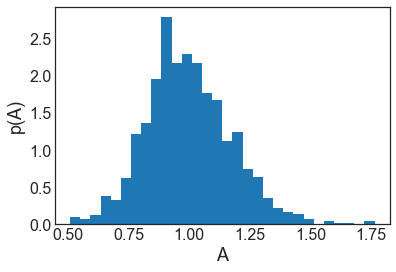

In [36]:
_=plt.hist(mcmc_results.T[0],bins=30,density=True)
plt.xlabel("A")
plt.ylabel("p(A)")
print(mcmc_results.T[0].mean())
print(mcmc_results.T[0].std())

0.02504127303088853
0.0035124814225483145


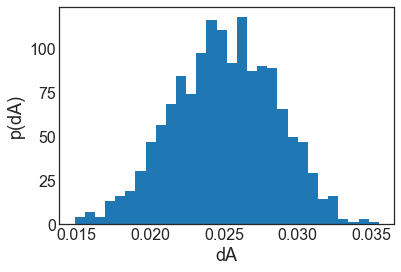

In [45]:
_=plt.hist(mcmc_results.T[2],bins=30,density=True)
plt.xlabel("dA")
plt.ylabel("p(dA)")
print(mcmc_results.T[2].mean())
print(mcmc_results.T[2].std())

0.9974228820754899
0.17601667044312633


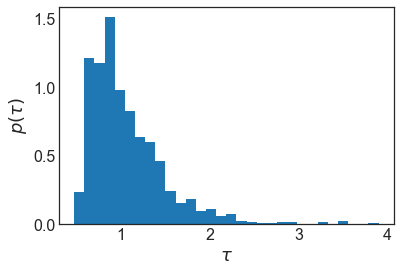

In [37]:
_=plt.hist(mcmc_results.T[1],bins=30,density=True)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
print(mcmc_results.T[0].mean())
print(mcmc_results.T[0].std())

0.03445481066712447
0.017580321689066866


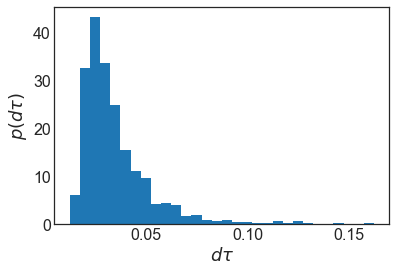

In [46]:
_=plt.hist(mcmc_results.T[3],bins=30,density=True)
plt.xlabel(r"$d\tau$")
plt.ylabel(r"$p(d\tau)$")
print(mcmc_results.T[3].mean())
print(mcmc_results.T[3].std())

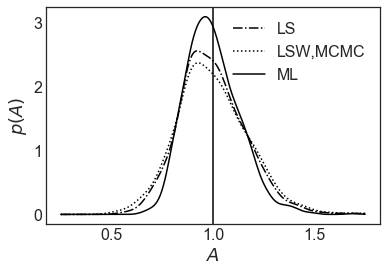

In [50]:
# amplitude KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0.25,1.75,200)
densityLS = gaussian_kde(result_array.T[2])
densityLSW = gaussian_kde(result_array.T[8])
densityML = gaussian_kde(result_Bayes_array.T[0])
densityMCMC = gaussian_kde(mcmc_results.T[0])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW,MCMC")
plt.plot(xs,densityML(xs),"k-",label="ML")
#plt.plot(xs,densityMCMC(xs),"k--",label="MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$A$")
plt.ylabel(r"$p(A)$")
plt.savefig("A_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

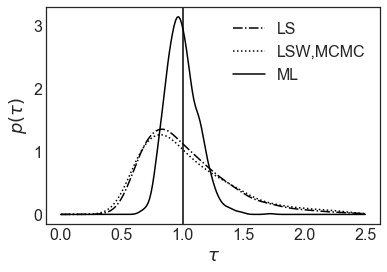

In [49]:
# decay time KDE Gaussian estimates for distribution function
plt.figure(facecolor="white")
xs = np.linspace(0,2.5,200)
densityLS = gaussian_kde(result_array.T[0])
densityLSW = gaussian_kde(result_array.T[6])
densityML = gaussian_kde(result_Bayes_array.T[2])
densityMCMC = gaussian_kde(mcmc_results.T[1])
#density.covariance_factor = lambda : .25
#density._compute_covariance()
plt.plot(xs,densityLS(xs),"k-.",label="LS")
plt.plot(xs,densityLSW(xs),"k:",label="LSW,MCMC")
plt.plot(xs,densityML(xs),"k-",label="ML")
#plt.plot(xs,densityMCMC(xs),"k--",label="MCMC")
plt.axvline(x=1.0,color="k")
plt.legend()
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau)$")
plt.savefig("tau_dist300kde.png",format="png",dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(1000, 12)
(1000, 4)
(0.7694821951564108, 1.5154940537614157e-196)


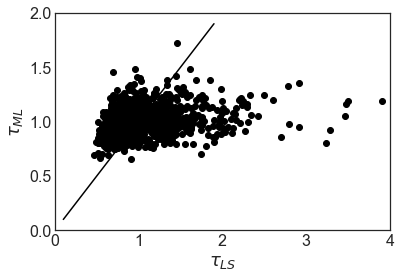

In [40]:
#decay correlation
print(result_array.shape)
print(result_Bayes_array.shape)
plt.scatter(mcmc_results.T[1],result_Bayes_array.T[2],color="k")
plt.plot([0.1,1.9],[0.1,1.9],"k")
plt.xlim((0,4))
plt.ylim((0,2))
plt.xlabel(r'$\tau_{LS}$')
plt.ylabel(r'$\tau_{ML}$')
print(pearsonr(mcmc_results.T[0],result_Bayes_array.T[2]))
plt.savefig("tau_corrMCMC300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

(0.7730946052960876, 1.575903800033717e-199)


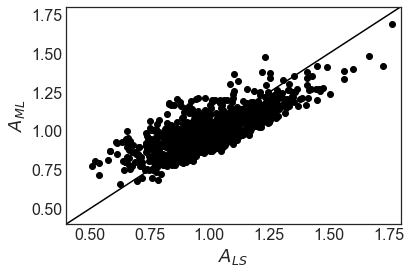

In [41]:
# amplitude correlation
plt.scatter(mcmc_results.T[0],result_Bayes_array.T[0],color="k")
plt.plot([0,1.8],[0,1.8],"k")
plt.xlim((0.4,1.8))
plt.ylim((0.4,1.8))
plt.xlabel(r'$A_{LS}$')
plt.ylabel(r'$A_{ML}$')
print(pearsonr(mcmc_results.T[0],result_Bayes_array.T[0]))
plt.savefig("A_corrMCMC300.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [42]:
print("Amplitude LS mean (real):",result_array.T[2].mean())
print("Amplitude LS std (real):",result_array.T[2].std())
print("Amplitude LS stderr (real):",result_array.T[2].std()/np.sqrt(N))
print("Amplitude LS std (fit):",np.sqrt(result_array.T[3]).mean())
print("Amplitude LS std (fit corrected):",dA.mean())
print("Amplitude LSW mean (real):",result_array.T[7].mean())
print("Amplitude LSW std (real):",result_array.T[7].std())
print("Amplitude LSW stderr (real):",result_array.T[7].std()/np.sqrt(N))
print("Amplitude LSW std (fit):",np.sqrt(result_array.T[8]).mean())
print("Amplitude LSW std (fit corrected):",dAW.mean())
print("Amplitude Bayes mean (real):",result_Bayes_array.T[0].mean())
print("Amplitude Bayes std (real):",result_Bayes_array.T[0].std())
print("Amplitude Bayes std (fit):",result_Bayes_array.T[1].mean())
print("Amplitude MCMC mean (real):",mcmc_results.T[0].mean())
print("Amplitude MCMC std (real):",mcmc_results.T[0].std())
print("Amplitude MCMC std (fit):",mcmc_results.T[2].mean())

Amplitude LS mean (real): 0.9984105682703185
Amplitude LS std (real): 0.16181660243234747
Amplitude LS stderr (real): 0.0016181660243234748
Amplitude LS std (fit): 1.6478751794738906
Amplitude LS std (fit corrected): 1.6578702573632431
Amplitude LSW mean (real): 0.0002714528255314531
Amplitude LSW std (real): 0.00034691485586727563
Amplitude LSW stderr (real): 3.4691485586727565e-06
Amplitude LSW std (fit): 0.9950832668680414
Amplitude LSW std (fit corrected): 1.6578702573632431
Amplitude Bayes mean (real): 0.9974432559467948
Amplitude Bayes std (real): 0.13182747665608338
Amplitude Bayes std (fit): 0.1410535876226702
Amplitude MCMC mean (real): 0.9974228820754899
Amplitude MCMC std (real): 0.17601667044312633
Amplitude MCMC std (fit): 0.02504127303088853


In [43]:
print("Decay time LS mean (real):",result_array.T[0].mean())
print("Decay time LS std (real):",result_array.T[0].std())
print("Decay time LS stderr (real):",result_array.T[0].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[0].mean()-1)/result_array.T[0].std()*np.sqrt(N))
print("Decay time LS std (fit):",(np.sqrt(result_array.T[1])*delta_t).mean())
print("Decay time LS std (fit corrected):",dT.mean())
print("Decay time LSW mean (real):",result_array.T[5].mean())
print("Decay time LSW std (real):",result_array.T[5].std())
print("Decay time LSW stderr (real):",result_array.T[5].std()/np.sqrt(N))
print("Decay time (mean-true)/stderr:",(result_array.T[5].mean()-1)/result_array.T[5].std()*np.sqrt(N))
print("Decay time LSW std (fit):",np.sqrt(result_array.T[6]*delta_t).mean())
print("Decay time LSW std (fit corrected):",dTW.mean())
print("Decay time Bayes mean (real):",result_Bayes_array.T[2].mean())
print("Decay time Bayes std (real):",result_Bayes_array.T[2].std())
print("Decay time Bayes stderr (real):",result_Bayes_array.T[2].std()/np.sqrt(N))
print("Decay time Bayes std (fit):",result_Bayes_array.T[3].mean())
print("Decay time MCMC mean (real):",mcmc_results.T[1].mean())
print("Decay time MCMC std (real):",mcmc_results.T[1].std())
print("Decay time MCMC std (fit):",mcmc_results.T[2].mean())

Decay time LS mean (real): 1.0511330280624347
Decay time LS std (real): 0.3905818920277206
Decay time LS stderr (real): 0.0039058189202772057
Decay time (mean-true)/stderr: 13.091499914902776
Decay time LS std (fit): 0.00011450259084103781
Decay time LS std (fit corrected): 0.000113979437567719
Decay time LSW mean (real): 1.953151405981036
Decay time LSW std (real): 2.062856350876919
Decay time LSW stderr (real): 0.020628563508769193
Decay time (mean-true)/stderr: 46.20541830631357
Decay time LSW std (fit): 0.10150797451666932
Decay time LSW std (fit corrected): 0.000113979437567719
Decay time Bayes mean (real): 0.9971927568886603
Decay time Bayes std (real): 0.13307109625094737
Decay time Bayes stderr (real): 0.0013307109625094737
Decay time Bayes std (fit): 0.141744498927101
Decay time MCMC mean (real): 1.0678717320803535
Decay time MCMC std (real): 0.43881706612621196
Decay time MCMC std (fit): 0.02504127303088853
